In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
#Progress bar fix: use callbacks=[TQDMNotebookCallback()] in model.fit
#verbose=0 is also required
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook as tqdm
from kerastuner.tuners import RandomSearch

from time import time
import numpy as np
import random
import matplotlib.pyplot as plt

from PIL import Image

import h5py

from multiprocessing import Pool as ThreadPool

#Generate rotated images on the fly
#import DataGenerator

In [8]:
BATCH_SIZE=32

In [25]:
file_path = "/home/amitp/Documents/Python/Training Orientation Detection/training_dataset_all_doric_cabled.h5"
with h5py.File(file_path,'r') as f:
    data = f['/frames'][:322280]

In [26]:
angles = np.ndarray(data.shape[0])
np.random.seed(0)
def RotateFrame(args):
    i=args[0]
    frame=args[1]
    a = np.random.random()*180
    rotated=np.array(Image.fromarray(frame).rotate(a))
    data[i]=np.array(rotated)
    return a
pool = ThreadPool(8)
i=0
for val in tqdm(pool.imap(RotateFrame,list(enumerate(data))), total=len(data)):
    angles[i]=val
    i+=1
pool.close()
pool.join()

In [ ]:
#train_gen=DataGenerator.DataGenerator(data,BATCH_SIZE)
#valid_gen=DataGenerator.DataGenerator(data,BATCH_SIZE)

In [27]:
# old-fashioned convnet for flip detection...
def orientationDetector(
                hypertuner,
                input_shape=(80, 80, 1),
                stride_length=(1, 1),
                kernel=(4, 4),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('linear'),
                batch_momentum=.999,
                combine=True,
                padding='valid',
                batch_norm=False
            ):
    #filter_pow = hypertuner.Range('nfilters',min_value=2,max_value=6,step=1)
    nfilters=[4,8,16,32]#np.logspace(start=filter_pow,stop=filter_pow+3,base=2,num=4)
    inputs = layers.Input(shape=input_shape)
    x = inputs

    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer
    }

    # encode net
    for filters in nfilters:
        x = layers.Conv2D(filters, kernel, **conv_parameters)(x)
        x = layers.BatchNormalization(momentum=batch_momentum)(x)
        #x = layers.Dropout(0.2)(x)
        x = activation(x)
        x = layers.MaxPooling2D((2, 2), padding=padding)(x)
    x = layers.Conv2D(1, (1, 1))(x)
    x = activation(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = output_activation(x)

    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-4,#hypertuner.Choice('learning_rate', values=[1e-3, 1e-4,1e-5]),
            momentum=0.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model

In [28]:
if len(data.shape) < 4:
    data=data[...,None]
train_data = data[:250000]
train_angles = angles[:250000]
val_data = data[250000:280000]
val_angles = angles[250000:280000]
test_data=data[280000:]
test_angles=angles[280000:]

In [29]:
#tuner = RandomSearch(
#    orientationDetector,
#    objective='val_loss',
#    max_trials=5,
#    project_name='Orientation Detector Tuning')
#tuner.search_space_summary()
#tuner.search(train_data,train_angles,epochs=5,validation_data=(val_data,val_angles),workers=4)
#tensorboard = TensorBoard(log_dir="logs\{}".format(time()))
#cb = TQDMNotebookCallback()
model = orientationDetector(None)
model.summary()
history= model.fit(train_data, train_angles, batch_size=BATCH_SIZE, epochs=5, verbose=1, validation_data=(val_data,val_angles),callbacks=[ProgbarLogger])#, callbacks=[tensorboard])
#history= model.fit_generator(generator=train_gen, epochs=5, verbose=1, validation_data=valid_gen,use_multiprocessing=True,workers=4,callbacks=[])#, callbacks=[tensorboard])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 77, 77, 4)    68          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 77, 77, 4)    16          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         multiple             0           batch_normalization_4[0][0]      
                                                                 batch_normalization_5[0][0]

  5664/250000 [..............................] - ETA: 1:11:55 - loss: 9024.8760 - mse: 9024.87 - ETA: 40:19 - loss: 9891.6196 - mse: 9891.6191 - ETA: 29:59 - loss: 8912.0186 - mse: 8912.01 - ETA: 24:44 - loss: 8915.4133 - mse: 8915.41 - ETA: 21:45 - loss: 9042.4188 - mse: 9042.41 - ETA: 19:37 - loss: 9037.0426 - mse: 9037.04 - ETA: 18:09 - loss: 8891.3124 - mse: 8891.31 - ETA: 17:11 - loss: 8814.0475 - mse: 8814.04 - ETA: 17:04 - loss: 8652.6755 - mse: 8652.67 - ETA: 16:17 - loss: 8392.3861 - mse: 8392.38 - ETA: 15:38 - loss: 7954.1051 - mse: 7954.10 - ETA: 15:08 - loss: 7566.1471 - mse: 7566.14 - ETA: 14:42 - loss: 7333.4438 - mse: 7333.44 - ETA: 14:20 - loss: 7077.7952 - mse: 7077.79 - ETA: 14:01 - loss: 6731.8245 - mse: 6731.82 - ETA: 13:44 - loss: 6409.0612 - mse: 6409.06 - ETA: 13:31 - loss: 6082.9528 - mse: 6082.95 - ETA: 13:18 - loss: 5822.9395 - mse: 5822.93 - ETA: 13:08 - loss: 5615.9304 - mse: 5615.93 - ETA: 12:58 - loss: 5412.7722 - mse: 5412.77 - ETA: 12:49 - loss: 5215.573

 35328/250000 [===>..........................] - ETA: 8:09 - loss: 493.6420 - mse: 493.642 - ETA: 8:09 - loss: 493.3839 - mse: 493.384 - ETA: 8:09 - loss: 493.0733 - mse: 493.073 - ETA: 8:09 - loss: 492.8004 - mse: 492.800 - ETA: 8:09 - loss: 492.3992 - mse: 492.399 - ETA: 8:09 - loss: 492.0240 - mse: 492.024 - ETA: 8:09 - loss: 491.9382 - mse: 491.938 - ETA: 8:08 - loss: 491.7597 - mse: 491.759 - ETA: 8:08 - loss: 491.3377 - mse: 491.337 - ETA: 8:09 - loss: 491.1318 - mse: 491.132 - ETA: 8:09 - loss: 490.9238 - mse: 490.924 - ETA: 8:09 - loss: 490.5197 - mse: 490.519 - ETA: 8:09 - loss: 490.2993 - mse: 490.299 - ETA: 8:09 - loss: 490.5682 - mse: 490.568 - ETA: 8:09 - loss: 490.3403 - mse: 490.340 - ETA: 8:09 - loss: 490.1734 - mse: 490.173 - ETA: 8:09 - loss: 489.8148 - mse: 489.815 - ETA: 8:09 - loss: 489.4208 - mse: 489.421 - ETA: 8:08 - loss: 489.0553 - mse: 489.055 - ETA: 8:08 - loss: 488.6111 - mse: 488.611 - ETA: 8:08 - loss: 488.3613 - mse: 488.361 - ETA: 8:08 - loss: 488.0826 

 41280/250000 [===>..........................] - ETA: 7:56 - loss: 452.0071 - mse: 452.007 - ETA: 7:56 - loss: 451.7283 - mse: 451.728 - ETA: 7:56 - loss: 451.3695 - mse: 451.369 - ETA: 7:56 - loss: 451.1942 - mse: 451.194 - ETA: 7:56 - loss: 451.0915 - mse: 451.091 - ETA: 7:56 - loss: 451.1304 - mse: 451.130 - ETA: 7:56 - loss: 450.7976 - mse: 450.798 - ETA: 7:55 - loss: 450.4657 - mse: 450.466 - ETA: 7:55 - loss: 450.3977 - mse: 450.398 - ETA: 7:55 - loss: 450.1777 - mse: 450.178 - ETA: 7:55 - loss: 449.9061 - mse: 449.906 - ETA: 7:55 - loss: 449.9644 - mse: 449.964 - ETA: 7:55 - loss: 450.1627 - mse: 450.163 - ETA: 7:55 - loss: 450.0680 - mse: 450.068 - ETA: 7:55 - loss: 449.9962 - mse: 449.996 - ETA: 7:55 - loss: 449.8811 - mse: 449.881 - ETA: 7:55 - loss: 449.6551 - mse: 449.655 - ETA: 7:55 - loss: 449.5124 - mse: 449.512 - ETA: 7:55 - loss: 449.3888 - mse: 449.389 - ETA: 7:55 - loss: 449.2510 - mse: 449.251 - ETA: 7:55 - loss: 449.0254 - mse: 449.025 - ETA: 7:54 - loss: 448.7102 

 47232/250000 [====>.........................] - ETA: 7:43 - loss: 428.7281 - mse: 428.728 - ETA: 7:43 - loss: 428.5545 - mse: 428.554 - ETA: 7:43 - loss: 429.2635 - mse: 429.263 - ETA: 7:42 - loss: 429.1460 - mse: 429.146 - ETA: 7:42 - loss: 428.9190 - mse: 428.919 - ETA: 7:42 - loss: 428.9903 - mse: 428.990 - ETA: 7:42 - loss: 429.0612 - mse: 429.061 - ETA: 7:42 - loss: 428.9641 - mse: 428.964 - ETA: 7:42 - loss: 428.7934 - mse: 428.793 - ETA: 7:42 - loss: 428.6766 - mse: 428.676 - ETA: 7:42 - loss: 428.4611 - mse: 428.461 - ETA: 7:42 - loss: 428.2293 - mse: 428.229 - ETA: 7:41 - loss: 428.1037 - mse: 428.103 - ETA: 7:41 - loss: 427.8847 - mse: 427.884 - ETA: 7:41 - loss: 427.9533 - mse: 427.953 - ETA: 7:41 - loss: 427.8632 - mse: 427.863 - ETA: 7:41 - loss: 427.5931 - mse: 427.593 - ETA: 7:41 - loss: 427.4228 - mse: 427.423 - ETA: 7:41 - loss: 427.5075 - mse: 427.507 - ETA: 7:41 - loss: 427.4461 - mse: 427.446 - ETA: 7:41 - loss: 427.1992 - mse: 427.199 - ETA: 7:40 - loss: 426.9848 

 53184/250000 [=====>........................] - ETA: 7:24 - loss: 403.8197 - mse: 403.819 - ETA: 7:24 - loss: 403.6068 - mse: 403.606 - ETA: 7:24 - loss: 403.6581 - mse: 403.658 - ETA: 7:24 - loss: 403.4358 - mse: 403.436 - ETA: 7:24 - loss: 403.3636 - mse: 403.363 - ETA: 7:24 - loss: 403.1998 - mse: 403.200 - ETA: 7:24 - loss: 403.0827 - mse: 403.082 - ETA: 7:24 - loss: 402.9932 - mse: 402.993 - ETA: 7:23 - loss: 402.8598 - mse: 402.859 - ETA: 7:23 - loss: 402.9848 - mse: 402.984 - ETA: 7:23 - loss: 403.0440 - mse: 403.044 - ETA: 7:23 - loss: 402.9031 - mse: 402.903 - ETA: 7:23 - loss: 402.7172 - mse: 402.717 - ETA: 7:23 - loss: 402.4946 - mse: 402.494 - ETA: 7:23 - loss: 402.5853 - mse: 402.585 - ETA: 7:23 - loss: 402.5617 - mse: 402.561 - ETA: 7:23 - loss: 402.3959 - mse: 402.396 - ETA: 7:23 - loss: 402.1676 - mse: 402.167 - ETA: 7:23 - loss: 402.0112 - mse: 402.011 - ETA: 7:23 - loss: 402.0327 - mse: 402.032 - ETA: 7:23 - loss: 401.7815 - mse: 401.781 - ETA: 7:22 - loss: 401.5475 

 59136/250000 [======>.......................] - ETA: 7:10 - loss: 386.2981 - mse: 386.298 - ETA: 7:10 - loss: 386.1488 - mse: 386.148 - ETA: 7:10 - loss: 385.9794 - mse: 385.979 - ETA: 7:10 - loss: 386.0335 - mse: 386.033 - ETA: 7:10 - loss: 386.0771 - mse: 386.077 - ETA: 7:10 - loss: 386.2174 - mse: 386.217 - ETA: 7:09 - loss: 386.1898 - mse: 386.189 - ETA: 7:09 - loss: 385.9842 - mse: 385.984 - ETA: 7:09 - loss: 385.7833 - mse: 385.783 - ETA: 7:09 - loss: 385.6486 - mse: 385.648 - ETA: 7:09 - loss: 385.4381 - mse: 385.438 - ETA: 7:09 - loss: 385.2771 - mse: 385.277 - ETA: 7:09 - loss: 385.1363 - mse: 385.136 - ETA: 7:09 - loss: 384.9890 - mse: 384.989 - ETA: 7:09 - loss: 384.8005 - mse: 384.800 - ETA: 7:09 - loss: 384.6905 - mse: 384.690 - ETA: 7:09 - loss: 384.4949 - mse: 384.494 - ETA: 7:09 - loss: 384.4631 - mse: 384.463 - ETA: 7:09 - loss: 384.3106 - mse: 384.310 - ETA: 7:09 - loss: 384.2048 - mse: 384.204 - ETA: 7:09 - loss: 384.1449 - mse: 384.145 - ETA: 7:08 - loss: 383.9760 

 65088/250000 [======>.......................] - ETA: 6:59 - loss: 368.7811 - mse: 368.781 - ETA: 6:58 - loss: 368.6920 - mse: 368.692 - ETA: 6:58 - loss: 368.6048 - mse: 368.604 - ETA: 6:58 - loss: 368.4596 - mse: 368.459 - ETA: 6:58 - loss: 368.2935 - mse: 368.293 - ETA: 6:58 - loss: 368.1642 - mse: 368.164 - ETA: 6:58 - loss: 368.0135 - mse: 368.013 - ETA: 6:58 - loss: 367.8706 - mse: 367.870 - ETA: 6:58 - loss: 367.7027 - mse: 367.702 - ETA: 6:58 - loss: 367.5369 - mse: 367.536 - ETA: 6:58 - loss: 367.4763 - mse: 367.476 - ETA: 6:58 - loss: 367.3280 - mse: 367.328 - ETA: 6:57 - loss: 367.2694 - mse: 367.269 - ETA: 6:57 - loss: 367.1288 - mse: 367.128 - ETA: 6:57 - loss: 367.0455 - mse: 367.045 - ETA: 6:57 - loss: 366.8997 - mse: 366.899 - ETA: 6:57 - loss: 366.7825 - mse: 366.782 - ETA: 6:57 - loss: 366.7521 - mse: 366.752 - ETA: 6:57 - loss: 366.6110 - mse: 366.611 - ETA: 6:57 - loss: 366.5348 - mse: 366.534 - ETA: 6:57 - loss: 366.4989 - mse: 366.499 - ETA: 6:57 - loss: 366.3434 

 71040/250000 [=======>......................] - ETA: 6:43 - loss: 352.5112 - mse: 352.511 - ETA: 6:42 - loss: 352.6301 - mse: 352.630 - ETA: 6:42 - loss: 352.4819 - mse: 352.481 - ETA: 6:42 - loss: 352.3937 - mse: 352.393 - ETA: 6:42 - loss: 352.4094 - mse: 352.409 - ETA: 6:42 - loss: 352.2761 - mse: 352.276 - ETA: 6:42 - loss: 352.1857 - mse: 352.185 - ETA: 6:42 - loss: 352.0787 - mse: 352.078 - ETA: 6:42 - loss: 351.9913 - mse: 351.991 - ETA: 6:42 - loss: 351.8479 - mse: 351.847 - ETA: 6:42 - loss: 351.8020 - mse: 351.801 - ETA: 6:42 - loss: 351.6838 - mse: 351.683 - ETA: 6:42 - loss: 351.5533 - mse: 351.553 - ETA: 6:42 - loss: 351.4100 - mse: 351.410 - ETA: 6:42 - loss: 351.3228 - mse: 351.322 - ETA: 6:42 - loss: 351.2942 - mse: 351.294 - ETA: 6:42 - loss: 351.1694 - mse: 351.169 - ETA: 6:41 - loss: 351.0363 - mse: 351.036 - ETA: 6:41 - loss: 351.0022 - mse: 351.002 - ETA: 6:41 - loss: 350.9840 - mse: 350.984 - ETA: 6:41 - loss: 350.9171 - mse: 350.917 - ETA: 6:41 - loss: 350.7746 

 76992/250000 [========>.....................] - ETA: 6:30 - loss: 339.1543 - mse: 339.154 - ETA: 6:30 - loss: 339.0495 - mse: 339.049 - ETA: 6:30 - loss: 338.9100 - mse: 338.910 - ETA: 6:30 - loss: 338.8297 - mse: 338.829 - ETA: 6:30 - loss: 338.7500 - mse: 338.749 - ETA: 6:30 - loss: 338.6409 - mse: 338.640 - ETA: 6:30 - loss: 338.5784 - mse: 338.578 - ETA: 6:29 - loss: 338.5780 - mse: 338.577 - ETA: 6:29 - loss: 338.5539 - mse: 338.553 - ETA: 6:29 - loss: 338.4559 - mse: 338.455 - ETA: 6:29 - loss: 338.3460 - mse: 338.346 - ETA: 6:29 - loss: 338.2460 - mse: 338.246 - ETA: 6:29 - loss: 338.1279 - mse: 338.127 - ETA: 6:29 - loss: 338.0703 - mse: 338.070 - ETA: 6:29 - loss: 337.9706 - mse: 337.970 - ETA: 6:29 - loss: 337.8616 - mse: 337.861 - ETA: 6:29 - loss: 337.7794 - mse: 337.779 - ETA: 6:29 - loss: 337.6836 - mse: 337.683 - ETA: 6:29 - loss: 337.5664 - mse: 337.566 - ETA: 6:29 - loss: 337.5397 - mse: 337.539 - ETA: 6:29 - loss: 337.4718 - mse: 337.471 - ETA: 6:28 - loss: 337.3460 

 82944/250000 [========>.....................] - ETA: 6:17 - loss: 327.9015 - mse: 327.901 - ETA: 6:17 - loss: 327.8122 - mse: 327.812 - ETA: 6:17 - loss: 327.7499 - mse: 327.750 - ETA: 6:17 - loss: 327.6942 - mse: 327.694 - ETA: 6:17 - loss: 327.5895 - mse: 327.589 - ETA: 6:17 - loss: 327.5526 - mse: 327.552 - ETA: 6:17 - loss: 327.5688 - mse: 327.568 - ETA: 6:16 - loss: 327.5389 - mse: 327.539 - ETA: 6:16 - loss: 327.4356 - mse: 327.435 - ETA: 6:16 - loss: 327.3845 - mse: 327.384 - ETA: 6:16 - loss: 327.3768 - mse: 327.377 - ETA: 6:16 - loss: 327.3179 - mse: 327.318 - ETA: 6:16 - loss: 327.2118 - mse: 327.211 - ETA: 6:16 - loss: 327.0956 - mse: 327.095 - ETA: 6:16 - loss: 327.0087 - mse: 327.008 - ETA: 6:16 - loss: 326.9243 - mse: 326.924 - ETA: 6:16 - loss: 326.8222 - mse: 326.822 - ETA: 6:16 - loss: 326.7352 - mse: 326.735 - ETA: 6:16 - loss: 326.6307 - mse: 326.630 - ETA: 6:16 - loss: 326.5381 - mse: 326.538 - ETA: 6:16 - loss: 326.4598 - mse: 326.459 - ETA: 6:15 - loss: 326.3479 

 88896/250000 [=========>....................] - ETA: 6:02 - loss: 319.4854 - mse: 319.485 - ETA: 6:02 - loss: 319.4010 - mse: 319.401 - ETA: 6:02 - loss: 319.3032 - mse: 319.303 - ETA: 6:02 - loss: 319.2539 - mse: 319.254 - ETA: 6:02 - loss: 319.1775 - mse: 319.177 - ETA: 6:02 - loss: 319.0855 - mse: 319.085 - ETA: 6:02 - loss: 319.0058 - mse: 319.005 - ETA: 6:02 - loss: 318.9374 - mse: 318.937 - ETA: 6:02 - loss: 318.8944 - mse: 318.894 - ETA: 6:02 - loss: 318.8361 - mse: 318.836 - ETA: 6:02 - loss: 318.8926 - mse: 318.892 - ETA: 6:02 - loss: 318.8113 - mse: 318.811 - ETA: 6:01 - loss: 318.7145 - mse: 318.714 - ETA: 6:01 - loss: 318.7595 - mse: 318.759 - ETA: 6:01 - loss: 318.6938 - mse: 318.693 - ETA: 6:01 - loss: 319.0413 - mse: 319.041 - ETA: 6:01 - loss: 318.9724 - mse: 318.972 - ETA: 6:01 - loss: 318.9484 - mse: 318.948 - ETA: 6:01 - loss: 318.8919 - mse: 318.891 - ETA: 6:01 - loss: 318.8784 - mse: 318.878 - ETA: 6:01 - loss: 318.8819 - mse: 318.882 - ETA: 6:01 - loss: 318.9549 

 94848/250000 [==========>...................] - ETA: 5:47 - loss: 309.6197 - mse: 309.619 - ETA: 5:47 - loss: 309.5543 - mse: 309.554 - ETA: 5:47 - loss: 309.4580 - mse: 309.458 - ETA: 5:47 - loss: 309.3725 - mse: 309.372 - ETA: 5:47 - loss: 309.3099 - mse: 309.309 - ETA: 5:47 - loss: 309.2277 - mse: 309.227 - ETA: 5:47 - loss: 309.1822 - mse: 309.182 - ETA: 5:47 - loss: 309.1428 - mse: 309.142 - ETA: 5:47 - loss: 309.0477 - mse: 309.047 - ETA: 5:47 - loss: 309.0100 - mse: 309.010 - ETA: 5:46 - loss: 308.9453 - mse: 308.945 - ETA: 5:46 - loss: 308.8811 - mse: 308.881 - ETA: 5:46 - loss: 308.9026 - mse: 308.902 - ETA: 5:46 - loss: 308.8348 - mse: 308.834 - ETA: 5:46 - loss: 308.7788 - mse: 308.778 - ETA: 5:46 - loss: 308.6836 - mse: 308.683 - ETA: 5:46 - loss: 308.6889 - mse: 308.689 - ETA: 5:46 - loss: 308.6585 - mse: 308.658 - ETA: 5:46 - loss: 308.5588 - mse: 308.558 - ETA: 5:46 - loss: 308.5245 - mse: 308.524 - ETA: 5:46 - loss: 308.4405 - mse: 308.440 - ETA: 5:46 - loss: 308.4430 

100800/250000 [===========>..................] - ETA: 5:33 - loss: 301.3580 - mse: 301.358 - ETA: 5:33 - loss: 301.3161 - mse: 301.316 - ETA: 5:33 - loss: 301.2659 - mse: 301.266 - ETA: 5:33 - loss: 301.1935 - mse: 301.193 - ETA: 5:33 - loss: 301.1273 - mse: 301.127 - ETA: 5:33 - loss: 301.0560 - mse: 301.056 - ETA: 5:32 - loss: 300.9817 - mse: 300.981 - ETA: 5:32 - loss: 301.0006 - mse: 301.000 - ETA: 5:32 - loss: 300.9185 - mse: 300.918 - ETA: 5:32 - loss: 300.8580 - mse: 300.858 - ETA: 5:32 - loss: 300.8423 - mse: 300.842 - ETA: 5:32 - loss: 300.8547 - mse: 300.854 - ETA: 5:32 - loss: 300.9365 - mse: 300.936 - ETA: 5:32 - loss: 300.8539 - mse: 300.853 - ETA: 5:32 - loss: 300.8042 - mse: 300.804 - ETA: 5:32 - loss: 300.8439 - mse: 300.843 - ETA: 5:32 - loss: 300.8698 - mse: 300.869 - ETA: 5:32 - loss: 300.8950 - mse: 300.895 - ETA: 5:32 - loss: 300.8367 - mse: 300.836 - ETA: 5:31 - loss: 300.7907 - mse: 300.790 - ETA: 5:31 - loss: 300.7998 - mse: 300.799 - ETA: 5:31 - loss: 300.7267 

106752/250000 [===========>..................] - ETA: 5:18 - loss: 293.8071 - mse: 293.807 - ETA: 5:18 - loss: 293.7298 - mse: 293.729 - ETA: 5:18 - loss: 293.7368 - mse: 293.736 - ETA: 5:18 - loss: 293.7346 - mse: 293.734 - ETA: 5:18 - loss: 293.6514 - mse: 293.651 - ETA: 5:18 - loss: 293.6757 - mse: 293.675 - ETA: 5:18 - loss: 293.5981 - mse: 293.598 - ETA: 5:18 - loss: 293.6654 - mse: 293.665 - ETA: 5:18 - loss: 293.8564 - mse: 293.856 - ETA: 5:18 - loss: 293.8118 - mse: 293.811 - ETA: 5:17 - loss: 293.7568 - mse: 293.756 - ETA: 5:17 - loss: 293.7144 - mse: 293.714 - ETA: 5:17 - loss: 293.7604 - mse: 293.760 - ETA: 5:17 - loss: 293.6994 - mse: 293.699 - ETA: 5:17 - loss: 293.6339 - mse: 293.633 - ETA: 5:17 - loss: 293.5737 - mse: 293.573 - ETA: 5:17 - loss: 293.5165 - mse: 293.516 - ETA: 5:17 - loss: 293.4811 - mse: 293.481 - ETA: 5:17 - loss: 293.5178 - mse: 293.517 - ETA: 5:17 - loss: 293.4730 - mse: 293.473 - ETA: 5:17 - loss: 293.4248 - mse: 293.424 - ETA: 5:17 - loss: 293.3667 

112704/250000 [============>.................] - ETA: 5:05 - loss: 287.3480 - mse: 287.348 - ETA: 5:05 - loss: 287.2712 - mse: 287.271 - ETA: 5:05 - loss: 287.1915 - mse: 287.191 - ETA: 5:04 - loss: 287.1371 - mse: 287.137 - ETA: 5:04 - loss: 287.1381 - mse: 287.138 - ETA: 5:04 - loss: 287.0751 - mse: 287.075 - ETA: 5:04 - loss: 287.0024 - mse: 287.002 - ETA: 5:04 - loss: 286.9273 - mse: 286.927 - ETA: 5:04 - loss: 286.8488 - mse: 286.848 - ETA: 5:04 - loss: 286.7889 - mse: 286.788 - ETA: 5:04 - loss: 286.7697 - mse: 286.769 - ETA: 5:04 - loss: 286.7875 - mse: 286.787 - ETA: 5:04 - loss: 286.7573 - mse: 286.757 - ETA: 5:04 - loss: 286.7110 - mse: 286.711 - ETA: 5:04 - loss: 286.7295 - mse: 286.729 - ETA: 5:04 - loss: 286.6795 - mse: 286.679 - ETA: 5:03 - loss: 286.6491 - mse: 286.649 - ETA: 5:03 - loss: 286.6594 - mse: 286.659 - ETA: 5:03 - loss: 286.6264 - mse: 286.626 - ETA: 5:03 - loss: 286.5771 - mse: 286.577 - ETA: 5:03 - loss: 286.5011 - mse: 286.501 - ETA: 5:03 - loss: 286.4688 

118656/250000 [=============>................] - ETA: 4:51 - loss: 281.3892 - mse: 281.389 - ETA: 4:51 - loss: 281.3290 - mse: 281.328 - ETA: 4:51 - loss: 281.3048 - mse: 281.304 - ETA: 4:51 - loss: 281.2419 - mse: 281.241 - ETA: 4:51 - loss: 281.2040 - mse: 281.203 - ETA: 4:51 - loss: 281.1403 - mse: 281.140 - ETA: 4:50 - loss: 281.0747 - mse: 281.074 - ETA: 4:50 - loss: 281.1302 - mse: 281.130 - ETA: 4:50 - loss: 281.0783 - mse: 281.078 - ETA: 4:50 - loss: 281.0473 - mse: 281.047 - ETA: 4:50 - loss: 281.0754 - mse: 281.075 - ETA: 4:50 - loss: 281.0271 - mse: 281.027 - ETA: 4:50 - loss: 281.0440 - mse: 281.043 - ETA: 4:50 - loss: 281.0219 - mse: 281.021 - ETA: 4:50 - loss: 280.9803 - mse: 280.980 - ETA: 4:50 - loss: 280.9306 - mse: 280.930 - ETA: 4:50 - loss: 280.8914 - mse: 280.891 - ETA: 4:50 - loss: 280.8234 - mse: 280.823 - ETA: 4:50 - loss: 280.7845 - mse: 280.784 - ETA: 4:49 - loss: 280.7765 - mse: 280.776 - ETA: 4:49 - loss: 280.7269 - mse: 280.726 - ETA: 4:49 - loss: 280.6567 

124608/250000 [=============>................] - ETA: 4:38 - loss: 276.0493 - mse: 276.049 - ETA: 4:38 - loss: 275.9823 - mse: 275.982 - ETA: 4:38 - loss: 275.9221 - mse: 275.921 - ETA: 4:38 - loss: 275.8588 - mse: 275.858 - ETA: 4:38 - loss: 275.9059 - mse: 275.905 - ETA: 4:38 - loss: 275.8989 - mse: 275.898 - ETA: 4:38 - loss: 275.9519 - mse: 275.951 - ETA: 4:38 - loss: 275.9069 - mse: 275.906 - ETA: 4:38 - loss: 275.8611 - mse: 275.860 - ETA: 4:37 - loss: 275.8029 - mse: 275.802 - ETA: 4:37 - loss: 275.7586 - mse: 275.758 - ETA: 4:37 - loss: 275.6922 - mse: 275.692 - ETA: 4:37 - loss: 275.7256 - mse: 275.725 - ETA: 4:37 - loss: 275.6681 - mse: 275.667 - ETA: 4:37 - loss: 275.6333 - mse: 275.633 - ETA: 4:37 - loss: 275.5744 - mse: 275.574 - ETA: 4:37 - loss: 275.5278 - mse: 275.527 - ETA: 4:37 - loss: 275.5637 - mse: 275.563 - ETA: 4:37 - loss: 275.5366 - mse: 275.536 - ETA: 4:37 - loss: 275.4878 - mse: 275.487 - ETA: 4:37 - loss: 275.4309 - mse: 275.430 - ETA: 4:37 - loss: 275.3841 

130560/250000 [==============>...............] - ETA: 4:25 - loss: 270.4969 - mse: 270.496 - ETA: 4:25 - loss: 270.4658 - mse: 270.465 - ETA: 4:25 - loss: 270.4822 - mse: 270.482 - ETA: 4:25 - loss: 270.4379 - mse: 270.437 - ETA: 4:25 - loss: 270.3848 - mse: 270.384 - ETA: 4:25 - loss: 270.3376 - mse: 270.337 - ETA: 4:25 - loss: 270.2745 - mse: 270.274 - ETA: 4:25 - loss: 270.3109 - mse: 270.310 - ETA: 4:25 - loss: 270.2754 - mse: 270.275 - ETA: 4:25 - loss: 270.2758 - mse: 270.275 - ETA: 4:24 - loss: 270.2250 - mse: 270.224 - ETA: 4:24 - loss: 270.1784 - mse: 270.178 - ETA: 4:24 - loss: 270.1499 - mse: 270.149 - ETA: 4:24 - loss: 270.0987 - mse: 270.098 - ETA: 4:24 - loss: 270.0442 - mse: 270.044 - ETA: 4:24 - loss: 270.0291 - mse: 270.029 - ETA: 4:24 - loss: 270.0634 - mse: 270.063 - ETA: 4:24 - loss: 270.0056 - mse: 270.005 - ETA: 4:24 - loss: 269.9860 - mse: 269.985 - ETA: 4:24 - loss: 270.0065 - mse: 270.006 - ETA: 4:24 - loss: 269.9552 - mse: 269.955 - ETA: 4:24 - loss: 269.9097 

136512/250000 [===============>..............] - ETA: 4:12 - loss: 265.4902 - mse: 265.490 - ETA: 4:12 - loss: 265.4503 - mse: 265.450 - ETA: 4:12 - loss: 265.4180 - mse: 265.417 - ETA: 4:12 - loss: 265.3782 - mse: 265.378 - ETA: 4:12 - loss: 265.3886 - mse: 265.388 - ETA: 4:12 - loss: 265.3624 - mse: 265.362 - ETA: 4:12 - loss: 265.3040 - mse: 265.304 - ETA: 4:12 - loss: 265.2773 - mse: 265.277 - ETA: 4:12 - loss: 265.2172 - mse: 265.217 - ETA: 4:11 - loss: 265.1631 - mse: 265.163 - ETA: 4:11 - loss: 265.1442 - mse: 265.144 - ETA: 4:11 - loss: 265.0922 - mse: 265.092 - ETA: 4:11 - loss: 265.1023 - mse: 265.102 - ETA: 4:11 - loss: 265.0919 - mse: 265.091 - ETA: 4:11 - loss: 265.0721 - mse: 265.072 - ETA: 4:11 - loss: 265.0478 - mse: 265.047 - ETA: 4:11 - loss: 265.0240 - mse: 265.024 - ETA: 4:11 - loss: 264.9987 - mse: 264.998 - ETA: 4:11 - loss: 264.9479 - mse: 264.947 - ETA: 4:11 - loss: 264.9136 - mse: 264.913 - ETA: 4:11 - loss: 264.9104 - mse: 264.910 - ETA: 4:11 - loss: 264.8499 

142464/250000 [================>.............] - ETA: 3:59 - loss: 260.8967 - mse: 260.896 - ETA: 3:59 - loss: 260.8979 - mse: 260.898 - ETA: 3:59 - loss: 260.9005 - mse: 260.900 - ETA: 3:59 - loss: 260.8731 - mse: 260.873 - ETA: 3:58 - loss: 260.8397 - mse: 260.839 - ETA: 3:58 - loss: 260.7976 - mse: 260.797 - ETA: 3:58 - loss: 260.7547 - mse: 260.754 - ETA: 3:58 - loss: 260.7255 - mse: 260.725 - ETA: 3:58 - loss: 260.6799 - mse: 260.680 - ETA: 3:58 - loss: 260.6888 - mse: 260.688 - ETA: 3:58 - loss: 260.6590 - mse: 260.659 - ETA: 3:58 - loss: 260.6257 - mse: 260.625 - ETA: 3:58 - loss: 260.5827 - mse: 260.582 - ETA: 3:58 - loss: 260.5995 - mse: 260.599 - ETA: 3:58 - loss: 260.5616 - mse: 260.561 - ETA: 3:58 - loss: 260.5269 - mse: 260.527 - ETA: 3:58 - loss: 260.4771 - mse: 260.477 - ETA: 3:58 - loss: 260.4704 - mse: 260.470 - ETA: 3:57 - loss: 260.4252 - mse: 260.425 - ETA: 3:57 - loss: 260.3731 - mse: 260.373 - ETA: 3:57 - loss: 260.3198 - mse: 260.319 - ETA: 3:57 - loss: 260.2747 

148416/250000 [================>.............] - ETA: 3:46 - loss: 256.7726 - mse: 256.772 - ETA: 3:46 - loss: 256.7405 - mse: 256.740 - ETA: 3:46 - loss: 256.6922 - mse: 256.692 - ETA: 3:46 - loss: 256.6475 - mse: 256.647 - ETA: 3:46 - loss: 256.6003 - mse: 256.600 - ETA: 3:46 - loss: 256.5548 - mse: 256.554 - ETA: 3:46 - loss: 256.5088 - mse: 256.508 - ETA: 3:46 - loss: 256.4567 - mse: 256.456 - ETA: 3:46 - loss: 256.4157 - mse: 256.415 - ETA: 3:45 - loss: 256.3831 - mse: 256.383 - ETA: 3:45 - loss: 256.3787 - mse: 256.378 - ETA: 3:45 - loss: 256.3398 - mse: 256.339 - ETA: 3:45 - loss: 256.2961 - mse: 256.296 - ETA: 3:45 - loss: 256.2788 - mse: 256.278 - ETA: 3:45 - loss: 256.4967 - mse: 256.496 - ETA: 3:45 - loss: 256.4549 - mse: 256.455 - ETA: 3:45 - loss: 256.4405 - mse: 256.440 - ETA: 3:45 - loss: 256.4590 - mse: 256.459 - ETA: 3:45 - loss: 256.4272 - mse: 256.427 - ETA: 3:45 - loss: 256.4419 - mse: 256.442 - ETA: 3:45 - loss: 256.4222 - mse: 256.422 - ETA: 3:45 - loss: 256.3854 

154368/250000 [=================>............] - ETA: 3:34 - loss: 253.3835 - mse: 253.383 - ETA: 3:33 - loss: 253.3648 - mse: 253.365 - ETA: 3:33 - loss: 253.3274 - mse: 253.327 - ETA: 3:33 - loss: 253.3090 - mse: 253.309 - ETA: 3:33 - loss: 253.2841 - mse: 253.284 - ETA: 3:33 - loss: 253.2498 - mse: 253.250 - ETA: 3:33 - loss: 253.2107 - mse: 253.210 - ETA: 3:33 - loss: 253.1888 - mse: 253.188 - ETA: 3:33 - loss: 253.1445 - mse: 253.144 - ETA: 3:33 - loss: 253.1073 - mse: 253.107 - ETA: 3:33 - loss: 253.0611 - mse: 253.061 - ETA: 3:33 - loss: 253.0239 - mse: 253.024 - ETA: 3:33 - loss: 252.9803 - mse: 252.980 - ETA: 3:33 - loss: 252.9436 - mse: 252.943 - ETA: 3:33 - loss: 252.8994 - mse: 252.899 - ETA: 3:32 - loss: 252.8568 - mse: 252.857 - ETA: 3:32 - loss: 252.8298 - mse: 252.830 - ETA: 3:32 - loss: 252.8078 - mse: 252.808 - ETA: 3:32 - loss: 252.7627 - mse: 252.762 - ETA: 3:32 - loss: 252.7193 - mse: 252.719 - ETA: 3:32 - loss: 252.7004 - mse: 252.700 - ETA: 3:32 - loss: 252.7361 

160320/250000 [==================>...........] - ETA: 3:21 - loss: 248.8510 - mse: 248.851 - ETA: 3:21 - loss: 248.8966 - mse: 248.897 - ETA: 3:21 - loss: 248.8930 - mse: 248.893 - ETA: 3:20 - loss: 248.8514 - mse: 248.851 - ETA: 3:20 - loss: 248.8398 - mse: 248.840 - ETA: 3:20 - loss: 248.7950 - mse: 248.795 - ETA: 3:20 - loss: 248.7538 - mse: 248.754 - ETA: 3:20 - loss: 248.7094 - mse: 248.709 - ETA: 3:20 - loss: 248.6640 - mse: 248.664 - ETA: 3:20 - loss: 248.6440 - mse: 248.644 - ETA: 3:20 - loss: 248.6119 - mse: 248.612 - ETA: 3:20 - loss: 248.5750 - mse: 248.575 - ETA: 3:20 - loss: 248.5470 - mse: 248.547 - ETA: 3:20 - loss: 248.5290 - mse: 248.529 - ETA: 3:20 - loss: 248.4842 - mse: 248.484 - ETA: 3:20 - loss: 248.4412 - mse: 248.441 - ETA: 3:20 - loss: 248.4497 - mse: 248.450 - ETA: 3:20 - loss: 248.4291 - mse: 248.429 - ETA: 3:19 - loss: 248.4040 - mse: 248.404 - ETA: 3:19 - loss: 248.3689 - mse: 248.369 - ETA: 3:19 - loss: 248.3309 - mse: 248.331 - ETA: 3:19 - loss: 248.3066 

166272/250000 [==================>...........] - ETA: 3:08 - loss: 244.3345 - mse: 244.334 - ETA: 3:08 - loss: 244.3004 - mse: 244.300 - ETA: 3:08 - loss: 244.2673 - mse: 244.267 - ETA: 3:08 - loss: 244.2283 - mse: 244.228 - ETA: 3:08 - loss: 244.1894 - mse: 244.189 - ETA: 3:08 - loss: 244.2010 - mse: 244.201 - ETA: 3:08 - loss: 244.1661 - mse: 244.166 - ETA: 3:08 - loss: 244.1292 - mse: 244.129 - ETA: 3:07 - loss: 244.0988 - mse: 244.099 - ETA: 3:07 - loss: 244.0942 - mse: 244.094 - ETA: 3:07 - loss: 244.0943 - mse: 244.094 - ETA: 3:07 - loss: 244.0735 - mse: 244.073 - ETA: 3:07 - loss: 244.0317 - mse: 244.031 - ETA: 3:07 - loss: 244.0148 - mse: 244.015 - ETA: 3:07 - loss: 244.0142 - mse: 244.014 - ETA: 3:07 - loss: 243.9919 - mse: 243.992 - ETA: 3:07 - loss: 243.9744 - mse: 243.974 - ETA: 3:07 - loss: 243.9514 - mse: 243.951 - ETA: 3:07 - loss: 243.9214 - mse: 243.921 - ETA: 3:07 - loss: 243.8847 - mse: 243.885 - ETA: 3:07 - loss: 243.8780 - mse: 243.878 - ETA: 3:07 - loss: 243.8484 

172224/250000 [===================>..........] - ETA: 2:55 - loss: 240.7879 - mse: 240.788 - ETA: 2:55 - loss: 240.7498 - mse: 240.750 - ETA: 2:55 - loss: 240.7316 - mse: 240.732 - ETA: 2:55 - loss: 240.6954 - mse: 240.695 - ETA: 2:55 - loss: 240.6584 - mse: 240.658 - ETA: 2:55 - loss: 240.6291 - mse: 240.629 - ETA: 2:55 - loss: 240.5878 - mse: 240.588 - ETA: 2:55 - loss: 240.5673 - mse: 240.567 - ETA: 2:55 - loss: 240.5434 - mse: 240.543 - ETA: 2:55 - loss: 240.5056 - mse: 240.506 - ETA: 2:55 - loss: 240.4754 - mse: 240.475 - ETA: 2:55 - loss: 240.4411 - mse: 240.441 - ETA: 2:54 - loss: 240.4166 - mse: 240.417 - ETA: 2:54 - loss: 240.3789 - mse: 240.379 - ETA: 2:54 - loss: 240.3709 - mse: 240.371 - ETA: 2:54 - loss: 240.3436 - mse: 240.343 - ETA: 2:54 - loss: 240.3071 - mse: 240.307 - ETA: 2:54 - loss: 240.2776 - mse: 240.278 - ETA: 2:54 - loss: 240.2364 - mse: 240.236 - ETA: 2:54 - loss: 240.2114 - mse: 240.211 - ETA: 2:54 - loss: 240.1779 - mse: 240.178 - ETA: 2:54 - loss: 240.1581 

178176/250000 [====================>.........] - ETA: 2:42 - loss: 238.0297 - mse: 238.030 - ETA: 2:42 - loss: 238.0069 - mse: 238.007 - ETA: 2:42 - loss: 237.9720 - mse: 237.972 - ETA: 2:42 - loss: 237.9474 - mse: 237.947 - ETA: 2:42 - loss: 237.9535 - mse: 237.953 - ETA: 2:42 - loss: 237.9314 - mse: 237.931 - ETA: 2:42 - loss: 237.8935 - mse: 237.893 - ETA: 2:42 - loss: 237.9010 - mse: 237.901 - ETA: 2:42 - loss: 237.8816 - mse: 237.882 - ETA: 2:42 - loss: 237.8456 - mse: 237.845 - ETA: 2:42 - loss: 237.8275 - mse: 237.827 - ETA: 2:42 - loss: 237.7924 - mse: 237.792 - ETA: 2:42 - loss: 237.7672 - mse: 237.767 - ETA: 2:42 - loss: 237.7269 - mse: 237.727 - ETA: 2:41 - loss: 237.7028 - mse: 237.703 - ETA: 2:41 - loss: 237.6821 - mse: 237.682 - ETA: 2:41 - loss: 237.6640 - mse: 237.664 - ETA: 2:41 - loss: 237.6639 - mse: 237.664 - ETA: 2:41 - loss: 237.6320 - mse: 237.632 - ETA: 2:41 - loss: 237.5979 - mse: 237.598 - ETA: 2:41 - loss: 237.5839 - mse: 237.584 - ETA: 2:41 - loss: 237.5809 

184128/250000 [=====================>........] - ETA: 2:30 - loss: 235.3648 - mse: 235.365 - ETA: 2:30 - loss: 235.4401 - mse: 235.440 - ETA: 2:30 - loss: 235.4186 - mse: 235.418 - ETA: 2:30 - loss: 235.3961 - mse: 235.396 - ETA: 2:29 - loss: 235.3736 - mse: 235.373 - ETA: 2:29 - loss: 235.3442 - mse: 235.344 - ETA: 2:29 - loss: 235.3144 - mse: 235.314 - ETA: 2:29 - loss: 235.2851 - mse: 235.285 - ETA: 2:29 - loss: 235.2718 - mse: 235.272 - ETA: 2:29 - loss: 235.2465 - mse: 235.246 - ETA: 2:29 - loss: 235.2109 - mse: 235.211 - ETA: 2:29 - loss: 235.1840 - mse: 235.184 - ETA: 2:29 - loss: 235.2094 - mse: 235.209 - ETA: 2:29 - loss: 235.1752 - mse: 235.175 - ETA: 2:29 - loss: 235.1659 - mse: 235.166 - ETA: 2:29 - loss: 235.1344 - mse: 235.134 - ETA: 2:29 - loss: 235.1272 - mse: 235.127 - ETA: 2:29 - loss: 235.1427 - mse: 235.143 - ETA: 2:28 - loss: 235.1122 - mse: 235.112 - ETA: 2:28 - loss: 235.0922 - mse: 235.092 - ETA: 2:28 - loss: 235.0622 - mse: 235.062 - ETA: 2:28 - loss: 235.0444 

190080/250000 [=====================>........] - ETA: 2:17 - loss: 232.4371 - mse: 232.437 - ETA: 2:17 - loss: 232.4310 - mse: 232.431 - ETA: 2:17 - loss: 232.4134 - mse: 232.413 - ETA: 2:17 - loss: 232.3864 - mse: 232.386 - ETA: 2:17 - loss: 232.3552 - mse: 232.355 - ETA: 2:17 - loss: 232.3214 - mse: 232.321 - ETA: 2:17 - loss: 232.3475 - mse: 232.347 - ETA: 2:17 - loss: 232.3216 - mse: 232.321 - ETA: 2:17 - loss: 232.3941 - mse: 232.394 - ETA: 2:17 - loss: 232.3763 - mse: 232.376 - ETA: 2:16 - loss: 232.3478 - mse: 232.348 - ETA: 2:16 - loss: 232.3154 - mse: 232.315 - ETA: 2:16 - loss: 232.2884 - mse: 232.288 - ETA: 2:16 - loss: 232.3008 - mse: 232.301 - ETA: 2:16 - loss: 232.2657 - mse: 232.266 - ETA: 2:16 - loss: 232.2620 - mse: 232.262 - ETA: 2:16 - loss: 232.2288 - mse: 232.229 - ETA: 2:16 - loss: 232.1931 - mse: 232.193 - ETA: 2:16 - loss: 232.2068 - mse: 232.207 - ETA: 2:16 - loss: 232.2268 - mse: 232.227 - ETA: 2:16 - loss: 232.2025 - mse: 232.202 - ETA: 2:16 - loss: 232.1717 

196032/250000 [======================>.......] - ETA: 2:05 - loss: 229.6824 - mse: 229.682 - ETA: 2:05 - loss: 229.6582 - mse: 229.658 - ETA: 2:05 - loss: 229.6323 - mse: 229.632 - ETA: 2:04 - loss: 229.6237 - mse: 229.624 - ETA: 2:04 - loss: 229.5907 - mse: 229.591 - ETA: 2:04 - loss: 229.5637 - mse: 229.564 - ETA: 2:04 - loss: 229.5544 - mse: 229.554 - ETA: 2:04 - loss: 229.5271 - mse: 229.527 - ETA: 2:04 - loss: 229.5036 - mse: 229.504 - ETA: 2:04 - loss: 229.4763 - mse: 229.476 - ETA: 2:04 - loss: 229.4526 - mse: 229.453 - ETA: 2:04 - loss: 229.4253 - mse: 229.425 - ETA: 2:04 - loss: 229.4223 - mse: 229.422 - ETA: 2:04 - loss: 229.4062 - mse: 229.406 - ETA: 2:04 - loss: 229.3949 - mse: 229.395 - ETA: 2:04 - loss: 229.4259 - mse: 229.426 - ETA: 2:04 - loss: 229.4127 - mse: 229.413 - ETA: 2:04 - loss: 229.4001 - mse: 229.400 - ETA: 2:03 - loss: 229.4062 - mse: 229.406 - ETA: 2:03 - loss: 229.4025 - mse: 229.403 - ETA: 2:03 - loss: 229.3842 - mse: 229.384 - ETA: 2:03 - loss: 229.3819 

201984/250000 [=======================>......] - ETA: 1:52 - loss: 226.9053 - mse: 226.905 - ETA: 1:52 - loss: 226.9393 - mse: 226.939 - ETA: 1:52 - loss: 226.9083 - mse: 226.908 - ETA: 1:52 - loss: 226.9210 - mse: 226.921 - ETA: 1:52 - loss: 226.9271 - mse: 226.927 - ETA: 1:52 - loss: 226.8946 - mse: 226.894 - ETA: 1:52 - loss: 226.8634 - mse: 226.863 - ETA: 1:52 - loss: 226.8323 - mse: 226.832 - ETA: 1:51 - loss: 226.8629 - mse: 226.863 - ETA: 1:51 - loss: 226.8345 - mse: 226.834 - ETA: 1:51 - loss: 226.8308 - mse: 226.831 - ETA: 1:51 - loss: 226.7974 - mse: 226.797 - ETA: 1:51 - loss: 226.7720 - mse: 226.772 - ETA: 1:51 - loss: 226.7977 - mse: 226.797 - ETA: 1:51 - loss: 226.7739 - mse: 226.774 - ETA: 1:51 - loss: 226.7715 - mse: 226.771 - ETA: 1:51 - loss: 226.7448 - mse: 226.745 - ETA: 1:51 - loss: 226.7388 - mse: 226.739 - ETA: 1:51 - loss: 226.7077 - mse: 226.707 - ETA: 1:51 - loss: 226.6825 - mse: 226.682 - ETA: 1:51 - loss: 226.6539 - mse: 226.654 - ETA: 1:51 - loss: 226.6243 

207936/250000 [=======================>......] - ETA: 1:40 - loss: 224.5156 - mse: 224.515 - ETA: 1:40 - loss: 224.4844 - mse: 224.484 - ETA: 1:39 - loss: 224.4722 - mse: 224.472 - ETA: 1:39 - loss: 224.5142 - mse: 224.514 - ETA: 1:39 - loss: 224.4972 - mse: 224.497 - ETA: 1:39 - loss: 224.4829 - mse: 224.483 - ETA: 1:39 - loss: 224.4557 - mse: 224.455 - ETA: 1:39 - loss: 224.4247 - mse: 224.424 - ETA: 1:39 - loss: 224.3936 - mse: 224.393 - ETA: 1:39 - loss: 224.3656 - mse: 224.365 - ETA: 1:39 - loss: 224.3378 - mse: 224.338 - ETA: 1:39 - loss: 224.3192 - mse: 224.319 - ETA: 1:39 - loss: 224.2999 - mse: 224.300 - ETA: 1:39 - loss: 224.2725 - mse: 224.272 - ETA: 1:39 - loss: 224.2650 - mse: 224.265 - ETA: 1:39 - loss: 224.2519 - mse: 224.252 - ETA: 1:39 - loss: 224.2240 - mse: 224.224 - ETA: 1:38 - loss: 224.1988 - mse: 224.199 - ETA: 1:38 - loss: 224.1919 - mse: 224.192 - ETA: 1:38 - loss: 224.1686 - mse: 224.168 - ETA: 1:38 - loss: 224.1654 - mse: 224.165 - ETA: 1:38 - loss: 224.1495 

213888/250000 [========================>.....] - ETA: 1:27 - loss: 221.8586 - mse: 221.858 - ETA: 1:27 - loss: 221.8694 - mse: 221.869 - ETA: 1:27 - loss: 221.9033 - mse: 221.903 - ETA: 1:27 - loss: 221.8758 - mse: 221.876 - ETA: 1:27 - loss: 221.8622 - mse: 221.862 - ETA: 1:27 - loss: 221.8446 - mse: 221.844 - ETA: 1:27 - loss: 221.8431 - mse: 221.843 - ETA: 1:27 - loss: 221.8303 - mse: 221.830 - ETA: 1:27 - loss: 221.8026 - mse: 221.802 - ETA: 1:27 - loss: 221.7958 - mse: 221.796 - ETA: 1:27 - loss: 221.7707 - mse: 221.770 - ETA: 1:27 - loss: 221.7443 - mse: 221.744 - ETA: 1:26 - loss: 221.7827 - mse: 221.782 - ETA: 1:26 - loss: 221.7598 - mse: 221.760 - ETA: 1:26 - loss: 221.8052 - mse: 221.805 - ETA: 1:26 - loss: 221.8052 - mse: 221.805 - ETA: 1:26 - loss: 221.7808 - mse: 221.781 - ETA: 1:26 - loss: 221.7693 - mse: 221.769 - ETA: 1:26 - loss: 221.7419 - mse: 221.742 - ETA: 1:26 - loss: 221.7523 - mse: 221.752 - ETA: 1:26 - loss: 221.7635 - mse: 221.763 - ETA: 1:26 - loss: 221.7370 

219840/250000 [=========================>....] - ETA: 1:15 - loss: 219.8800 - mse: 219.880 - ETA: 1:15 - loss: 219.8890 - mse: 219.889 - ETA: 1:15 - loss: 219.9883 - mse: 219.988 - ETA: 1:15 - loss: 219.9622 - mse: 219.962 - ETA: 1:15 - loss: 219.9327 - mse: 219.932 - ETA: 1:14 - loss: 219.9142 - mse: 219.914 - ETA: 1:14 - loss: 219.8925 - mse: 219.892 - ETA: 1:14 - loss: 219.8956 - mse: 219.895 - ETA: 1:14 - loss: 219.8770 - mse: 219.877 - ETA: 1:14 - loss: 219.8741 - mse: 219.874 - ETA: 1:14 - loss: 219.9215 - mse: 219.921 - ETA: 1:14 - loss: 219.9103 - mse: 219.910 - ETA: 1:14 - loss: 219.9171 - mse: 219.917 - ETA: 1:14 - loss: 219.9091 - mse: 219.909 - ETA: 1:14 - loss: 219.8850 - mse: 219.885 - ETA: 1:14 - loss: 219.9015 - mse: 219.901 - ETA: 1:14 - loss: 219.8786 - mse: 219.878 - ETA: 1:14 - loss: 219.8606 - mse: 219.860 - ETA: 1:14 - loss: 219.8548 - mse: 219.855 - ETA: 1:14 - loss: 219.8652 - mse: 219.865 - ETA: 1:13 - loss: 219.8384 - mse: 219.838 - ETA: 1:13 - loss: 219.8167 

225984/250000 [==========================>...] - ETA: 1:03 - loss: 217.6016 - mse: 217.601 - ETA: 1:03 - loss: 217.6074 - mse: 217.607 - ETA: 1:03 - loss: 217.5787 - mse: 217.578 - ETA: 1:02 - loss: 217.5761 - mse: 217.576 - ETA: 1:02 - loss: 217.5633 - mse: 217.563 - ETA: 1:02 - loss: 217.5361 - mse: 217.536 - ETA: 1:02 - loss: 217.5173 - mse: 217.517 - ETA: 1:02 - loss: 217.5224 - mse: 217.522 - ETA: 1:02 - loss: 217.5034 - mse: 217.503 - ETA: 1:02 - loss: 217.4830 - mse: 217.483 - ETA: 1:02 - loss: 217.4857 - mse: 217.485 - ETA: 1:02 - loss: 217.4584 - mse: 217.458 - ETA: 1:02 - loss: 217.4560 - mse: 217.456 - ETA: 1:02 - loss: 217.4406 - mse: 217.440 - ETA: 1:02 - loss: 217.4419 - mse: 217.442 - ETA: 1:02 - loss: 217.4389 - mse: 217.439 - ETA: 1:02 - loss: 217.4157 - mse: 217.415 - ETA: 1:02 - loss: 217.4002 - mse: 217.400 - ETA: 1:01 - loss: 217.3832 - mse: 217.383 - ETA: 1:01 - loss: 217.3653 - mse: 217.365 - ETA: 1:01 - loss: 217.3452 - mse: 217.345 - ETA: 1:01 - loss: 217.3192 

232192/250000 [==========================>...] - ETA: 50s - loss: 215.2215 - mse: 215.22 - ETA: 50s - loss: 215.2029 - mse: 215.20 - ETA: 50s - loss: 215.1841 - mse: 215.18 - ETA: 50s - loss: 215.1657 - mse: 215.16 - ETA: 50s - loss: 215.1410 - mse: 215.14 - ETA: 50s - loss: 215.1235 - mse: 215.12 - ETA: 50s - loss: 215.1063 - mse: 215.10 - ETA: 50s - loss: 215.1452 - mse: 215.14 - ETA: 49s - loss: 215.1437 - mse: 215.14 - ETA: 49s - loss: 215.1263 - mse: 215.12 - ETA: 49s - loss: 215.1079 - mse: 215.10 - ETA: 49s - loss: 215.1247 - mse: 215.12 - ETA: 49s - loss: 215.1019 - mse: 215.10 - ETA: 49s - loss: 215.0790 - mse: 215.07 - ETA: 49s - loss: 215.0626 - mse: 215.06 - ETA: 49s - loss: 215.0394 - mse: 215.03 - ETA: 49s - loss: 215.0137 - mse: 215.01 - ETA: 49s - loss: 214.9985 - mse: 214.99 - ETA: 49s - loss: 214.9753 - mse: 214.97 - ETA: 49s - loss: 214.9690 - mse: 214.96 - ETA: 49s - loss: 214.9604 - mse: 214.96 - ETA: 49s - loss: 214.9391 - mse: 214.93 - ETA: 49s - loss: 214.9157 -

238400/250000 [===========================>..] - ETA: 37s - loss: 212.3697 - mse: 212.36 - ETA: 37s - loss: 212.3429 - mse: 212.34 - ETA: 37s - loss: 212.3300 - mse: 212.33 - ETA: 37s - loss: 212.3336 - mse: 212.33 - ETA: 37s - loss: 212.3269 - mse: 212.32 - ETA: 37s - loss: 212.3029 - mse: 212.30 - ETA: 37s - loss: 212.2766 - mse: 212.27 - ETA: 36s - loss: 212.2643 - mse: 212.26 - ETA: 36s - loss: 212.2491 - mse: 212.24 - ETA: 36s - loss: 212.2656 - mse: 212.26 - ETA: 36s - loss: 212.2401 - mse: 212.24 - ETA: 36s - loss: 212.2274 - mse: 212.22 - ETA: 36s - loss: 212.2019 - mse: 212.20 - ETA: 36s - loss: 212.1831 - mse: 212.18 - ETA: 36s - loss: 212.1652 - mse: 212.16 - ETA: 36s - loss: 212.1457 - mse: 212.14 - ETA: 36s - loss: 212.1216 - mse: 212.12 - ETA: 36s - loss: 212.1250 - mse: 212.12 - ETA: 36s - loss: 212.1375 - mse: 212.13 - ETA: 36s - loss: 212.1120 - mse: 212.11 - ETA: 36s - loss: 212.0926 - mse: 212.09 - ETA: 36s - loss: 212.0736 - mse: 212.07 - ETA: 35s - loss: 212.0755 -

244608/250000 [============================>.] - ETA: 24s - loss: 210.2246 - mse: 210.22 - ETA: 24s - loss: 210.2428 - mse: 210.24 - ETA: 24s - loss: 210.2264 - mse: 210.22 - ETA: 24s - loss: 210.2081 - mse: 210.20 - ETA: 24s - loss: 210.1838 - mse: 210.18 - ETA: 24s - loss: 210.1635 - mse: 210.16 - ETA: 23s - loss: 210.1478 - mse: 210.14 - ETA: 23s - loss: 210.1255 - mse: 210.12 - ETA: 23s - loss: 210.1021 - mse: 210.10 - ETA: 23s - loss: 210.0924 - mse: 210.09 - ETA: 23s - loss: 210.0872 - mse: 210.08 - ETA: 23s - loss: 210.0655 - mse: 210.06 - ETA: 23s - loss: 210.0498 - mse: 210.04 - ETA: 23s - loss: 210.0260 - mse: 210.02 - ETA: 23s - loss: 210.0102 - mse: 210.01 - ETA: 23s - loss: 210.0117 - mse: 210.01 - ETA: 23s - loss: 210.0202 - mse: 210.02 - ETA: 23s - loss: 210.0324 - mse: 210.03 - ETA: 23s - loss: 210.0491 - mse: 210.04 - ETA: 23s - loss: 210.0266 - mse: 210.02 - ETA: 23s - loss: 210.0027 - mse: 210.00 - ETA: 22s - loss: 209.9829 - mse: 209.98 - ETA: 22s - loss: 209.9596 -

250000/250000 [==============================] - ETA: 11s - loss: 207.9320 - mse: 207.93 - ETA: 11s - loss: 207.9266 - mse: 207.92 - ETA: 11s - loss: 207.9155 - mse: 207.91 - ETA: 11s - loss: 207.9135 - mse: 207.91 - ETA: 11s - loss: 207.8932 - mse: 207.89 - ETA: 10s - loss: 207.8715 - mse: 207.87 - ETA: 10s - loss: 207.9054 - mse: 207.90 - ETA: 10s - loss: 207.8866 - mse: 207.88 - ETA: 10s - loss: 207.8665 - mse: 207.86 - ETA: 10s - loss: 207.8463 - mse: 207.84 - ETA: 10s - loss: 207.8447 - mse: 207.84 - ETA: 10s - loss: 207.8388 - mse: 207.83 - ETA: 10s - loss: 207.8180 - mse: 207.81 - ETA: 10s - loss: 207.7977 - mse: 207.79 - ETA: 10s - loss: 207.7793 - mse: 207.77 - ETA: 10s - loss: 207.7677 - mse: 207.76 - ETA: 10s - loss: 207.7465 - mse: 207.74 - ETA: 10s - loss: 207.7248 - mse: 207.72 - ETA: 10s - loss: 207.7013 - mse: 207.70 - ETA: 10s - loss: 207.6805 - mse: 207.68 - ETA: 9s - loss: 207.6616 - mse: 207.6618 - ETA: 9s - loss: 207.6428 - mse: 207.643 - ETA: 9s - loss: 207.6533 -

  5952/250000 [..............................] - ETA: 9:25 - loss: 62.2601 - mse: 62.260 - ETA: 8:57 - loss: 249.2379 - mse: 249.237 - ETA: 8:37 - loss: 193.9356 - mse: 193.935 - ETA: 8:26 - loss: 154.4084 - mse: 154.408 - ETA: 8:25 - loss: 129.4268 - mse: 129.426 - ETA: 8:22 - loss: 120.0835 - mse: 120.083 - ETA: 8:20 - loss: 117.5475 - mse: 117.547 - ETA: 8:24 - loss: 110.9078 - mse: 110.907 - ETA: 8:24 - loss: 107.7543 - mse: 107.754 - ETA: 8:24 - loss: 106.2539 - mse: 106.253 - ETA: 8:24 - loss: 121.3388 - mse: 121.338 - ETA: 8:24 - loss: 119.0781 - mse: 119.078 - ETA: 8:24 - loss: 128.3750 - mse: 128.375 - ETA: 8:24 - loss: 123.5565 - mse: 123.556 - ETA: 8:24 - loss: 156.8056 - mse: 156.805 - ETA: 8:24 - loss: 165.5694 - mse: 165.569 - ETA: 8:24 - loss: 157.9551 - mse: 157.955 - ETA: 8:24 - loss: 162.4380 - mse: 162.438 - ETA: 8:25 - loss: 156.4274 - mse: 156.427 - ETA: 8:26 - loss: 153.5022 - mse: 153.502 - ETA: 8:26 - loss: 149.3237 - mse: 149.323 - ETA: 8:25 - loss: 144.0078 - 

 35712/250000 [===>..........................] - ETA: 7:52 - loss: 121.2165 - mse: 121.216 - ETA: 7:52 - loss: 121.1464 - mse: 121.146 - ETA: 7:52 - loss: 121.1671 - mse: 121.167 - ETA: 7:52 - loss: 121.0526 - mse: 121.052 - ETA: 7:52 - loss: 121.0238 - mse: 121.023 - ETA: 7:52 - loss: 120.9616 - mse: 120.961 - ETA: 7:52 - loss: 120.8696 - mse: 120.869 - ETA: 7:52 - loss: 120.9137 - mse: 120.913 - ETA: 7:52 - loss: 120.8603 - mse: 120.860 - ETA: 7:52 - loss: 120.8764 - mse: 120.876 - ETA: 7:51 - loss: 121.0490 - mse: 121.049 - ETA: 7:51 - loss: 121.0113 - mse: 121.011 - ETA: 7:51 - loss: 120.9343 - mse: 120.934 - ETA: 7:51 - loss: 120.9100 - mse: 120.910 - ETA: 7:51 - loss: 120.8442 - mse: 120.844 - ETA: 7:51 - loss: 120.7390 - mse: 120.739 - ETA: 7:51 - loss: 120.7087 - mse: 120.708 - ETA: 7:51 - loss: 120.6425 - mse: 120.642 - ETA: 7:51 - loss: 120.6837 - mse: 120.683 - ETA: 7:50 - loss: 120.5918 - mse: 120.591 - ETA: 7:50 - loss: 120.7146 - mse: 120.714 - ETA: 7:50 - loss: 120.7506 

 41664/250000 [===>..........................] - ETA: 7:36 - loss: 117.7498 - mse: 117.749 - ETA: 7:36 - loss: 117.7814 - mse: 117.781 - ETA: 7:36 - loss: 117.7426 - mse: 117.742 - ETA: 7:36 - loss: 117.6854 - mse: 117.685 - ETA: 7:36 - loss: 117.6547 - mse: 117.654 - ETA: 7:36 - loss: 117.5900 - mse: 117.590 - ETA: 7:35 - loss: 117.5519 - mse: 117.551 - ETA: 7:35 - loss: 117.4910 - mse: 117.491 - ETA: 7:35 - loss: 117.5798 - mse: 117.579 - ETA: 7:35 - loss: 117.5159 - mse: 117.515 - ETA: 7:35 - loss: 117.5739 - mse: 117.573 - ETA: 7:35 - loss: 117.5124 - mse: 117.512 - ETA: 7:35 - loss: 117.4780 - mse: 117.478 - ETA: 7:35 - loss: 117.4399 - mse: 117.439 - ETA: 7:35 - loss: 117.6517 - mse: 117.651 - ETA: 7:34 - loss: 117.6054 - mse: 117.605 - ETA: 7:34 - loss: 117.5768 - mse: 117.576 - ETA: 7:34 - loss: 117.5968 - mse: 117.596 - ETA: 7:34 - loss: 117.5719 - mse: 117.571 - ETA: 7:34 - loss: 117.5103 - mse: 117.510 - ETA: 7:34 - loss: 117.4368 - mse: 117.436 - ETA: 7:34 - loss: 117.4177 

 47616/250000 [====>.........................] - ETA: 7:18 - loss: 117.7650 - mse: 117.765 - ETA: 7:18 - loss: 117.6941 - mse: 117.694 - ETA: 7:18 - loss: 117.6900 - mse: 117.690 - ETA: 7:18 - loss: 117.6127 - mse: 117.612 - ETA: 7:18 - loss: 117.5419 - mse: 117.541 - ETA: 7:18 - loss: 117.4719 - mse: 117.471 - ETA: 7:18 - loss: 117.5678 - mse: 117.567 - ETA: 7:18 - loss: 117.5265 - mse: 117.526 - ETA: 7:18 - loss: 117.5151 - mse: 117.515 - ETA: 7:18 - loss: 117.5836 - mse: 117.583 - ETA: 7:17 - loss: 117.5252 - mse: 117.525 - ETA: 7:17 - loss: 117.4833 - mse: 117.483 - ETA: 7:17 - loss: 117.5863 - mse: 117.586 - ETA: 7:17 - loss: 117.5650 - mse: 117.565 - ETA: 7:17 - loss: 117.5256 - mse: 117.525 - ETA: 7:17 - loss: 117.6117 - mse: 117.611 - ETA: 7:17 - loss: 117.5408 - mse: 117.540 - ETA: 7:17 - loss: 117.4707 - mse: 117.470 - ETA: 7:17 - loss: 117.5094 - mse: 117.509 - ETA: 7:16 - loss: 117.4661 - mse: 117.466 - ETA: 7:16 - loss: 117.4329 - mse: 117.432 - ETA: 7:16 - loss: 117.3761 

 53568/250000 [=====>........................] - ETA: 7:02 - loss: 114.2169 - mse: 114.216 - ETA: 7:02 - loss: 114.3792 - mse: 114.379 - ETA: 7:02 - loss: 114.3495 - mse: 114.349 - ETA: 7:01 - loss: 114.3339 - mse: 114.333 - ETA: 7:01 - loss: 114.3185 - mse: 114.318 - ETA: 7:01 - loss: 114.3961 - mse: 114.396 - ETA: 7:01 - loss: 114.4800 - mse: 114.480 - ETA: 7:01 - loss: 114.4734 - mse: 114.473 - ETA: 7:01 - loss: 114.5323 - mse: 114.532 - ETA: 7:01 - loss: 114.4984 - mse: 114.498 - ETA: 7:01 - loss: 114.5503 - mse: 114.550 - ETA: 7:01 - loss: 114.6172 - mse: 114.617 - ETA: 7:01 - loss: 114.6094 - mse: 114.609 - ETA: 7:01 - loss: 114.5453 - mse: 114.545 - ETA: 7:00 - loss: 114.4915 - mse: 114.491 - ETA: 7:00 - loss: 114.5174 - mse: 114.517 - ETA: 7:00 - loss: 114.4553 - mse: 114.455 - ETA: 7:00 - loss: 114.4454 - mse: 114.445 - ETA: 7:00 - loss: 114.4918 - mse: 114.491 - ETA: 7:00 - loss: 114.4513 - mse: 114.451 - ETA: 7:00 - loss: 114.5976 - mse: 114.597 - ETA: 7:00 - loss: 114.5426 

 59520/250000 [======>.......................] - ETA: 6:48 - loss: 114.0418 - mse: 114.041 - ETA: 6:47 - loss: 114.2241 - mse: 114.224 - ETA: 6:47 - loss: 114.2195 - mse: 114.219 - ETA: 6:47 - loss: 114.1967 - mse: 114.196 - ETA: 6:47 - loss: 114.1938 - mse: 114.193 - ETA: 6:47 - loss: 114.1468 - mse: 114.146 - ETA: 6:47 - loss: 114.1768 - mse: 114.176 - ETA: 6:47 - loss: 114.1595 - mse: 114.159 - ETA: 6:47 - loss: 114.1318 - mse: 114.131 - ETA: 6:47 - loss: 114.2117 - mse: 114.211 - ETA: 6:47 - loss: 114.4141 - mse: 114.414 - ETA: 6:47 - loss: 114.3921 - mse: 114.392 - ETA: 6:47 - loss: 114.3635 - mse: 114.363 - ETA: 6:46 - loss: 114.6208 - mse: 114.620 - ETA: 6:46 - loss: 114.5821 - mse: 114.582 - ETA: 6:46 - loss: 114.5526 - mse: 114.552 - ETA: 6:46 - loss: 114.5066 - mse: 114.506 - ETA: 6:46 - loss: 114.5201 - mse: 114.520 - ETA: 6:46 - loss: 114.4827 - mse: 114.482 - ETA: 6:46 - loss: 114.4387 - mse: 114.438 - ETA: 6:46 - loss: 114.4699 - mse: 114.469 - ETA: 6:46 - loss: 114.4499 

 65472/250000 [======>.......................] - ETA: 6:33 - loss: 114.9683 - mse: 114.968 - ETA: 6:33 - loss: 115.1999 - mse: 115.200 - ETA: 6:33 - loss: 115.1770 - mse: 115.177 - ETA: 6:33 - loss: 115.2079 - mse: 115.208 - ETA: 6:33 - loss: 115.1715 - mse: 115.171 - ETA: 6:33 - loss: 115.1231 - mse: 115.123 - ETA: 6:33 - loss: 115.0806 - mse: 115.080 - ETA: 6:33 - loss: 115.0568 - mse: 115.056 - ETA: 6:33 - loss: 115.0852 - mse: 115.085 - ETA: 6:33 - loss: 115.0374 - mse: 115.037 - ETA: 6:33 - loss: 115.0182 - mse: 115.018 - ETA: 6:33 - loss: 114.9827 - mse: 114.982 - ETA: 6:33 - loss: 114.9446 - mse: 114.944 - ETA: 6:32 - loss: 114.9112 - mse: 114.911 - ETA: 6:32 - loss: 114.8928 - mse: 114.892 - ETA: 6:32 - loss: 114.9262 - mse: 114.926 - ETA: 6:32 - loss: 114.9610 - mse: 114.961 - ETA: 6:32 - loss: 114.9269 - mse: 114.927 - ETA: 6:32 - loss: 114.9189 - mse: 114.919 - ETA: 6:32 - loss: 114.8786 - mse: 114.878 - ETA: 6:32 - loss: 115.0055 - mse: 115.005 - ETA: 6:32 - loss: 114.9649 

 71424/250000 [=======>......................] - ETA: 6:20 - loss: 115.2012 - mse: 115.201 - ETA: 6:20 - loss: 115.1625 - mse: 115.162 - ETA: 6:20 - loss: 115.2522 - mse: 115.252 - ETA: 6:20 - loss: 115.2357 - mse: 115.235 - ETA: 6:20 - loss: 115.2663 - mse: 115.266 - ETA: 6:20 - loss: 115.2485 - mse: 115.248 - ETA: 6:20 - loss: 115.2315 - mse: 115.231 - ETA: 6:20 - loss: 115.1936 - mse: 115.193 - ETA: 6:19 - loss: 115.1514 - mse: 115.151 - ETA: 6:19 - loss: 115.1066 - mse: 115.106 - ETA: 6:19 - loss: 115.0881 - mse: 115.088 - ETA: 6:19 - loss: 115.0777 - mse: 115.077 - ETA: 6:19 - loss: 115.0498 - mse: 115.050 - ETA: 6:19 - loss: 115.0189 - mse: 115.019 - ETA: 6:19 - loss: 115.0013 - mse: 115.001 - ETA: 6:19 - loss: 115.3345 - mse: 115.334 - ETA: 6:19 - loss: 115.5111 - mse: 115.511 - ETA: 6:19 - loss: 115.5010 - mse: 115.501 - ETA: 6:19 - loss: 115.4760 - mse: 115.476 - ETA: 6:19 - loss: 115.4785 - mse: 115.478 - ETA: 6:19 - loss: 115.4844 - mse: 115.484 - ETA: 6:18 - loss: 115.5532 

 77376/250000 [========>.....................] - ETA: 6:09 - loss: 116.4549 - mse: 116.455 - ETA: 6:09 - loss: 116.4162 - mse: 116.416 - ETA: 6:09 - loss: 116.3940 - mse: 116.394 - ETA: 6:09 - loss: 116.4301 - mse: 116.430 - ETA: 6:09 - loss: 116.4183 - mse: 116.418 - ETA: 6:09 - loss: 116.3766 - mse: 116.376 - ETA: 6:09 - loss: 116.3352 - mse: 116.335 - ETA: 6:09 - loss: 116.3067 - mse: 116.306 - ETA: 6:09 - loss: 116.2741 - mse: 116.274 - ETA: 6:09 - loss: 116.2607 - mse: 116.260 - ETA: 6:09 - loss: 116.3156 - mse: 116.315 - ETA: 6:09 - loss: 116.3971 - mse: 116.397 - ETA: 6:09 - loss: 116.3686 - mse: 116.368 - ETA: 6:09 - loss: 116.3786 - mse: 116.378 - ETA: 6:09 - loss: 116.3369 - mse: 116.337 - ETA: 6:09 - loss: 116.3302 - mse: 116.330 - ETA: 6:09 - loss: 116.2899 - mse: 116.290 - ETA: 6:09 - loss: 116.2512 - mse: 116.251 - ETA: 6:08 - loss: 116.2091 - mse: 116.209 - ETA: 6:08 - loss: 116.1919 - mse: 116.192 - ETA: 6:08 - loss: 116.1841 - mse: 116.184 - ETA: 6:08 - loss: 116.1876 

 83328/250000 [========>.....................] - ETA: 5:59 - loss: 115.4756 - mse: 115.475 - ETA: 5:59 - loss: 115.4512 - mse: 115.451 - ETA: 5:59 - loss: 115.4340 - mse: 115.434 - ETA: 5:59 - loss: 115.4016 - mse: 115.401 - ETA: 5:59 - loss: 115.3644 - mse: 115.364 - ETA: 5:59 - loss: 115.3382 - mse: 115.338 - ETA: 5:59 - loss: 115.5019 - mse: 115.502 - ETA: 5:59 - loss: 115.4647 - mse: 115.464 - ETA: 5:59 - loss: 115.4257 - mse: 115.425 - ETA: 5:59 - loss: 115.4148 - mse: 115.414 - ETA: 5:59 - loss: 115.4356 - mse: 115.435 - ETA: 5:59 - loss: 115.4058 - mse: 115.405 - ETA: 5:59 - loss: 115.5894 - mse: 115.589 - ETA: 5:59 - loss: 115.5804 - mse: 115.580 - ETA: 5:59 - loss: 115.5405 - mse: 115.540 - ETA: 5:59 - loss: 115.5781 - mse: 115.578 - ETA: 5:59 - loss: 115.5495 - mse: 115.549 - ETA: 5:59 - loss: 115.5080 - mse: 115.508 - ETA: 5:59 - loss: 115.4945 - mse: 115.494 - ETA: 5:59 - loss: 115.4868 - mse: 115.486 - ETA: 5:59 - loss: 115.4616 - mse: 115.461 - ETA: 5:58 - loss: 115.4411 

 89280/250000 [=========>....................] - ETA: 5:49 - loss: 114.3592 - mse: 114.359 - ETA: 5:49 - loss: 114.3449 - mse: 114.345 - ETA: 5:49 - loss: 114.3169 - mse: 114.317 - ETA: 5:49 - loss: 114.3216 - mse: 114.321 - ETA: 5:49 - loss: 114.6958 - mse: 114.696 - ETA: 5:49 - loss: 114.6861 - mse: 114.686 - ETA: 5:48 - loss: 114.8094 - mse: 114.809 - ETA: 5:48 - loss: 114.7755 - mse: 114.775 - ETA: 5:48 - loss: 114.7578 - mse: 114.757 - ETA: 5:48 - loss: 114.7399 - mse: 114.740 - ETA: 5:48 - loss: 114.8192 - mse: 114.819 - ETA: 5:48 - loss: 114.7885 - mse: 114.788 - ETA: 5:48 - loss: 114.7699 - mse: 114.770 - ETA: 5:48 - loss: 114.8040 - mse: 114.804 - ETA: 5:48 - loss: 114.7770 - mse: 114.777 - ETA: 5:48 - loss: 114.8071 - mse: 114.807 - ETA: 5:48 - loss: 114.7792 - mse: 114.779 - ETA: 5:48 - loss: 114.9739 - mse: 114.974 - ETA: 5:48 - loss: 114.9628 - mse: 114.963 - ETA: 5:48 - loss: 114.9372 - mse: 114.937 - ETA: 5:48 - loss: 114.9072 - mse: 114.907 - ETA: 5:48 - loss: 114.8739 

 95232/250000 [==========>...................] - ETA: 5:39 - loss: 114.9335 - mse: 114.933 - ETA: 5:39 - loss: 114.9018 - mse: 114.902 - ETA: 5:39 - loss: 114.9023 - mse: 114.902 - ETA: 5:39 - loss: 114.8824 - mse: 114.882 - ETA: 5:39 - loss: 114.8988 - mse: 114.899 - ETA: 5:39 - loss: 114.8977 - mse: 114.898 - ETA: 5:39 - loss: 114.8724 - mse: 114.872 - ETA: 5:38 - loss: 114.8407 - mse: 114.840 - ETA: 5:38 - loss: 114.8131 - mse: 114.813 - ETA: 5:38 - loss: 114.7987 - mse: 114.798 - ETA: 5:38 - loss: 114.7730 - mse: 114.773 - ETA: 5:38 - loss: 114.7470 - mse: 114.747 - ETA: 5:38 - loss: 114.7520 - mse: 114.752 - ETA: 5:38 - loss: 114.7217 - mse: 114.722 - ETA: 5:38 - loss: 114.7419 - mse: 114.742 - ETA: 5:38 - loss: 114.7173 - mse: 114.717 - ETA: 5:38 - loss: 114.7173 - mse: 114.717 - ETA: 5:38 - loss: 114.6832 - mse: 114.683 - ETA: 5:38 - loss: 114.6902 - mse: 114.690 - ETA: 5:38 - loss: 114.6850 - mse: 114.685 - ETA: 5:38 - loss: 114.6836 - mse: 114.683 - ETA: 5:38 - loss: 114.6782 

101184/250000 [===========>..................] - ETA: 5:27 - loss: 114.2247 - mse: 114.224 - ETA: 5:27 - loss: 114.2324 - mse: 114.232 - ETA: 5:27 - loss: 114.2050 - mse: 114.205 - ETA: 5:27 - loss: 114.2237 - mse: 114.223 - ETA: 5:27 - loss: 114.2077 - mse: 114.207 - ETA: 5:27 - loss: 114.1812 - mse: 114.181 - ETA: 5:27 - loss: 114.1500 - mse: 114.150 - ETA: 5:27 - loss: 114.1258 - mse: 114.126 - ETA: 5:27 - loss: 114.1546 - mse: 114.154 - ETA: 5:27 - loss: 114.1308 - mse: 114.131 - ETA: 5:27 - loss: 114.1107 - mse: 114.110 - ETA: 5:26 - loss: 114.0827 - mse: 114.083 - ETA: 5:26 - loss: 114.0543 - mse: 114.054 - ETA: 5:26 - loss: 114.0517 - mse: 114.052 - ETA: 5:26 - loss: 114.0314 - mse: 114.031 - ETA: 5:26 - loss: 114.0608 - mse: 114.061 - ETA: 5:26 - loss: 114.0514 - mse: 114.051 - ETA: 5:26 - loss: 114.0847 - mse: 114.085 - ETA: 5:26 - loss: 114.0580 - mse: 114.058 - ETA: 5:26 - loss: 114.0454 - mse: 114.045 - ETA: 5:26 - loss: 114.0161 - mse: 114.016 - ETA: 5:26 - loss: 114.0518 

107136/250000 [===========>..................] - ETA: 5:15 - loss: 113.3726 - mse: 113.372 - ETA: 5:15 - loss: 113.3572 - mse: 113.357 - ETA: 5:15 - loss: 113.3416 - mse: 113.341 - ETA: 5:15 - loss: 113.3178 - mse: 113.318 - ETA: 5:15 - loss: 113.3062 - mse: 113.306 - ETA: 5:15 - loss: 113.2964 - mse: 113.296 - ETA: 5:15 - loss: 113.2698 - mse: 113.270 - ETA: 5:15 - loss: 113.2551 - mse: 113.255 - ETA: 5:15 - loss: 113.2452 - mse: 113.245 - ETA: 5:15 - loss: 113.3784 - mse: 113.378 - ETA: 5:15 - loss: 113.3706 - mse: 113.370 - ETA: 5:15 - loss: 113.3598 - mse: 113.360 - ETA: 5:15 - loss: 113.3427 - mse: 113.343 - ETA: 5:15 - loss: 113.3121 - mse: 113.312 - ETA: 5:15 - loss: 113.3133 - mse: 113.313 - ETA: 5:14 - loss: 113.2869 - mse: 113.287 - ETA: 5:14 - loss: 113.2883 - mse: 113.288 - ETA: 5:14 - loss: 113.2639 - mse: 113.264 - ETA: 5:14 - loss: 113.2468 - mse: 113.247 - ETA: 5:14 - loss: 113.2696 - mse: 113.269 - ETA: 5:14 - loss: 113.2403 - mse: 113.240 - ETA: 5:14 - loss: 113.2318 

113088/250000 [============>.................] - ETA: 5:03 - loss: 113.2369 - mse: 113.237 - ETA: 5:03 - loss: 113.2349 - mse: 113.235 - ETA: 5:03 - loss: 113.2154 - mse: 113.215 - ETA: 5:03 - loss: 113.1968 - mse: 113.197 - ETA: 5:03 - loss: 113.1712 - mse: 113.171 - ETA: 5:03 - loss: 113.1673 - mse: 113.167 - ETA: 5:03 - loss: 113.1760 - mse: 113.176 - ETA: 5:03 - loss: 113.1543 - mse: 113.154 - ETA: 5:03 - loss: 113.1442 - mse: 113.144 - ETA: 5:03 - loss: 113.1883 - mse: 113.188 - ETA: 5:03 - loss: 113.1695 - mse: 113.169 - ETA: 5:03 - loss: 113.1943 - mse: 113.194 - ETA: 5:02 - loss: 113.1765 - mse: 113.176 - ETA: 5:02 - loss: 113.1492 - mse: 113.149 - ETA: 5:02 - loss: 113.1401 - mse: 113.140 - ETA: 5:02 - loss: 113.1155 - mse: 113.115 - ETA: 5:02 - loss: 113.0943 - mse: 113.094 - ETA: 5:02 - loss: 113.3187 - mse: 113.319 - ETA: 5:02 - loss: 113.3076 - mse: 113.307 - ETA: 5:02 - loss: 113.3198 - mse: 113.320 - ETA: 5:02 - loss: 113.3039 - mse: 113.304 - ETA: 5:02 - loss: 113.2807 

119040/250000 [=============>................] - ETA: 4:51 - loss: 112.7385 - mse: 112.738 - ETA: 4:51 - loss: 112.8091 - mse: 112.809 - ETA: 4:51 - loss: 112.7876 - mse: 112.787 - ETA: 4:51 - loss: 112.7640 - mse: 112.764 - ETA: 4:51 - loss: 112.7685 - mse: 112.768 - ETA: 4:51 - loss: 112.8385 - mse: 112.838 - ETA: 4:51 - loss: 112.8991 - mse: 112.899 - ETA: 4:51 - loss: 112.8764 - mse: 112.876 - ETA: 4:51 - loss: 112.8605 - mse: 112.860 - ETA: 4:51 - loss: 112.8399 - mse: 112.840 - ETA: 4:51 - loss: 112.8770 - mse: 112.877 - ETA: 4:50 - loss: 112.8629 - mse: 112.863 - ETA: 4:50 - loss: 112.8482 - mse: 112.848 - ETA: 4:50 - loss: 112.8703 - mse: 112.870 - ETA: 4:50 - loss: 112.9168 - mse: 112.917 - ETA: 4:50 - loss: 112.9240 - mse: 112.924 - ETA: 4:50 - loss: 112.9073 - mse: 112.907 - ETA: 4:50 - loss: 112.9121 - mse: 112.912 - ETA: 4:50 - loss: 112.9261 - mse: 112.926 - ETA: 4:50 - loss: 113.0773 - mse: 113.077 - ETA: 4:50 - loss: 113.0625 - mse: 113.062 - ETA: 4:50 - loss: 113.0489 

124992/250000 [=============>................] - ETA: 4:38 - loss: 113.1874 - mse: 113.187 - ETA: 4:38 - loss: 113.1802 - mse: 113.180 - ETA: 4:38 - loss: 113.1685 - mse: 113.168 - ETA: 4:38 - loss: 113.1508 - mse: 113.151 - ETA: 4:38 - loss: 113.1286 - mse: 113.128 - ETA: 4:38 - loss: 113.1145 - mse: 113.114 - ETA: 4:38 - loss: 113.1024 - mse: 113.102 - ETA: 4:38 - loss: 113.1279 - mse: 113.128 - ETA: 4:38 - loss: 113.1491 - mse: 113.149 - ETA: 4:38 - loss: 113.1910 - mse: 113.191 - ETA: 4:38 - loss: 113.1824 - mse: 113.182 - ETA: 4:37 - loss: 113.2281 - mse: 113.228 - ETA: 4:37 - loss: 113.2056 - mse: 113.205 - ETA: 4:37 - loss: 113.1805 - mse: 113.180 - ETA: 4:37 - loss: 113.2266 - mse: 113.226 - ETA: 4:37 - loss: 113.3083 - mse: 113.308 - ETA: 4:37 - loss: 113.2843 - mse: 113.284 - ETA: 4:37 - loss: 113.2649 - mse: 113.265 - ETA: 4:37 - loss: 113.2704 - mse: 113.270 - ETA: 4:37 - loss: 113.2909 - mse: 113.291 - ETA: 4:37 - loss: 113.3453 - mse: 113.345 - ETA: 4:37 - loss: 113.3302 

130944/250000 [==============>...............] - ETA: 4:26 - loss: 113.6945 - mse: 113.694 - ETA: 4:26 - loss: 113.7520 - mse: 113.752 - ETA: 4:26 - loss: 113.7710 - mse: 113.771 - ETA: 4:26 - loss: 113.7497 - mse: 113.749 - ETA: 4:26 - loss: 113.7349 - mse: 113.735 - ETA: 4:26 - loss: 113.7678 - mse: 113.767 - ETA: 4:25 - loss: 113.7446 - mse: 113.744 - ETA: 4:25 - loss: 113.7638 - mse: 113.764 - ETA: 4:25 - loss: 113.7878 - mse: 113.787 - ETA: 4:25 - loss: 113.7734 - mse: 113.773 - ETA: 4:25 - loss: 113.7634 - mse: 113.763 - ETA: 4:25 - loss: 113.7427 - mse: 113.742 - ETA: 4:25 - loss: 113.7325 - mse: 113.732 - ETA: 4:25 - loss: 113.7841 - mse: 113.784 - ETA: 4:25 - loss: 113.7676 - mse: 113.767 - ETA: 4:25 - loss: 113.9420 - mse: 113.942 - ETA: 4:25 - loss: 113.9276 - mse: 113.927 - ETA: 4:25 - loss: 113.9114 - mse: 113.911 - ETA: 4:25 - loss: 113.8977 - mse: 113.897 - ETA: 4:25 - loss: 113.8816 - mse: 113.881 - ETA: 4:25 - loss: 113.9135 - mse: 113.913 - ETA: 4:25 - loss: 113.9298 

136896/250000 [===============>..............] - ETA: 4:13 - loss: 113.8858 - mse: 113.886 - ETA: 4:13 - loss: 113.8764 - mse: 113.876 - ETA: 4:13 - loss: 113.8618 - mse: 113.862 - ETA: 4:13 - loss: 113.8408 - mse: 113.841 - ETA: 4:13 - loss: 113.8237 - mse: 113.823 - ETA: 4:13 - loss: 113.8736 - mse: 113.873 - ETA: 4:13 - loss: 113.8589 - mse: 113.859 - ETA: 4:13 - loss: 113.8918 - mse: 113.891 - ETA: 4:13 - loss: 113.8902 - mse: 113.890 - ETA: 4:13 - loss: 113.8701 - mse: 113.870 - ETA: 4:13 - loss: 113.8473 - mse: 113.847 - ETA: 4:13 - loss: 113.8369 - mse: 113.837 - ETA: 4:13 - loss: 113.8548 - mse: 113.855 - ETA: 4:12 - loss: 113.8412 - mse: 113.841 - ETA: 4:12 - loss: 113.8342 - mse: 113.834 - ETA: 4:12 - loss: 113.8205 - mse: 113.820 - ETA: 4:12 - loss: 113.7986 - mse: 113.798 - ETA: 4:12 - loss: 113.7853 - mse: 113.785 - ETA: 4:12 - loss: 113.7750 - mse: 113.775 - ETA: 4:12 - loss: 113.7775 - mse: 113.777 - ETA: 4:12 - loss: 113.7671 - mse: 113.767 - ETA: 4:12 - loss: 113.7469 

142848/250000 [================>.............] - ETA: 4:01 - loss: 113.4342 - mse: 113.434 - ETA: 4:01 - loss: 113.4280 - mse: 113.428 - ETA: 4:01 - loss: 113.4138 - mse: 113.413 - ETA: 4:01 - loss: 113.4135 - mse: 113.413 - ETA: 4:01 - loss: 113.4062 - mse: 113.406 - ETA: 4:01 - loss: 113.3999 - mse: 113.400 - ETA: 4:01 - loss: 113.3957 - mse: 113.395 - ETA: 4:01 - loss: 113.4099 - mse: 113.410 - ETA: 4:01 - loss: 113.4697 - mse: 113.469 - ETA: 4:01 - loss: 113.4639 - mse: 113.464 - ETA: 4:01 - loss: 113.4439 - mse: 113.444 - ETA: 4:01 - loss: 113.4259 - mse: 113.426 - ETA: 4:00 - loss: 113.4136 - mse: 113.413 - ETA: 4:00 - loss: 113.4023 - mse: 113.402 - ETA: 4:00 - loss: 113.3923 - mse: 113.392 - ETA: 4:00 - loss: 113.3755 - mse: 113.375 - ETA: 4:00 - loss: 113.3673 - mse: 113.367 - ETA: 4:00 - loss: 113.3609 - mse: 113.361 - ETA: 4:00 - loss: 113.3445 - mse: 113.344 - ETA: 4:00 - loss: 113.3281 - mse: 113.328 - ETA: 4:00 - loss: 113.3174 - mse: 113.317 - ETA: 4:00 - loss: 113.3155 

148800/250000 [================>.............] - ETA: 3:49 - loss: 113.0336 - mse: 113.033 - ETA: 3:49 - loss: 113.0204 - mse: 113.020 - ETA: 3:49 - loss: 113.0168 - mse: 113.017 - ETA: 3:49 - loss: 113.0191 - mse: 113.019 - ETA: 3:49 - loss: 113.0018 - mse: 113.001 - ETA: 3:48 - loss: 112.9862 - mse: 112.986 - ETA: 3:48 - loss: 112.9779 - mse: 112.978 - ETA: 3:48 - loss: 112.9587 - mse: 112.958 - ETA: 3:48 - loss: 112.9726 - mse: 112.972 - ETA: 3:48 - loss: 112.9576 - mse: 112.957 - ETA: 3:48 - loss: 112.9385 - mse: 112.938 - ETA: 3:48 - loss: 112.9179 - mse: 112.918 - ETA: 3:48 - loss: 112.9741 - mse: 112.974 - ETA: 3:48 - loss: 112.9561 - mse: 112.956 - ETA: 3:48 - loss: 112.9409 - mse: 112.941 - ETA: 3:48 - loss: 112.9574 - mse: 112.957 - ETA: 3:48 - loss: 112.9465 - mse: 112.946 - ETA: 3:48 - loss: 112.9679 - mse: 112.968 - ETA: 3:48 - loss: 112.9629 - mse: 112.963 - ETA: 3:47 - loss: 112.9451 - mse: 112.945 - ETA: 3:47 - loss: 112.9330 - mse: 112.933 - ETA: 3:47 - loss: 112.9253 

154752/250000 [=================>............] - ETA: 3:37 - loss: 112.7738 - mse: 112.774 - ETA: 3:37 - loss: 112.7724 - mse: 112.772 - ETA: 3:37 - loss: 112.7811 - mse: 112.781 - ETA: 3:37 - loss: 112.7747 - mse: 112.774 - ETA: 3:36 - loss: 112.7602 - mse: 112.760 - ETA: 3:36 - loss: 112.7402 - mse: 112.740 - ETA: 3:36 - loss: 112.7272 - mse: 112.727 - ETA: 3:36 - loss: 112.8089 - mse: 112.809 - ETA: 3:36 - loss: 112.8114 - mse: 112.811 - ETA: 3:36 - loss: 112.8073 - mse: 112.807 - ETA: 3:36 - loss: 112.8136 - mse: 112.813 - ETA: 3:36 - loss: 112.8006 - mse: 112.800 - ETA: 3:36 - loss: 112.7888 - mse: 112.789 - ETA: 3:36 - loss: 112.7679 - mse: 112.768 - ETA: 3:36 - loss: 112.7524 - mse: 112.752 - ETA: 3:36 - loss: 112.7517 - mse: 112.751 - ETA: 3:36 - loss: 112.7699 - mse: 112.770 - ETA: 3:36 - loss: 112.7677 - mse: 112.767 - ETA: 3:36 - loss: 112.7548 - mse: 112.755 - ETA: 3:35 - loss: 112.7414 - mse: 112.741 - ETA: 3:35 - loss: 112.7339 - mse: 112.734 - ETA: 3:35 - loss: 112.7392 

160704/250000 [==================>...........] - ETA: 3:24 - loss: 112.4160 - mse: 112.416 - ETA: 3:24 - loss: 112.4028 - mse: 112.403 - ETA: 3:24 - loss: 112.4158 - mse: 112.416 - ETA: 3:24 - loss: 112.3980 - mse: 112.398 - ETA: 3:24 - loss: 112.3887 - mse: 112.388 - ETA: 3:24 - loss: 112.3786 - mse: 112.378 - ETA: 3:24 - loss: 112.3596 - mse: 112.359 - ETA: 3:24 - loss: 112.3516 - mse: 112.351 - ETA: 3:24 - loss: 112.3425 - mse: 112.342 - ETA: 3:24 - loss: 112.3306 - mse: 112.330 - ETA: 3:24 - loss: 112.3131 - mse: 112.313 - ETA: 3:24 - loss: 112.2978 - mse: 112.298 - ETA: 3:23 - loss: 112.2803 - mse: 112.280 - ETA: 3:23 - loss: 112.2625 - mse: 112.262 - ETA: 3:23 - loss: 112.2449 - mse: 112.245 - ETA: 3:23 - loss: 112.2269 - mse: 112.227 - ETA: 3:23 - loss: 112.2431 - mse: 112.243 - ETA: 3:23 - loss: 112.2250 - mse: 112.225 - ETA: 3:23 - loss: 112.2069 - mse: 112.207 - ETA: 3:23 - loss: 112.1912 - mse: 112.191 - ETA: 3:23 - loss: 112.1829 - mse: 112.183 - ETA: 3:23 - loss: 112.1713 

166656/250000 [==================>...........] - ETA: 3:11 - loss: 111.9323 - mse: 111.932 - ETA: 3:11 - loss: 111.9192 - mse: 111.919 - ETA: 3:11 - loss: 111.9181 - mse: 111.918 - ETA: 3:11 - loss: 111.9013 - mse: 111.901 - ETA: 3:11 - loss: 111.9300 - mse: 111.930 - ETA: 3:11 - loss: 111.9207 - mse: 111.920 - ETA: 3:11 - loss: 111.9018 - mse: 111.902 - ETA: 3:11 - loss: 111.9156 - mse: 111.915 - ETA: 3:11 - loss: 111.9090 - mse: 111.909 - ETA: 3:11 - loss: 111.8922 - mse: 111.892 - ETA: 3:11 - loss: 111.8787 - mse: 111.878 - ETA: 3:11 - loss: 111.8708 - mse: 111.870 - ETA: 3:11 - loss: 111.8704 - mse: 111.870 - ETA: 3:11 - loss: 111.8559 - mse: 111.856 - ETA: 3:10 - loss: 111.8378 - mse: 111.838 - ETA: 3:10 - loss: 111.8339 - mse: 111.834 - ETA: 3:10 - loss: 111.8198 - mse: 111.819 - ETA: 3:10 - loss: 111.8010 - mse: 111.801 - ETA: 3:10 - loss: 111.7864 - mse: 111.786 - ETA: 3:10 - loss: 111.7956 - mse: 111.795 - ETA: 3:10 - loss: 111.8059 - mse: 111.806 - ETA: 3:10 - loss: 111.8009 

172608/250000 [===================>..........] - ETA: 2:59 - loss: 111.8658 - mse: 111.866 - ETA: 2:59 - loss: 111.9271 - mse: 111.927 - ETA: 2:59 - loss: 111.9330 - mse: 111.933 - ETA: 2:59 - loss: 111.9200 - mse: 111.920 - ETA: 2:59 - loss: 111.9067 - mse: 111.906 - ETA: 2:59 - loss: 111.8893 - mse: 111.889 - ETA: 2:59 - loss: 111.8978 - mse: 111.898 - ETA: 2:58 - loss: 111.8901 - mse: 111.890 - ETA: 2:58 - loss: 111.8743 - mse: 111.874 - ETA: 2:58 - loss: 111.8666 - mse: 111.866 - ETA: 2:58 - loss: 111.8773 - mse: 111.877 - ETA: 2:58 - loss: 111.8679 - mse: 111.868 - ETA: 2:58 - loss: 111.8513 - mse: 111.851 - ETA: 2:58 - loss: 111.8611 - mse: 111.861 - ETA: 2:58 - loss: 111.8482 - mse: 111.848 - ETA: 2:58 - loss: 111.8326 - mse: 111.832 - ETA: 2:58 - loss: 111.8158 - mse: 111.816 - ETA: 2:58 - loss: 111.8146 - mse: 111.814 - ETA: 2:58 - loss: 111.8760 - mse: 111.876 - ETA: 2:58 - loss: 111.9246 - mse: 111.924 - ETA: 2:58 - loss: 111.9078 - mse: 111.908 - ETA: 2:57 - loss: 111.8895 

178560/250000 [====================>.........] - ETA: 2:48 - loss: 111.6972 - mse: 111.697 - ETA: 2:48 - loss: 111.6947 - mse: 111.694 - ETA: 2:48 - loss: 111.6835 - mse: 111.683 - ETA: 2:47 - loss: 111.6733 - mse: 111.673 - ETA: 2:47 - loss: 111.6608 - mse: 111.661 - ETA: 2:47 - loss: 111.6476 - mse: 111.647 - ETA: 2:47 - loss: 111.6361 - mse: 111.636 - ETA: 2:47 - loss: 111.6202 - mse: 111.620 - ETA: 2:47 - loss: 111.6062 - mse: 111.606 - ETA: 2:47 - loss: 111.5897 - mse: 111.589 - ETA: 2:47 - loss: 111.5756 - mse: 111.575 - ETA: 2:47 - loss: 111.5638 - mse: 111.563 - ETA: 2:47 - loss: 111.5918 - mse: 111.592 - ETA: 2:47 - loss: 111.5742 - mse: 111.574 - ETA: 2:47 - loss: 111.5588 - mse: 111.559 - ETA: 2:47 - loss: 111.5494 - mse: 111.549 - ETA: 2:47 - loss: 111.5837 - mse: 111.583 - ETA: 2:46 - loss: 111.5728 - mse: 111.573 - ETA: 2:46 - loss: 111.5721 - mse: 111.572 - ETA: 2:46 - loss: 111.5822 - mse: 111.582 - ETA: 2:46 - loss: 111.5837 - mse: 111.583 - ETA: 2:46 - loss: 111.5687 

184512/250000 [=====================>........] - ETA: 2:35 - loss: 111.2365 - mse: 111.236 - ETA: 2:35 - loss: 111.2579 - mse: 111.258 - ETA: 2:35 - loss: 111.2414 - mse: 111.241 - ETA: 2:35 - loss: 111.2480 - mse: 111.248 - ETA: 2:35 - loss: 111.3238 - mse: 111.324 - ETA: 2:35 - loss: 111.3167 - mse: 111.316 - ETA: 2:35 - loss: 111.3075 - mse: 111.307 - ETA: 2:35 - loss: 111.3015 - mse: 111.301 - ETA: 2:35 - loss: 111.2885 - mse: 111.288 - ETA: 2:35 - loss: 111.2766 - mse: 111.276 - ETA: 2:34 - loss: 111.3061 - mse: 111.306 - ETA: 2:34 - loss: 111.4438 - mse: 111.444 - ETA: 2:34 - loss: 111.4314 - mse: 111.431 - ETA: 2:34 - loss: 111.4195 - mse: 111.419 - ETA: 2:34 - loss: 111.4034 - mse: 111.403 - ETA: 2:34 - loss: 111.3998 - mse: 111.400 - ETA: 2:34 - loss: 111.3981 - mse: 111.398 - ETA: 2:34 - loss: 111.3832 - mse: 111.383 - ETA: 2:34 - loss: 111.4098 - mse: 111.410 - ETA: 2:34 - loss: 111.4049 - mse: 111.405 - ETA: 2:34 - loss: 111.3928 - mse: 111.393 - ETA: 2:34 - loss: 111.3812 

190464/250000 [=====================>........] - ETA: 2:22 - loss: 111.0691 - mse: 111.069 - ETA: 2:22 - loss: 111.0601 - mse: 111.060 - ETA: 2:22 - loss: 111.0607 - mse: 111.060 - ETA: 2:22 - loss: 111.0498 - mse: 111.050 - ETA: 2:22 - loss: 111.0334 - mse: 111.033 - ETA: 2:22 - loss: 111.0270 - mse: 111.027 - ETA: 2:22 - loss: 111.0144 - mse: 111.014 - ETA: 2:22 - loss: 110.9985 - mse: 110.998 - ETA: 2:22 - loss: 111.0484 - mse: 111.048 - ETA: 2:22 - loss: 111.0601 - mse: 111.060 - ETA: 2:22 - loss: 111.0663 - mse: 111.066 - ETA: 2:22 - loss: 111.0554 - mse: 111.055 - ETA: 2:22 - loss: 111.0447 - mse: 111.044 - ETA: 2:22 - loss: 111.0283 - mse: 111.028 - ETA: 2:21 - loss: 111.0141 - mse: 111.014 - ETA: 2:21 - loss: 111.0000 - mse: 111.000 - ETA: 2:21 - loss: 110.9918 - mse: 110.992 - ETA: 2:21 - loss: 110.9965 - mse: 110.996 - ETA: 2:21 - loss: 110.9820 - mse: 110.982 - ETA: 2:21 - loss: 110.9928 - mse: 110.993 - ETA: 2:21 - loss: 111.1137 - mse: 111.113 - ETA: 2:21 - loss: 111.1010 

196416/250000 [======================>.......] - ETA: 2:10 - loss: 111.1449 - mse: 111.145 - ETA: 2:10 - loss: 111.2001 - mse: 111.200 - ETA: 2:10 - loss: 111.1901 - mse: 111.190 - ETA: 2:09 - loss: 111.1786 - mse: 111.178 - ETA: 2:09 - loss: 111.1616 - mse: 111.161 - ETA: 2:09 - loss: 111.1593 - mse: 111.159 - ETA: 2:09 - loss: 111.1464 - mse: 111.146 - ETA: 2:09 - loss: 111.1346 - mse: 111.134 - ETA: 2:09 - loss: 111.1591 - mse: 111.159 - ETA: 2:09 - loss: 111.1441 - mse: 111.144 - ETA: 2:09 - loss: 111.1563 - mse: 111.156 - ETA: 2:09 - loss: 111.2054 - mse: 111.205 - ETA: 2:09 - loss: 111.1951 - mse: 111.195 - ETA: 2:09 - loss: 111.1838 - mse: 111.184 - ETA: 2:09 - loss: 111.1902 - mse: 111.190 - ETA: 2:09 - loss: 111.1749 - mse: 111.175 - ETA: 2:09 - loss: 111.1903 - mse: 111.190 - ETA: 2:08 - loss: 111.1816 - mse: 111.181 - ETA: 2:08 - loss: 111.1728 - mse: 111.173 - ETA: 2:08 - loss: 111.1655 - mse: 111.165 - ETA: 2:08 - loss: 111.1555 - mse: 111.155 - ETA: 2:08 - loss: 111.1402 

202368/250000 [=======================>......] - ETA: 1:57 - loss: 111.3220 - mse: 111.322 - ETA: 1:57 - loss: 111.3190 - mse: 111.319 - ETA: 1:57 - loss: 111.3222 - mse: 111.322 - ETA: 1:57 - loss: 111.3100 - mse: 111.310 - ETA: 1:57 - loss: 111.2979 - mse: 111.298 - ETA: 1:57 - loss: 111.3012 - mse: 111.301 - ETA: 1:56 - loss: 111.2912 - mse: 111.291 - ETA: 1:56 - loss: 111.2905 - mse: 111.290 - ETA: 1:56 - loss: 111.3003 - mse: 111.300 - ETA: 1:56 - loss: 111.2919 - mse: 111.292 - ETA: 1:56 - loss: 111.2828 - mse: 111.283 - ETA: 1:56 - loss: 111.2737 - mse: 111.273 - ETA: 1:56 - loss: 111.2578 - mse: 111.258 - ETA: 1:56 - loss: 111.2600 - mse: 111.260 - ETA: 1:56 - loss: 111.2471 - mse: 111.247 - ETA: 1:56 - loss: 111.2735 - mse: 111.273 - ETA: 1:56 - loss: 111.2640 - mse: 111.264 - ETA: 1:56 - loss: 111.2657 - mse: 111.266 - ETA: 1:56 - loss: 111.2603 - mse: 111.260 - ETA: 1:56 - loss: 111.2462 - mse: 111.246 - ETA: 1:55 - loss: 111.2323 - mse: 111.232 - ETA: 1:55 - loss: 111.2242 

208320/250000 [=======================>......] - ETA: 1:44 - loss: 110.9930 - mse: 110.993 - ETA: 1:44 - loss: 110.9925 - mse: 110.992 - ETA: 1:44 - loss: 111.1031 - mse: 111.103 - ETA: 1:44 - loss: 111.1064 - mse: 111.106 - ETA: 1:44 - loss: 111.1133 - mse: 111.113 - ETA: 1:44 - loss: 111.1730 - mse: 111.173 - ETA: 1:44 - loss: 111.1612 - mse: 111.161 - ETA: 1:44 - loss: 111.1627 - mse: 111.162 - ETA: 1:43 - loss: 111.1686 - mse: 111.168 - ETA: 1:43 - loss: 111.1840 - mse: 111.184 - ETA: 1:43 - loss: 111.2207 - mse: 111.220 - ETA: 1:43 - loss: 111.2072 - mse: 111.207 - ETA: 1:43 - loss: 111.1983 - mse: 111.198 - ETA: 1:43 - loss: 111.1872 - mse: 111.187 - ETA: 1:43 - loss: 111.1886 - mse: 111.188 - ETA: 1:43 - loss: 111.1772 - mse: 111.177 - ETA: 1:43 - loss: 111.1625 - mse: 111.162 - ETA: 1:43 - loss: 111.1691 - mse: 111.169 - ETA: 1:43 - loss: 111.1834 - mse: 111.183 - ETA: 1:43 - loss: 111.1766 - mse: 111.176 - ETA: 1:43 - loss: 111.1841 - mse: 111.184 - ETA: 1:43 - loss: 111.1865 

214272/250000 [========================>.....] - ETA: 1:31 - loss: 111.1078 - mse: 111.107 - ETA: 1:31 - loss: 111.1013 - mse: 111.101 - ETA: 1:31 - loss: 111.0982 - mse: 111.098 - ETA: 1:31 - loss: 111.0985 - mse: 111.098 - ETA: 1:31 - loss: 111.0898 - mse: 111.089 - ETA: 1:31 - loss: 111.0772 - mse: 111.077 - ETA: 1:31 - loss: 111.0651 - mse: 111.065 - ETA: 1:31 - loss: 111.0526 - mse: 111.052 - ETA: 1:31 - loss: 111.0468 - mse: 111.046 - ETA: 1:31 - loss: 111.0371 - mse: 111.037 - ETA: 1:31 - loss: 111.0302 - mse: 111.030 - ETA: 1:30 - loss: 111.0190 - mse: 111.019 - ETA: 1:30 - loss: 111.0041 - mse: 111.004 - ETA: 1:30 - loss: 110.9940 - mse: 110.994 - ETA: 1:30 - loss: 110.9966 - mse: 110.996 - ETA: 1:30 - loss: 110.9847 - mse: 110.984 - ETA: 1:30 - loss: 110.9901 - mse: 110.990 - ETA: 1:30 - loss: 110.9845 - mse: 110.984 - ETA: 1:30 - loss: 110.9752 - mse: 110.975 - ETA: 1:30 - loss: 110.9959 - mse: 110.996 - ETA: 1:30 - loss: 110.9990 - mse: 110.999 - ETA: 1:30 - loss: 111.0275 

220224/250000 [=========================>....] - ETA: 1:18 - loss: 110.7173 - mse: 110.717 - ETA: 1:18 - loss: 110.7408 - mse: 110.740 - ETA: 1:18 - loss: 110.7291 - mse: 110.729 - ETA: 1:18 - loss: 110.7168 - mse: 110.716 - ETA: 1:18 - loss: 110.7024 - mse: 110.702 - ETA: 1:18 - loss: 110.6943 - mse: 110.694 - ETA: 1:18 - loss: 110.6838 - mse: 110.683 - ETA: 1:18 - loss: 110.6830 - mse: 110.683 - ETA: 1:18 - loss: 110.6735 - mse: 110.673 - ETA: 1:18 - loss: 110.6668 - mse: 110.666 - ETA: 1:18 - loss: 110.6689 - mse: 110.669 - ETA: 1:17 - loss: 110.6594 - mse: 110.659 - ETA: 1:17 - loss: 110.6494 - mse: 110.649 - ETA: 1:17 - loss: 110.6456 - mse: 110.645 - ETA: 1:17 - loss: 110.6428 - mse: 110.642 - ETA: 1:17 - loss: 110.6381 - mse: 110.638 - ETA: 1:17 - loss: 110.6259 - mse: 110.626 - ETA: 1:17 - loss: 110.6385 - mse: 110.638 - ETA: 1:17 - loss: 110.6309 - mse: 110.631 - ETA: 1:17 - loss: 110.6204 - mse: 110.620 - ETA: 1:17 - loss: 110.6240 - mse: 110.624 - ETA: 1:17 - loss: 110.6166 

226336/250000 [==========================>...] - ETA: 1:05 - loss: 110.7481 - mse: 110.748 - ETA: 1:05 - loss: 110.7381 - mse: 110.738 - ETA: 1:05 - loss: 110.7267 - mse: 110.726 - ETA: 1:05 - loss: 110.7139 - mse: 110.714 - ETA: 1:05 - loss: 110.7255 - mse: 110.725 - ETA: 1:05 - loss: 110.7136 - mse: 110.713 - ETA: 1:05 - loss: 110.7021 - mse: 110.702 - ETA: 1:05 - loss: 110.7171 - mse: 110.717 - ETA: 1:05 - loss: 110.7116 - mse: 110.711 - ETA: 1:04 - loss: 110.7080 - mse: 110.708 - ETA: 1:04 - loss: 110.6964 - mse: 110.696 - ETA: 1:04 - loss: 110.6878 - mse: 110.687 - ETA: 1:04 - loss: 110.6756 - mse: 110.675 - ETA: 1:04 - loss: 110.7154 - mse: 110.715 - ETA: 1:04 - loss: 110.7058 - mse: 110.705 - ETA: 1:04 - loss: 110.7041 - mse: 110.704 - ETA: 1:04 - loss: 110.6911 - mse: 110.691 - ETA: 1:04 - loss: 110.6874 - mse: 110.687 - ETA: 1:04 - loss: 110.6732 - mse: 110.673 - ETA: 1:04 - loss: 110.6680 - mse: 110.668 - ETA: 1:04 - loss: 110.6685 - mse: 110.668 - ETA: 1:04 - loss: 110.6578 

232544/250000 [==========================>...] - ETA: 52s - loss: 110.7415 - mse: 110.74 - ETA: 52s - loss: 110.7328 - mse: 110.73 - ETA: 52s - loss: 110.7386 - mse: 110.73 - ETA: 51s - loss: 110.7336 - mse: 110.73 - ETA: 51s - loss: 110.7232 - mse: 110.72 - ETA: 51s - loss: 110.7109 - mse: 110.71 - ETA: 51s - loss: 110.7140 - mse: 110.71 - ETA: 51s - loss: 110.7131 - mse: 110.71 - ETA: 51s - loss: 110.7016 - mse: 110.70 - ETA: 51s - loss: 110.6913 - mse: 110.69 - ETA: 51s - loss: 110.6811 - mse: 110.68 - ETA: 51s - loss: 110.6697 - mse: 110.66 - ETA: 51s - loss: 110.6613 - mse: 110.66 - ETA: 51s - loss: 110.6504 - mse: 110.65 - ETA: 51s - loss: 110.6398 - mse: 110.63 - ETA: 51s - loss: 110.6318 - mse: 110.63 - ETA: 51s - loss: 110.6200 - mse: 110.62 - ETA: 50s - loss: 110.6234 - mse: 110.62 - ETA: 50s - loss: 110.6153 - mse: 110.61 - ETA: 50s - loss: 110.6058 - mse: 110.60 - ETA: 50s - loss: 110.5935 - mse: 110.59 - ETA: 50s - loss: 110.5820 - mse: 110.58 - ETA: 50s - loss: 110.5792 -

238752/250000 [===========================>..] - ETA: 38s - loss: 109.8354 - mse: 109.83 - ETA: 38s - loss: 109.8248 - mse: 109.82 - ETA: 38s - loss: 109.8235 - mse: 109.82 - ETA: 38s - loss: 109.8132 - mse: 109.81 - ETA: 38s - loss: 109.8134 - mse: 109.81 - ETA: 38s - loss: 109.8042 - mse: 109.80 - ETA: 38s - loss: 109.8076 - mse: 109.80 - ETA: 37s - loss: 109.8022 - mse: 109.80 - ETA: 37s - loss: 109.7888 - mse: 109.78 - ETA: 37s - loss: 109.7850 - mse: 109.78 - ETA: 37s - loss: 109.8025 - mse: 109.80 - ETA: 37s - loss: 109.7905 - mse: 109.79 - ETA: 37s - loss: 109.7788 - mse: 109.77 - ETA: 37s - loss: 109.7731 - mse: 109.77 - ETA: 37s - loss: 109.7844 - mse: 109.78 - ETA: 37s - loss: 109.7730 - mse: 109.77 - ETA: 37s - loss: 109.7643 - mse: 109.76 - ETA: 37s - loss: 109.7527 - mse: 109.75 - ETA: 37s - loss: 109.7656 - mse: 109.76 - ETA: 37s - loss: 109.7567 - mse: 109.75 - ETA: 37s - loss: 109.7441 - mse: 109.74 - ETA: 37s - loss: 109.7356 - mse: 109.73 - ETA: 36s - loss: 109.7270 -

244960/250000 [============================>.] - ETA: 24s - loss: 109.4006 - mse: 109.40 - ETA: 24s - loss: 109.3878 - mse: 109.38 - ETA: 24s - loss: 109.3819 - mse: 109.38 - ETA: 24s - loss: 109.3762 - mse: 109.37 - ETA: 24s - loss: 109.3648 - mse: 109.36 - ETA: 24s - loss: 109.3518 - mse: 109.35 - ETA: 24s - loss: 109.3667 - mse: 109.36 - ETA: 24s - loss: 109.4019 - mse: 109.40 - ETA: 24s - loss: 109.3917 - mse: 109.39 - ETA: 24s - loss: 109.3894 - mse: 109.38 - ETA: 24s - loss: 109.3855 - mse: 109.38 - ETA: 24s - loss: 109.3751 - mse: 109.37 - ETA: 23s - loss: 109.3939 - mse: 109.39 - ETA: 23s - loss: 109.3902 - mse: 109.39 - ETA: 23s - loss: 109.3792 - mse: 109.37 - ETA: 23s - loss: 109.3716 - mse: 109.37 - ETA: 23s - loss: 109.4311 - mse: 109.43 - ETA: 23s - loss: 109.4197 - mse: 109.41 - ETA: 23s - loss: 109.4097 - mse: 109.40 - ETA: 23s - loss: 109.4016 - mse: 109.40 - ETA: 23s - loss: 109.3889 - mse: 109.38 - ETA: 23s - loss: 109.3784 - mse: 109.37 - ETA: 23s - loss: 109.3829 -

250000/250000 [==============================] - ETA: 11s - loss: 109.1388 - mse: 109.13 - ETA: 11s - loss: 109.1277 - mse: 109.12 - ETA: 10s - loss: 109.1155 - mse: 109.11 - ETA: 10s - loss: 109.1054 - mse: 109.10 - ETA: 10s - loss: 109.1077 - mse: 109.10 - ETA: 10s - loss: 109.1058 - mse: 109.10 - ETA: 10s - loss: 109.1019 - mse: 109.10 - ETA: 10s - loss: 109.1006 - mse: 109.10 - ETA: 10s - loss: 109.0923 - mse: 109.09 - ETA: 10s - loss: 109.0857 - mse: 109.08 - ETA: 10s - loss: 109.0785 - mse: 109.07 - ETA: 10s - loss: 109.0743 - mse: 109.07 - ETA: 10s - loss: 109.0648 - mse: 109.06 - ETA: 10s - loss: 109.0602 - mse: 109.06 - ETA: 10s - loss: 109.0491 - mse: 109.04 - ETA: 10s - loss: 109.0481 - mse: 109.04 - ETA: 9s - loss: 109.0504 - mse: 109.0505 - ETA: 9s - loss: 109.0399 - mse: 109.039 - ETA: 9s - loss: 109.0295 - mse: 109.029 - ETA: 9s - loss: 109.0221 - mse: 109.022 - ETA: 9s - loss: 109.0115 - mse: 109.011 - ETA: 9s - loss: 109.0697 - mse: 109.069 - ETA: 9s - loss: 109.0627 -

  6208/250000 [..............................] - ETA: 10:36 - loss: 274.8316 - mse: 274.83 - ETA: 10:08 - loss: 156.5446 - mse: 156.54 - ETA: 10:19 - loss: 121.7398 - mse: 121.73 - ETA: 10:14 - loss: 129.1816 - mse: 129.18 - ETA: 10:11 - loss: 106.6763 - mse: 106.67 - ETA: 10:04 - loss: 93.0221 - mse: 93.0221 - ETA: 10:01 - loss: 95.5715 - mse: 95.57 - ETA: 9:57 - loss: 89.6917 - mse: 89.6918 - ETA: 9:55 - loss: 88.7847 - mse: 88.784 - ETA: 9:55 - loss: 111.9330 - mse: 111.933 - ETA: 9:53 - loss: 114.3341 - mse: 114.334 - ETA: 9:53 - loss: 108.3767 - mse: 108.376 - ETA: 9:53 - loss: 102.3456 - mse: 102.345 - ETA: 9:51 - loss: 111.2012 - mse: 111.201 - ETA: 9:51 - loss: 106.1704 - mse: 106.170 - ETA: 9:54 - loss: 101.0761 - mse: 101.076 - ETA: 9:54 - loss: 96.6635 - mse: 96.6635  - ETA: 9:53 - loss: 92.2720 - mse: 92.272 - ETA: 9:53 - loss: 87.9673 - mse: 87.967 - ETA: 9:50 - loss: 84.0472 - mse: 84.047 - ETA: 9:46 - loss: 89.5096 - mse: 89.509 - ETA: 9:43 - loss: 86.6512 - mse: 86.651 

 37184/250000 [===>..........................] - ETA: 8:20 - loss: 99.0659 - mse: 99.065 - ETA: 8:20 - loss: 99.0521 - mse: 99.052 - ETA: 8:19 - loss: 99.0225 - mse: 99.022 - ETA: 8:19 - loss: 98.9838 - mse: 98.983 - ETA: 8:19 - loss: 98.9486 - mse: 98.948 - ETA: 8:19 - loss: 98.8902 - mse: 98.890 - ETA: 8:19 - loss: 98.8402 - mse: 98.840 - ETA: 8:19 - loss: 98.7668 - mse: 98.766 - ETA: 8:19 - loss: 98.7123 - mse: 98.712 - ETA: 8:19 - loss: 98.7136 - mse: 98.713 - ETA: 8:19 - loss: 98.7216 - mse: 98.721 - ETA: 8:19 - loss: 98.7176 - mse: 98.717 - ETA: 8:19 - loss: 99.0382 - mse: 99.038 - ETA: 8:18 - loss: 98.9748 - mse: 98.974 - ETA: 8:18 - loss: 98.9030 - mse: 98.902 - ETA: 8:18 - loss: 98.8226 - mse: 98.822 - ETA: 8:18 - loss: 98.9603 - mse: 98.960 - ETA: 8:18 - loss: 99.0482 - mse: 99.048 - ETA: 8:18 - loss: 98.9839 - mse: 98.983 - ETA: 8:18 - loss: 98.9615 - mse: 98.961 - ETA: 8:18 - loss: 98.8917 - mse: 98.891 - ETA: 8:18 - loss: 98.8492 - mse: 98.849 - ETA: 8:17 - loss: 98.8812 -

 43392/250000 [====>.........................] - ETA: 8:02 - loss: 99.3108 - mse: 99.310 - ETA: 8:02 - loss: 99.2402 - mse: 99.240 - ETA: 8:02 - loss: 99.2082 - mse: 99.208 - ETA: 8:02 - loss: 99.2122 - mse: 99.212 - ETA: 8:02 - loss: 99.1774 - mse: 99.177 - ETA: 8:02 - loss: 99.1485 - mse: 99.148 - ETA: 8:02 - loss: 99.1088 - mse: 99.108 - ETA: 8:02 - loss: 99.4248 - mse: 99.424 - ETA: 8:01 - loss: 99.3746 - mse: 99.374 - ETA: 8:01 - loss: 99.5161 - mse: 99.516 - ETA: 8:01 - loss: 99.4785 - mse: 99.478 - ETA: 8:01 - loss: 99.5081 - mse: 99.508 - ETA: 8:01 - loss: 99.5002 - mse: 99.500 - ETA: 8:01 - loss: 99.6044 - mse: 99.604 - ETA: 8:01 - loss: 99.5457 - mse: 99.545 - ETA: 8:01 - loss: 99.6388 - mse: 99.638 - ETA: 8:01 - loss: 99.5810 - mse: 99.581 - ETA: 8:00 - loss: 99.5279 - mse: 99.527 - ETA: 8:00 - loss: 99.6282 - mse: 99.628 - ETA: 8:00 - loss: 99.5777 - mse: 99.577 - ETA: 8:00 - loss: 99.5235 - mse: 99.523 - ETA: 8:00 - loss: 99.4621 - mse: 99.462 - ETA: 8:00 - loss: 99.4046 -

 49600/250000 [====>.........................] - ETA: 7:44 - loss: 99.3426 - mse: 99.342 - ETA: 7:44 - loss: 99.3184 - mse: 99.318 - ETA: 7:44 - loss: 99.2610 - mse: 99.261 - ETA: 7:44 - loss: 99.2485 - mse: 99.248 - ETA: 7:44 - loss: 99.1908 - mse: 99.190 - ETA: 7:44 - loss: 99.1745 - mse: 99.174 - ETA: 7:43 - loss: 99.1353 - mse: 99.135 - ETA: 7:43 - loss: 99.1409 - mse: 99.140 - ETA: 7:43 - loss: 99.1233 - mse: 99.123 - ETA: 7:43 - loss: 99.1154 - mse: 99.115 - ETA: 7:43 - loss: 99.2743 - mse: 99.274 - ETA: 7:43 - loss: 99.2301 - mse: 99.230 - ETA: 7:43 - loss: 99.1788 - mse: 99.178 - ETA: 7:43 - loss: 99.2499 - mse: 99.249 - ETA: 7:43 - loss: 99.2120 - mse: 99.212 - ETA: 7:42 - loss: 99.1626 - mse: 99.162 - ETA: 7:42 - loss: 99.1489 - mse: 99.148 - ETA: 7:42 - loss: 99.0908 - mse: 99.090 - ETA: 7:42 - loss: 99.1506 - mse: 99.150 - ETA: 7:42 - loss: 99.1032 - mse: 99.103 - ETA: 7:42 - loss: 99.2676 - mse: 99.267 - ETA: 7:42 - loss: 99.2471 - mse: 99.247 - ETA: 7:42 - loss: 99.1944 -

 55808/250000 [=====>........................] - ETA: 7:26 - loss: 96.4759 - mse: 96.476 - ETA: 7:26 - loss: 96.4474 - mse: 96.447 - ETA: 7:26 - loss: 96.4176 - mse: 96.417 - ETA: 7:26 - loss: 96.3951 - mse: 96.395 - ETA: 7:26 - loss: 96.3627 - mse: 96.362 - ETA: 7:26 - loss: 96.3093 - mse: 96.309 - ETA: 7:26 - loss: 96.4016 - mse: 96.401 - ETA: 7:26 - loss: 96.3890 - mse: 96.389 - ETA: 7:26 - loss: 96.3432 - mse: 96.343 - ETA: 7:25 - loss: 96.2989 - mse: 96.299 - ETA: 7:25 - loss: 96.3121 - mse: 96.312 - ETA: 7:25 - loss: 96.4425 - mse: 96.442 - ETA: 7:25 - loss: 96.4348 - mse: 96.434 - ETA: 7:25 - loss: 96.3839 - mse: 96.383 - ETA: 7:25 - loss: 96.3481 - mse: 96.348 - ETA: 7:25 - loss: 96.3367 - mse: 96.336 - ETA: 7:25 - loss: 96.4893 - mse: 96.489 - ETA: 7:25 - loss: 96.4463 - mse: 96.446 - ETA: 7:24 - loss: 96.4225 - mse: 96.422 - ETA: 7:24 - loss: 96.3865 - mse: 96.386 - ETA: 7:24 - loss: 96.4401 - mse: 96.440 - ETA: 7:24 - loss: 96.5121 - mse: 96.512 - ETA: 7:24 - loss: 96.5522 -

 62016/250000 [======>.......................] - ETA: 7:15 - loss: 98.4377 - mse: 98.437 - ETA: 7:15 - loss: 98.3881 - mse: 98.388 - ETA: 7:15 - loss: 98.4705 - mse: 98.470 - ETA: 7:15 - loss: 98.4449 - mse: 98.445 - ETA: 7:15 - loss: 98.4073 - mse: 98.407 - ETA: 7:15 - loss: 98.3675 - mse: 98.367 - ETA: 7:15 - loss: 98.4002 - mse: 98.400 - ETA: 7:15 - loss: 98.4158 - mse: 98.415 - ETA: 7:15 - loss: 98.3898 - mse: 98.389 - ETA: 7:15 - loss: 98.3517 - mse: 98.351 - ETA: 7:15 - loss: 98.3602 - mse: 98.360 - ETA: 7:15 - loss: 98.3345 - mse: 98.334 - ETA: 7:15 - loss: 98.3177 - mse: 98.317 - ETA: 7:14 - loss: 98.5955 - mse: 98.595 - ETA: 7:14 - loss: 98.5865 - mse: 98.586 - ETA: 7:14 - loss: 98.5733 - mse: 98.573 - ETA: 7:14 - loss: 98.5388 - mse: 98.538 - ETA: 7:14 - loss: 98.5132 - mse: 98.513 - ETA: 7:14 - loss: 98.5033 - mse: 98.503 - ETA: 7:14 - loss: 98.4685 - mse: 98.468 - ETA: 7:14 - loss: 98.4925 - mse: 98.492 - ETA: 7:14 - loss: 98.4949 - mse: 98.495 - ETA: 7:14 - loss: 98.4617 -

 68224/250000 [=======>......................] - ETA: 7:00 - loss: 97.5181 - mse: 97.518 - ETA: 7:00 - loss: 97.5080 - mse: 97.508 - ETA: 7:00 - loss: 97.5142 - mse: 97.514 - ETA: 7:00 - loss: 97.4876 - mse: 97.487 - ETA: 7:00 - loss: 97.4525 - mse: 97.452 - ETA: 7:00 - loss: 97.4165 - mse: 97.416 - ETA: 7:00 - loss: 97.3906 - mse: 97.390 - ETA: 7:00 - loss: 97.3708 - mse: 97.370 - ETA: 7:00 - loss: 97.3341 - mse: 97.334 - ETA: 7:00 - loss: 97.3538 - mse: 97.353 - ETA: 7:00 - loss: 97.3254 - mse: 97.325 - ETA: 7:00 - loss: 97.2975 - mse: 97.297 - ETA: 7:00 - loss: 97.2603 - mse: 97.260 - ETA: 7:00 - loss: 97.2281 - mse: 97.228 - ETA: 7:00 - loss: 97.2511 - mse: 97.251 - ETA: 6:59 - loss: 97.2144 - mse: 97.214 - ETA: 6:59 - loss: 97.2562 - mse: 97.256 - ETA: 6:59 - loss: 97.2341 - mse: 97.234 - ETA: 6:59 - loss: 97.2133 - mse: 97.213 - ETA: 6:59 - loss: 97.2618 - mse: 97.261 - ETA: 6:59 - loss: 97.2385 - mse: 97.238 - ETA: 6:59 - loss: 97.2187 - mse: 97.218 - ETA: 6:59 - loss: 97.3369 -

 74432/250000 [=======>......................] - ETA: 6:47 - loss: 95.9903 - mse: 95.990 - ETA: 6:47 - loss: 95.9842 - mse: 95.984 - ETA: 6:47 - loss: 95.9594 - mse: 95.959 - ETA: 6:47 - loss: 95.9541 - mse: 95.954 - ETA: 6:47 - loss: 95.9231 - mse: 95.923 - ETA: 6:47 - loss: 95.9121 - mse: 95.912 - ETA: 6:47 - loss: 95.8750 - mse: 95.875 - ETA: 6:47 - loss: 95.8600 - mse: 95.860 - ETA: 6:47 - loss: 95.8311 - mse: 95.831 - ETA: 6:47 - loss: 95.8005 - mse: 95.800 - ETA: 6:47 - loss: 95.8460 - mse: 95.846 - ETA: 6:47 - loss: 95.8168 - mse: 95.816 - ETA: 6:47 - loss: 95.7810 - mse: 95.781 - ETA: 6:47 - loss: 95.7597 - mse: 95.759 - ETA: 6:47 - loss: 95.8406 - mse: 95.840 - ETA: 6:47 - loss: 95.8058 - mse: 95.805 - ETA: 6:47 - loss: 95.7900 - mse: 95.790 - ETA: 6:47 - loss: 95.7559 - mse: 95.756 - ETA: 6:47 - loss: 95.7296 - mse: 95.729 - ETA: 6:46 - loss: 95.8005 - mse: 95.800 - ETA: 6:46 - loss: 95.7631 - mse: 95.763 - ETA: 6:46 - loss: 95.7309 - mse: 95.731 - ETA: 6:46 - loss: 95.6959 -

 80640/250000 [========>.....................] - ETA: 6:34 - loss: 94.5386 - mse: 94.538 - ETA: 6:34 - loss: 94.5373 - mse: 94.537 - ETA: 6:34 - loss: 94.6801 - mse: 94.680 - ETA: 6:34 - loss: 94.6451 - mse: 94.645 - ETA: 6:34 - loss: 94.6825 - mse: 94.682 - ETA: 6:34 - loss: 94.6867 - mse: 94.686 - ETA: 6:34 - loss: 94.6524 - mse: 94.652 - ETA: 6:34 - loss: 94.6309 - mse: 94.631 - ETA: 6:34 - loss: 94.5994 - mse: 94.599 - ETA: 6:34 - loss: 94.5809 - mse: 94.581 - ETA: 6:34 - loss: 94.5528 - mse: 94.552 - ETA: 6:33 - loss: 94.5710 - mse: 94.571 - ETA: 6:33 - loss: 94.5500 - mse: 94.550 - ETA: 6:33 - loss: 94.5205 - mse: 94.520 - ETA: 6:33 - loss: 94.5708 - mse: 94.570 - ETA: 6:33 - loss: 94.6021 - mse: 94.602 - ETA: 6:33 - loss: 94.5749 - mse: 94.575 - ETA: 6:33 - loss: 94.8685 - mse: 94.868 - ETA: 6:33 - loss: 94.8499 - mse: 94.850 - ETA: 6:33 - loss: 94.8784 - mse: 94.878 - ETA: 6:33 - loss: 94.8704 - mse: 94.870 - ETA: 6:33 - loss: 94.8590 - mse: 94.859 - ETA: 6:33 - loss: 94.8306 -

 86848/250000 [=========>....................] - ETA: 6:19 - loss: 95.7222 - mse: 95.722 - ETA: 6:19 - loss: 95.6948 - mse: 95.694 - ETA: 6:19 - loss: 95.7443 - mse: 95.744 - ETA: 6:19 - loss: 95.7302 - mse: 95.730 - ETA: 6:19 - loss: 95.7226 - mse: 95.722 - ETA: 6:19 - loss: 95.7145 - mse: 95.714 - ETA: 6:19 - loss: 95.7151 - mse: 95.715 - ETA: 6:19 - loss: 95.7009 - mse: 95.701 - ETA: 6:19 - loss: 95.6776 - mse: 95.677 - ETA: 6:19 - loss: 95.6493 - mse: 95.649 - ETA: 6:19 - loss: 95.6283 - mse: 95.628 - ETA: 6:19 - loss: 95.6038 - mse: 95.603 - ETA: 6:19 - loss: 95.5837 - mse: 95.583 - ETA: 6:19 - loss: 95.5532 - mse: 95.553 - ETA: 6:18 - loss: 95.5248 - mse: 95.524 - ETA: 6:18 - loss: 95.5009 - mse: 95.500 - ETA: 6:18 - loss: 95.5030 - mse: 95.503 - ETA: 6:18 - loss: 95.5097 - mse: 95.509 - ETA: 6:18 - loss: 95.4898 - mse: 95.489 - ETA: 6:18 - loss: 95.4741 - mse: 95.474 - ETA: 6:18 - loss: 95.5063 - mse: 95.506 - ETA: 6:18 - loss: 95.4799 - mse: 95.480 - ETA: 6:18 - loss: 95.4650 -

 93056/250000 [==========>...................] - ETA: 6:04 - loss: 95.0403 - mse: 95.040 - ETA: 6:04 - loss: 95.0130 - mse: 95.013 - ETA: 6:04 - loss: 95.0056 - mse: 95.005 - ETA: 6:04 - loss: 95.0863 - mse: 95.086 - ETA: 6:04 - loss: 95.0625 - mse: 95.062 - ETA: 6:04 - loss: 95.2424 - mse: 95.242 - ETA: 6:04 - loss: 95.2277 - mse: 95.227 - ETA: 6:04 - loss: 95.3726 - mse: 95.372 - ETA: 6:04 - loss: 95.3774 - mse: 95.377 - ETA: 6:03 - loss: 95.3716 - mse: 95.371 - ETA: 6:03 - loss: 95.3665 - mse: 95.366 - ETA: 6:03 - loss: 95.3703 - mse: 95.370 - ETA: 6:03 - loss: 95.3471 - mse: 95.347 - ETA: 6:03 - loss: 95.3633 - mse: 95.363 - ETA: 6:03 - loss: 95.3691 - mse: 95.369 - ETA: 6:03 - loss: 95.3611 - mse: 95.361 - ETA: 6:03 - loss: 95.3657 - mse: 95.365 - ETA: 6:03 - loss: 95.3625 - mse: 95.362 - ETA: 6:03 - loss: 95.3675 - mse: 95.367 - ETA: 6:03 - loss: 95.3406 - mse: 95.340 - ETA: 6:03 - loss: 95.3372 - mse: 95.337 - ETA: 6:02 - loss: 95.3227 - mse: 95.322 - ETA: 6:02 - loss: 95.2981 -

 99264/250000 [==========>...................] - ETA: 5:48 - loss: 95.1625 - mse: 95.162 - ETA: 5:48 - loss: 95.1459 - mse: 95.145 - ETA: 5:48 - loss: 95.1204 - mse: 95.120 - ETA: 5:48 - loss: 95.0955 - mse: 95.095 - ETA: 5:48 - loss: 95.0875 - mse: 95.087 - ETA: 5:48 - loss: 95.1641 - mse: 95.164 - ETA: 5:48 - loss: 95.1506 - mse: 95.150 - ETA: 5:48 - loss: 95.1455 - mse: 95.145 - ETA: 5:48 - loss: 95.1461 - mse: 95.146 - ETA: 5:48 - loss: 95.1257 - mse: 95.125 - ETA: 5:48 - loss: 95.1291 - mse: 95.129 - ETA: 5:47 - loss: 95.1145 - mse: 95.114 - ETA: 5:47 - loss: 95.0986 - mse: 95.098 - ETA: 5:47 - loss: 95.0793 - mse: 95.079 - ETA: 5:47 - loss: 95.0602 - mse: 95.060 - ETA: 5:47 - loss: 95.0394 - mse: 95.039 - ETA: 5:47 - loss: 95.0208 - mse: 95.020 - ETA: 5:47 - loss: 94.9940 - mse: 94.994 - ETA: 5:47 - loss: 94.9761 - mse: 94.976 - ETA: 5:47 - loss: 94.9539 - mse: 94.953 - ETA: 5:47 - loss: 94.9768 - mse: 94.976 - ETA: 5:47 - loss: 94.9736 - mse: 94.973 - ETA: 5:47 - loss: 94.9879 -

105472/250000 [===========>..................] - ETA: 5:34 - loss: 95.5914 - mse: 95.591 - ETA: 5:34 - loss: 95.6350 - mse: 95.635 - ETA: 5:34 - loss: 95.6298 - mse: 95.629 - ETA: 5:33 - loss: 95.6159 - mse: 95.615 - ETA: 5:33 - loss: 95.5941 - mse: 95.594 - ETA: 5:33 - loss: 95.6069 - mse: 95.606 - ETA: 5:33 - loss: 95.6096 - mse: 95.609 - ETA: 5:33 - loss: 95.5972 - mse: 95.597 - ETA: 5:33 - loss: 95.5892 - mse: 95.589 - ETA: 5:33 - loss: 95.5748 - mse: 95.574 - ETA: 5:33 - loss: 95.5656 - mse: 95.565 - ETA: 5:33 - loss: 95.5429 - mse: 95.542 - ETA: 5:33 - loss: 95.6245 - mse: 95.624 - ETA: 5:33 - loss: 95.6487 - mse: 95.648 - ETA: 5:33 - loss: 95.6408 - mse: 95.640 - ETA: 5:33 - loss: 95.6373 - mse: 95.637 - ETA: 5:32 - loss: 95.6285 - mse: 95.628 - ETA: 5:32 - loss: 95.6549 - mse: 95.654 - ETA: 5:32 - loss: 95.6309 - mse: 95.631 - ETA: 5:32 - loss: 95.6196 - mse: 95.619 - ETA: 5:32 - loss: 95.7770 - mse: 95.777 - ETA: 5:32 - loss: 95.8102 - mse: 95.810 - ETA: 5:32 - loss: 95.8103 -

111680/250000 [============>.................] - ETA: 5:19 - loss: 95.3769 - mse: 95.376 - ETA: 5:18 - loss: 95.3584 - mse: 95.358 - ETA: 5:18 - loss: 95.3422 - mse: 95.342 - ETA: 5:18 - loss: 95.3886 - mse: 95.388 - ETA: 5:18 - loss: 95.4214 - mse: 95.421 - ETA: 5:18 - loss: 95.4006 - mse: 95.400 - ETA: 5:18 - loss: 95.3922 - mse: 95.392 - ETA: 5:18 - loss: 95.3774 - mse: 95.377 - ETA: 5:18 - loss: 95.3728 - mse: 95.372 - ETA: 5:18 - loss: 95.3487 - mse: 95.348 - ETA: 5:18 - loss: 95.3391 - mse: 95.339 - ETA: 5:18 - loss: 95.3298 - mse: 95.329 - ETA: 5:18 - loss: 95.3119 - mse: 95.311 - ETA: 5:17 - loss: 95.2952 - mse: 95.295 - ETA: 5:17 - loss: 95.2752 - mse: 95.275 - ETA: 5:17 - loss: 95.2699 - mse: 95.269 - ETA: 5:17 - loss: 95.2598 - mse: 95.259 - ETA: 5:17 - loss: 95.2450 - mse: 95.245 - ETA: 5:17 - loss: 95.2254 - mse: 95.225 - ETA: 5:17 - loss: 95.2057 - mse: 95.205 - ETA: 5:17 - loss: 95.1855 - mse: 95.185 - ETA: 5:17 - loss: 95.2239 - mse: 95.223 - ETA: 5:17 - loss: 95.2186 -

117888/250000 [=============>................] - ETA: 5:03 - loss: 94.8806 - mse: 94.880 - ETA: 5:03 - loss: 94.8646 - mse: 94.864 - ETA: 5:03 - loss: 94.8472 - mse: 94.847 - ETA: 5:03 - loss: 94.8520 - mse: 94.852 - ETA: 5:03 - loss: 94.8306 - mse: 94.830 - ETA: 5:03 - loss: 94.8205 - mse: 94.820 - ETA: 5:02 - loss: 94.8038 - mse: 94.803 - ETA: 5:02 - loss: 94.7954 - mse: 94.795 - ETA: 5:02 - loss: 94.7791 - mse: 94.779 - ETA: 5:02 - loss: 94.8725 - mse: 94.872 - ETA: 5:02 - loss: 94.8510 - mse: 94.851 - ETA: 5:02 - loss: 94.8419 - mse: 94.841 - ETA: 5:02 - loss: 94.8285 - mse: 94.828 - ETA: 5:02 - loss: 94.8072 - mse: 94.807 - ETA: 5:02 - loss: 94.7927 - mse: 94.792 - ETA: 5:02 - loss: 94.7814 - mse: 94.781 - ETA: 5:02 - loss: 94.7611 - mse: 94.761 - ETA: 5:02 - loss: 94.7510 - mse: 94.750 - ETA: 5:01 - loss: 94.7452 - mse: 94.745 - ETA: 5:01 - loss: 94.7309 - mse: 94.730 - ETA: 5:01 - loss: 94.7142 - mse: 94.714 - ETA: 5:01 - loss: 94.6941 - mse: 94.694 - ETA: 5:01 - loss: 94.6880 -

124096/250000 [=============>................] - ETA: 4:48 - loss: 94.3655 - mse: 94.365 - ETA: 4:48 - loss: 94.3495 - mse: 94.349 - ETA: 4:48 - loss: 94.3337 - mse: 94.333 - ETA: 4:48 - loss: 94.3139 - mse: 94.313 - ETA: 4:48 - loss: 94.3136 - mse: 94.313 - ETA: 4:48 - loss: 94.2951 - mse: 94.295 - ETA: 4:47 - loss: 94.2997 - mse: 94.299 - ETA: 4:47 - loss: 94.2823 - mse: 94.282 - ETA: 4:47 - loss: 94.3622 - mse: 94.362 - ETA: 4:47 - loss: 94.3566 - mse: 94.356 - ETA: 4:47 - loss: 94.3422 - mse: 94.342 - ETA: 4:47 - loss: 94.4975 - mse: 94.497 - ETA: 4:47 - loss: 94.5164 - mse: 94.516 - ETA: 4:47 - loss: 94.4994 - mse: 94.499 - ETA: 4:47 - loss: 94.4840 - mse: 94.483 - ETA: 4:47 - loss: 94.4705 - mse: 94.470 - ETA: 4:47 - loss: 94.4567 - mse: 94.456 - ETA: 4:47 - loss: 94.4422 - mse: 94.442 - ETA: 4:46 - loss: 94.4352 - mse: 94.435 - ETA: 4:46 - loss: 94.4289 - mse: 94.428 - ETA: 4:46 - loss: 94.4304 - mse: 94.430 - ETA: 4:46 - loss: 94.4142 - mse: 94.414 - ETA: 4:46 - loss: 94.4040 -

130304/250000 [==============>...............] - ETA: 4:34 - loss: 94.3360 - mse: 94.335 - ETA: 4:34 - loss: 94.3206 - mse: 94.320 - ETA: 4:34 - loss: 94.3102 - mse: 94.310 - ETA: 4:34 - loss: 94.3095 - mse: 94.309 - ETA: 4:34 - loss: 94.2968 - mse: 94.296 - ETA: 4:34 - loss: 94.2822 - mse: 94.282 - ETA: 4:33 - loss: 94.2636 - mse: 94.263 - ETA: 4:33 - loss: 94.2437 - mse: 94.243 - ETA: 4:33 - loss: 94.2625 - mse: 94.262 - ETA: 4:33 - loss: 94.2720 - mse: 94.271 - ETA: 4:33 - loss: 94.2519 - mse: 94.251 - ETA: 4:33 - loss: 94.2360 - mse: 94.235 - ETA: 4:33 - loss: 94.2210 - mse: 94.220 - ETA: 4:33 - loss: 94.2032 - mse: 94.203 - ETA: 4:33 - loss: 94.1874 - mse: 94.187 - ETA: 4:33 - loss: 94.1747 - mse: 94.174 - ETA: 4:33 - loss: 94.1582 - mse: 94.158 - ETA: 4:33 - loss: 94.1424 - mse: 94.142 - ETA: 4:33 - loss: 94.1819 - mse: 94.181 - ETA: 4:33 - loss: 94.2065 - mse: 94.206 - ETA: 4:33 - loss: 94.2176 - mse: 94.217 - ETA: 4:32 - loss: 94.2255 - mse: 94.225 - ETA: 4:32 - loss: 94.2375 -

136512/250000 [===============>..............] - ETA: 4:21 - loss: 94.0826 - mse: 94.082 - ETA: 4:21 - loss: 94.0792 - mse: 94.079 - ETA: 4:21 - loss: 94.0782 - mse: 94.078 - ETA: 4:21 - loss: 94.0661 - mse: 94.066 - ETA: 4:21 - loss: 94.0474 - mse: 94.047 - ETA: 4:21 - loss: 94.0350 - mse: 94.034 - ETA: 4:20 - loss: 94.0234 - mse: 94.023 - ETA: 4:20 - loss: 94.0102 - mse: 94.010 - ETA: 4:20 - loss: 94.0294 - mse: 94.029 - ETA: 4:20 - loss: 94.0304 - mse: 94.030 - ETA: 4:20 - loss: 94.0263 - mse: 94.026 - ETA: 4:20 - loss: 94.0135 - mse: 94.013 - ETA: 4:20 - loss: 93.9986 - mse: 93.998 - ETA: 4:20 - loss: 94.0016 - mse: 94.001 - ETA: 4:20 - loss: 94.0146 - mse: 94.014 - ETA: 4:20 - loss: 94.0044 - mse: 94.004 - ETA: 4:20 - loss: 93.9863 - mse: 93.986 - ETA: 4:20 - loss: 94.0132 - mse: 94.013 - ETA: 4:20 - loss: 93.9960 - mse: 93.995 - ETA: 4:20 - loss: 93.9826 - mse: 93.982 - ETA: 4:19 - loss: 93.9725 - mse: 93.972 - ETA: 4:19 - loss: 93.9876 - mse: 93.987 - ETA: 4:19 - loss: 93.9761 -

142720/250000 [================>.............] - ETA: 4:07 - loss: 94.1232 - mse: 94.123 - ETA: 4:07 - loss: 94.1334 - mse: 94.133 - ETA: 4:07 - loss: 94.1153 - mse: 94.115 - ETA: 4:07 - loss: 94.1320 - mse: 94.131 - ETA: 4:07 - loss: 94.1453 - mse: 94.145 - ETA: 4:07 - loss: 94.2013 - mse: 94.201 - ETA: 4:07 - loss: 94.1850 - mse: 94.184 - ETA: 4:07 - loss: 94.1685 - mse: 94.168 - ETA: 4:07 - loss: 94.1684 - mse: 94.168 - ETA: 4:07 - loss: 94.1998 - mse: 94.199 - ETA: 4:07 - loss: 94.1874 - mse: 94.187 - ETA: 4:07 - loss: 94.1769 - mse: 94.176 - ETA: 4:07 - loss: 94.1955 - mse: 94.195 - ETA: 4:07 - loss: 94.1822 - mse: 94.182 - ETA: 4:06 - loss: 94.1710 - mse: 94.170 - ETA: 4:06 - loss: 94.1643 - mse: 94.164 - ETA: 4:06 - loss: 94.1504 - mse: 94.150 - ETA: 4:06 - loss: 94.1380 - mse: 94.137 - ETA: 4:06 - loss: 94.1211 - mse: 94.120 - ETA: 4:06 - loss: 94.1126 - mse: 94.112 - ETA: 4:06 - loss: 94.1316 - mse: 94.131 - ETA: 4:06 - loss: 94.1221 - mse: 94.122 - ETA: 4:06 - loss: 94.1097 -

148928/250000 [================>.............] - ETA: 3:54 - loss: 93.9640 - mse: 93.963 - ETA: 3:54 - loss: 93.9497 - mse: 93.949 - ETA: 3:54 - loss: 93.9339 - mse: 93.933 - ETA: 3:54 - loss: 93.9836 - mse: 93.983 - ETA: 3:54 - loss: 93.9677 - mse: 93.967 - ETA: 3:54 - loss: 93.9535 - mse: 93.953 - ETA: 3:54 - loss: 93.9448 - mse: 93.944 - ETA: 3:54 - loss: 93.9307 - mse: 93.930 - ETA: 3:54 - loss: 93.9187 - mse: 93.918 - ETA: 3:54 - loss: 93.9223 - mse: 93.922 - ETA: 3:54 - loss: 93.9063 - mse: 93.906 - ETA: 3:54 - loss: 93.9832 - mse: 93.983 - ETA: 3:54 - loss: 93.9867 - mse: 93.986 - ETA: 3:53 - loss: 93.9712 - mse: 93.971 - ETA: 3:53 - loss: 93.9591 - mse: 93.959 - ETA: 3:53 - loss: 93.9445 - mse: 93.944 - ETA: 3:53 - loss: 93.9276 - mse: 93.927 - ETA: 3:53 - loss: 93.9119 - mse: 93.911 - ETA: 3:53 - loss: 93.8990 - mse: 93.898 - ETA: 3:53 - loss: 93.8948 - mse: 93.894 - ETA: 3:53 - loss: 93.8773 - mse: 93.877 - ETA: 3:53 - loss: 93.8628 - mse: 93.862 - ETA: 3:53 - loss: 93.8501 -

155136/250000 [=================>............] - ETA: 3:40 - loss: 94.1279 - mse: 94.127 - ETA: 3:40 - loss: 94.1392 - mse: 94.139 - ETA: 3:40 - loss: 94.1630 - mse: 94.162 - ETA: 3:40 - loss: 94.1457 - mse: 94.145 - ETA: 3:40 - loss: 94.1398 - mse: 94.139 - ETA: 3:40 - loss: 94.1353 - mse: 94.135 - ETA: 3:40 - loss: 94.1256 - mse: 94.125 - ETA: 3:40 - loss: 94.1247 - mse: 94.124 - ETA: 3:40 - loss: 94.1102 - mse: 94.110 - ETA: 3:40 - loss: 94.1032 - mse: 94.103 - ETA: 3:40 - loss: 94.0904 - mse: 94.090 - ETA: 3:40 - loss: 94.0765 - mse: 94.076 - ETA: 3:40 - loss: 94.0605 - mse: 94.060 - ETA: 3:39 - loss: 94.0487 - mse: 94.048 - ETA: 3:39 - loss: 94.0683 - mse: 94.068 - ETA: 3:39 - loss: 94.1319 - mse: 94.131 - ETA: 3:39 - loss: 94.1226 - mse: 94.122 - ETA: 3:39 - loss: 94.1206 - mse: 94.120 - ETA: 3:39 - loss: 94.1086 - mse: 94.108 - ETA: 3:39 - loss: 94.0973 - mse: 94.097 - ETA: 3:39 - loss: 94.0896 - mse: 94.089 - ETA: 3:39 - loss: 94.0748 - mse: 94.074 - ETA: 3:39 - loss: 94.0604 -

161344/250000 [==================>...........] - ETA: 3:26 - loss: 94.1258 - mse: 94.125 - ETA: 3:26 - loss: 94.1129 - mse: 94.112 - ETA: 3:26 - loss: 94.0964 - mse: 94.096 - ETA: 3:26 - loss: 94.0819 - mse: 94.081 - ETA: 3:26 - loss: 94.1112 - mse: 94.111 - ETA: 3:26 - loss: 94.1004 - mse: 94.100 - ETA: 3:26 - loss: 94.0877 - mse: 94.087 - ETA: 3:26 - loss: 94.0769 - mse: 94.076 - ETA: 3:26 - loss: 94.0598 - mse: 94.059 - ETA: 3:26 - loss: 94.0693 - mse: 94.069 - ETA: 3:26 - loss: 94.0854 - mse: 94.085 - ETA: 3:25 - loss: 94.0752 - mse: 94.075 - ETA: 3:25 - loss: 94.0636 - mse: 94.063 - ETA: 3:25 - loss: 94.0573 - mse: 94.057 - ETA: 3:25 - loss: 94.0429 - mse: 94.042 - ETA: 3:25 - loss: 94.0293 - mse: 94.029 - ETA: 3:25 - loss: 94.0142 - mse: 94.014 - ETA: 3:25 - loss: 94.0116 - mse: 94.011 - ETA: 3:25 - loss: 93.9971 - mse: 93.997 - ETA: 3:25 - loss: 94.0363 - mse: 94.036 - ETA: 3:25 - loss: 94.0412 - mse: 94.041 - ETA: 3:25 - loss: 94.1218 - mse: 94.121 - ETA: 3:25 - loss: 94.1089 -

167552/250000 [===================>..........] - ETA: 3:13 - loss: 93.9828 - mse: 93.982 - ETA: 3:13 - loss: 93.9697 - mse: 93.969 - ETA: 3:12 - loss: 93.9538 - mse: 93.953 - ETA: 3:12 - loss: 93.9398 - mse: 93.939 - ETA: 3:12 - loss: 93.9260 - mse: 93.925 - ETA: 3:12 - loss: 93.9172 - mse: 93.917 - ETA: 3:12 - loss: 93.9205 - mse: 93.920 - ETA: 3:12 - loss: 93.9134 - mse: 93.913 - ETA: 3:12 - loss: 93.9014 - mse: 93.901 - ETA: 3:12 - loss: 93.8855 - mse: 93.885 - ETA: 3:12 - loss: 93.8735 - mse: 93.873 - ETA: 3:12 - loss: 93.8644 - mse: 93.864 - ETA: 3:12 - loss: 93.8698 - mse: 93.869 - ETA: 3:12 - loss: 93.8702 - mse: 93.870 - ETA: 3:12 - loss: 93.8575 - mse: 93.857 - ETA: 3:12 - loss: 93.8433 - mse: 93.843 - ETA: 3:11 - loss: 93.8292 - mse: 93.829 - ETA: 3:11 - loss: 93.8263 - mse: 93.826 - ETA: 3:11 - loss: 93.8189 - mse: 93.818 - ETA: 3:11 - loss: 93.8612 - mse: 93.861 - ETA: 3:11 - loss: 93.8565 - mse: 93.856 - ETA: 3:11 - loss: 93.8503 - mse: 93.850 - ETA: 3:11 - loss: 93.8410 -

173760/250000 [===================>..........] - ETA: 2:59 - loss: 93.7353 - mse: 93.735 - ETA: 2:59 - loss: 93.7275 - mse: 93.727 - ETA: 2:59 - loss: 93.7238 - mse: 93.723 - ETA: 2:59 - loss: 93.7357 - mse: 93.735 - ETA: 2:59 - loss: 93.7216 - mse: 93.721 - ETA: 2:58 - loss: 93.7100 - mse: 93.709 - ETA: 2:58 - loss: 93.7359 - mse: 93.735 - ETA: 2:58 - loss: 93.7252 - mse: 93.725 - ETA: 2:58 - loss: 93.7227 - mse: 93.722 - ETA: 2:58 - loss: 93.7137 - mse: 93.713 - ETA: 2:58 - loss: 93.7012 - mse: 93.701 - ETA: 2:58 - loss: 93.6886 - mse: 93.688 - ETA: 2:58 - loss: 93.6748 - mse: 93.674 - ETA: 2:58 - loss: 93.6863 - mse: 93.686 - ETA: 2:58 - loss: 93.6797 - mse: 93.679 - ETA: 2:58 - loss: 93.6727 - mse: 93.672 - ETA: 2:58 - loss: 93.6610 - mse: 93.660 - ETA: 2:58 - loss: 93.6486 - mse: 93.648 - ETA: 2:58 - loss: 93.6449 - mse: 93.644 - ETA: 2:57 - loss: 93.6305 - mse: 93.630 - ETA: 2:57 - loss: 93.6272 - mse: 93.627 - ETA: 2:57 - loss: 93.6282 - mse: 93.628 - ETA: 2:57 - loss: 93.6141 -

179968/250000 [====================>.........] - ETA: 2:45 - loss: 93.6820 - mse: 93.681 - ETA: 2:45 - loss: 93.6711 - mse: 93.670 - ETA: 2:45 - loss: 93.6585 - mse: 93.658 - ETA: 2:45 - loss: 93.6708 - mse: 93.670 - ETA: 2:45 - loss: 93.6681 - mse: 93.667 - ETA: 2:45 - loss: 93.6548 - mse: 93.654 - ETA: 2:45 - loss: 93.6813 - mse: 93.681 - ETA: 2:44 - loss: 93.6738 - mse: 93.673 - ETA: 2:44 - loss: 93.6622 - mse: 93.662 - ETA: 2:44 - loss: 93.6488 - mse: 93.648 - ETA: 2:44 - loss: 93.6376 - mse: 93.637 - ETA: 2:44 - loss: 93.6679 - mse: 93.667 - ETA: 2:44 - loss: 93.6900 - mse: 93.689 - ETA: 2:44 - loss: 93.6820 - mse: 93.681 - ETA: 2:44 - loss: 93.6707 - mse: 93.670 - ETA: 2:44 - loss: 93.6587 - mse: 93.658 - ETA: 2:44 - loss: 93.6578 - mse: 93.657 - ETA: 2:44 - loss: 93.6449 - mse: 93.644 - ETA: 2:44 - loss: 93.6309 - mse: 93.630 - ETA: 2:44 - loss: 93.6206 - mse: 93.620 - ETA: 2:43 - loss: 93.6956 - mse: 93.695 - ETA: 2:43 - loss: 93.6886 - mse: 93.688 - ETA: 2:43 - loss: 93.6816 -

186176/250000 [=====================>........] - ETA: 2:31 - loss: 93.3414 - mse: 93.341 - ETA: 2:31 - loss: 93.3424 - mse: 93.342 - ETA: 2:31 - loss: 93.3315 - mse: 93.331 - ETA: 2:31 - loss: 93.3593 - mse: 93.359 - ETA: 2:31 - loss: 93.3495 - mse: 93.349 - ETA: 2:31 - loss: 93.3400 - mse: 93.339 - ETA: 2:31 - loss: 93.3297 - mse: 93.329 - ETA: 2:30 - loss: 93.3190 - mse: 93.318 - ETA: 2:30 - loss: 93.3069 - mse: 93.306 - ETA: 2:30 - loss: 93.3028 - mse: 93.302 - ETA: 2:30 - loss: 93.2921 - mse: 93.291 - ETA: 2:30 - loss: 93.2986 - mse: 93.298 - ETA: 2:30 - loss: 93.2875 - mse: 93.287 - ETA: 2:30 - loss: 93.2790 - mse: 93.278 - ETA: 2:30 - loss: 93.2802 - mse: 93.280 - ETA: 2:30 - loss: 93.2689 - mse: 93.268 - ETA: 2:30 - loss: 93.2611 - mse: 93.260 - ETA: 2:30 - loss: 93.2480 - mse: 93.247 - ETA: 2:30 - loss: 93.2339 - mse: 93.233 - ETA: 2:30 - loss: 93.2520 - mse: 93.251 - ETA: 2:30 - loss: 93.2380 - mse: 93.237 - ETA: 2:29 - loss: 93.2310 - mse: 93.230 - ETA: 2:29 - loss: 93.2200 -

192384/250000 [======================>.......] - ETA: 2:17 - loss: 92.9633 - mse: 92.963 - ETA: 2:17 - loss: 92.9652 - mse: 92.965 - ETA: 2:17 - loss: 92.9537 - mse: 92.953 - ETA: 2:17 - loss: 92.9566 - mse: 92.956 - ETA: 2:17 - loss: 92.9457 - mse: 92.945 - ETA: 2:17 - loss: 92.9392 - mse: 92.939 - ETA: 2:17 - loss: 92.9325 - mse: 92.932 - ETA: 2:17 - loss: 92.9265 - mse: 92.926 - ETA: 2:17 - loss: 92.9133 - mse: 92.913 - ETA: 2:17 - loss: 92.9025 - mse: 92.902 - ETA: 2:17 - loss: 92.9007 - mse: 92.900 - ETA: 2:17 - loss: 92.8892 - mse: 92.889 - ETA: 2:17 - loss: 92.8901 - mse: 92.890 - ETA: 2:17 - loss: 92.9246 - mse: 92.924 - ETA: 2:17 - loss: 92.9115 - mse: 92.911 - ETA: 2:16 - loss: 92.8986 - mse: 92.898 - ETA: 2:16 - loss: 92.9028 - mse: 92.902 - ETA: 2:16 - loss: 92.9161 - mse: 92.916 - ETA: 2:16 - loss: 92.9260 - mse: 92.925 - ETA: 2:16 - loss: 92.9128 - mse: 92.912 - ETA: 2:16 - loss: 92.9008 - mse: 92.900 - ETA: 2:16 - loss: 92.8874 - mse: 92.887 - ETA: 2:16 - loss: 92.8777 -

198592/250000 [======================>.......] - ETA: 2:04 - loss: 92.7731 - mse: 92.773 - ETA: 2:04 - loss: 92.7697 - mse: 92.769 - ETA: 2:04 - loss: 92.7624 - mse: 92.762 - ETA: 2:04 - loss: 92.7713 - mse: 92.771 - ETA: 2:04 - loss: 92.7688 - mse: 92.768 - ETA: 2:04 - loss: 92.7629 - mse: 92.762 - ETA: 2:04 - loss: 92.7521 - mse: 92.752 - ETA: 2:04 - loss: 92.8082 - mse: 92.808 - ETA: 2:04 - loss: 92.8065 - mse: 92.806 - ETA: 2:03 - loss: 92.7985 - mse: 92.798 - ETA: 2:03 - loss: 92.7980 - mse: 92.797 - ETA: 2:03 - loss: 92.7888 - mse: 92.788 - ETA: 2:03 - loss: 92.7950 - mse: 92.794 - ETA: 2:03 - loss: 92.7942 - mse: 92.794 - ETA: 2:03 - loss: 92.8032 - mse: 92.803 - ETA: 2:03 - loss: 92.7906 - mse: 92.790 - ETA: 2:03 - loss: 92.7897 - mse: 92.789 - ETA: 2:03 - loss: 92.7817 - mse: 92.781 - ETA: 2:03 - loss: 92.7723 - mse: 92.772 - ETA: 2:03 - loss: 92.7628 - mse: 92.762 - ETA: 2:03 - loss: 92.7566 - mse: 92.756 - ETA: 2:03 - loss: 92.7485 - mse: 92.748 - ETA: 2:03 - loss: 92.7464 -

204800/250000 [=======================>......] - ETA: 1:51 - loss: 92.4065 - mse: 92.406 - ETA: 1:50 - loss: 92.4001 - mse: 92.400 - ETA: 1:50 - loss: 92.3892 - mse: 92.389 - ETA: 1:50 - loss: 92.3880 - mse: 92.387 - ETA: 1:50 - loss: 92.3990 - mse: 92.398 - ETA: 1:50 - loss: 92.4289 - mse: 92.428 - ETA: 1:50 - loss: 92.4377 - mse: 92.437 - ETA: 1:50 - loss: 92.4298 - mse: 92.429 - ETA: 1:50 - loss: 92.4404 - mse: 92.440 - ETA: 1:50 - loss: 92.4300 - mse: 92.429 - ETA: 1:50 - loss: 92.4204 - mse: 92.420 - ETA: 1:50 - loss: 92.4139 - mse: 92.413 - ETA: 1:50 - loss: 92.4035 - mse: 92.403 - ETA: 1:50 - loss: 92.3925 - mse: 92.392 - ETA: 1:50 - loss: 92.4054 - mse: 92.405 - ETA: 1:49 - loss: 92.3976 - mse: 92.397 - ETA: 1:49 - loss: 92.3915 - mse: 92.391 - ETA: 1:49 - loss: 92.3809 - mse: 92.380 - ETA: 1:49 - loss: 92.3784 - mse: 92.378 - ETA: 1:49 - loss: 92.3786 - mse: 92.378 - ETA: 1:49 - loss: 92.3944 - mse: 92.394 - ETA: 1:49 - loss: 92.3915 - mse: 92.391 - ETA: 1:49 - loss: 92.3906 -

211008/250000 [========================>.....] - ETA: 1:37 - loss: 93.0541 - mse: 93.054 - ETA: 1:37 - loss: 93.0446 - mse: 93.044 - ETA: 1:37 - loss: 93.0437 - mse: 93.043 - ETA: 1:37 - loss: 93.0315 - mse: 93.031 - ETA: 1:37 - loss: 93.0223 - mse: 93.022 - ETA: 1:37 - loss: 93.0127 - mse: 93.012 - ETA: 1:37 - loss: 93.0021 - mse: 93.002 - ETA: 1:37 - loss: 92.9933 - mse: 92.993 - ETA: 1:37 - loss: 92.9833 - mse: 92.983 - ETA: 1:37 - loss: 92.9859 - mse: 92.985 - ETA: 1:36 - loss: 93.0830 - mse: 93.082 - ETA: 1:36 - loss: 93.0766 - mse: 93.076 - ETA: 1:36 - loss: 93.0897 - mse: 93.089 - ETA: 1:36 - loss: 93.1234 - mse: 93.123 - ETA: 1:36 - loss: 93.1152 - mse: 93.115 - ETA: 1:36 - loss: 93.1045 - mse: 93.104 - ETA: 1:36 - loss: 93.0933 - mse: 93.093 - ETA: 1:36 - loss: 93.0979 - mse: 93.097 - ETA: 1:36 - loss: 93.0903 - mse: 93.090 - ETA: 1:36 - loss: 93.0924 - mse: 93.092 - ETA: 1:36 - loss: 93.0839 - mse: 93.083 - ETA: 1:36 - loss: 93.0728 - mse: 93.072 - ETA: 1:36 - loss: 93.0686 -

217216/250000 [=========================>....] - ETA: 1:24 - loss: 93.0709 - mse: 93.070 - ETA: 1:24 - loss: 93.0614 - mse: 93.061 - ETA: 1:24 - loss: 93.0580 - mse: 93.057 - ETA: 1:23 - loss: 93.0717 - mse: 93.071 - ETA: 1:23 - loss: 93.1594 - mse: 93.159 - ETA: 1:23 - loss: 93.1659 - mse: 93.165 - ETA: 1:23 - loss: 93.1615 - mse: 93.161 - ETA: 1:23 - loss: 93.1531 - mse: 93.153 - ETA: 1:23 - loss: 93.1444 - mse: 93.144 - ETA: 1:23 - loss: 93.1445 - mse: 93.144 - ETA: 1:23 - loss: 93.1366 - mse: 93.136 - ETA: 1:23 - loss: 93.1299 - mse: 93.129 - ETA: 1:23 - loss: 93.1618 - mse: 93.161 - ETA: 1:23 - loss: 93.1534 - mse: 93.153 - ETA: 1:23 - loss: 93.1447 - mse: 93.144 - ETA: 1:23 - loss: 93.1481 - mse: 93.148 - ETA: 1:23 - loss: 93.1370 - mse: 93.136 - ETA: 1:22 - loss: 93.1264 - mse: 93.126 - ETA: 1:22 - loss: 93.1273 - mse: 93.127 - ETA: 1:22 - loss: 93.1170 - mse: 93.117 - ETA: 1:22 - loss: 93.1097 - mse: 93.109 - ETA: 1:22 - loss: 93.1060 - mse: 93.106 - ETA: 1:22 - loss: 93.1083 -

223488/250000 [=========================>....] - ETA: 1:10 - loss: 92.6902 - mse: 92.690 - ETA: 1:10 - loss: 92.6816 - mse: 92.681 - ETA: 1:10 - loss: 92.6728 - mse: 92.672 - ETA: 1:10 - loss: 92.6714 - mse: 92.671 - ETA: 1:10 - loss: 92.6714 - mse: 92.671 - ETA: 1:10 - loss: 92.6613 - mse: 92.661 - ETA: 1:10 - loss: 92.6834 - mse: 92.683 - ETA: 1:10 - loss: 92.6736 - mse: 92.673 - ETA: 1:10 - loss: 92.6617 - mse: 92.661 - ETA: 1:10 - loss: 92.6608 - mse: 92.660 - ETA: 1:10 - loss: 92.6497 - mse: 92.649 - ETA: 1:09 - loss: 92.6393 - mse: 92.639 - ETA: 1:09 - loss: 92.6319 - mse: 92.631 - ETA: 1:09 - loss: 92.6320 - mse: 92.632 - ETA: 1:09 - loss: 92.6289 - mse: 92.628 - ETA: 1:09 - loss: 92.6300 - mse: 92.630 - ETA: 1:09 - loss: 92.6244 - mse: 92.624 - ETA: 1:09 - loss: 92.6164 - mse: 92.616 - ETA: 1:09 - loss: 92.6069 - mse: 92.606 - ETA: 1:09 - loss: 92.5968 - mse: 92.596 - ETA: 1:09 - loss: 92.5858 - mse: 92.585 - ETA: 1:09 - loss: 92.6044 - mse: 92.604 - ETA: 1:09 - loss: 92.5953 -

230016/250000 [==========================>...] - ETA: 57s - loss: 92.2143 - mse: 92.21 - ETA: 57s - loss: 92.2068 - mse: 92.20 - ETA: 57s - loss: 92.1987 - mse: 92.19 - ETA: 56s - loss: 92.1979 - mse: 92.19 - ETA: 56s - loss: 92.1944 - mse: 92.19 - ETA: 56s - loss: 92.1927 - mse: 92.19 - ETA: 56s - loss: 92.1812 - mse: 92.18 - ETA: 56s - loss: 92.1885 - mse: 92.18 - ETA: 56s - loss: 92.1848 - mse: 92.18 - ETA: 56s - loss: 92.1777 - mse: 92.17 - ETA: 56s - loss: 92.1689 - mse: 92.16 - ETA: 56s - loss: 92.1628 - mse: 92.16 - ETA: 56s - loss: 92.1547 - mse: 92.15 - ETA: 56s - loss: 92.1460 - mse: 92.14 - ETA: 56s - loss: 92.2050 - mse: 92.20 - ETA: 56s - loss: 92.2147 - mse: 92.21 - ETA: 56s - loss: 92.2059 - mse: 92.20 - ETA: 56s - loss: 92.2064 - mse: 92.20 - ETA: 55s - loss: 92.1979 - mse: 92.19 - ETA: 55s - loss: 92.2366 - mse: 92.23 - ETA: 55s - loss: 92.2302 - mse: 92.23 - ETA: 55s - loss: 92.2217 - mse: 92.22 - ETA: 55s - loss: 92.2114 - mse: 92.21 - ETA: 55s - loss: 92.2009 - mse:

236544/250000 [===========================>..] - ETA: 43s - loss: 92.1820 - mse: 92.18 - ETA: 42s - loss: 92.1864 - mse: 92.18 - ETA: 42s - loss: 92.1761 - mse: 92.17 - ETA: 42s - loss: 92.1664 - mse: 92.16 - ETA: 42s - loss: 92.1830 - mse: 92.18 - ETA: 42s - loss: 92.1872 - mse: 92.18 - ETA: 42s - loss: 92.1781 - mse: 92.17 - ETA: 42s - loss: 92.1797 - mse: 92.17 - ETA: 42s - loss: 92.1980 - mse: 92.19 - ETA: 42s - loss: 92.1883 - mse: 92.18 - ETA: 42s - loss: 92.2810 - mse: 92.28 - ETA: 42s - loss: 92.2841 - mse: 92.28 - ETA: 42s - loss: 92.2977 - mse: 92.29 - ETA: 42s - loss: 92.3074 - mse: 92.30 - ETA: 42s - loss: 92.3160 - mse: 92.31 - ETA: 41s - loss: 92.3105 - mse: 92.31 - ETA: 41s - loss: 92.3090 - mse: 92.30 - ETA: 41s - loss: 92.3040 - mse: 92.30 - ETA: 41s - loss: 92.2984 - mse: 92.29 - ETA: 41s - loss: 92.3264 - mse: 92.32 - ETA: 41s - loss: 92.3199 - mse: 92.31 - ETA: 41s - loss: 92.3113 - mse: 92.31 - ETA: 41s - loss: 92.3045 - mse: 92.30 - ETA: 41s - loss: 92.2950 - mse:

243072/250000 [============================>.] - ETA: 28s - loss: 92.2601 - mse: 92.26 - ETA: 28s - loss: 92.2556 - mse: 92.25 - ETA: 28s - loss: 92.2541 - mse: 92.25 - ETA: 28s - loss: 92.2487 - mse: 92.24 - ETA: 28s - loss: 92.2384 - mse: 92.23 - ETA: 28s - loss: 92.2337 - mse: 92.23 - ETA: 28s - loss: 92.2400 - mse: 92.24 - ETA: 28s - loss: 92.2376 - mse: 92.23 - ETA: 28s - loss: 92.2602 - mse: 92.26 - ETA: 28s - loss: 92.2546 - mse: 92.25 - ETA: 28s - loss: 92.2476 - mse: 92.24 - ETA: 28s - loss: 92.2403 - mse: 92.24 - ETA: 28s - loss: 92.2406 - mse: 92.24 - ETA: 28s - loss: 92.2334 - mse: 92.23 - ETA: 27s - loss: 92.2243 - mse: 92.22 - ETA: 27s - loss: 92.2285 - mse: 92.22 - ETA: 27s - loss: 92.2281 - mse: 92.22 - ETA: 27s - loss: 92.2204 - mse: 92.22 - ETA: 27s - loss: 92.2184 - mse: 92.21 - ETA: 27s - loss: 92.2235 - mse: 92.22 - ETA: 27s - loss: 92.2417 - mse: 92.24 - ETA: 27s - loss: 92.2366 - mse: 92.23 - ETA: 27s - loss: 92.2287 - mse: 92.22 - ETA: 27s - loss: 92.2200 - mse:

249600/250000 [============================>.] - ETA: 14s - loss: 91.8522 - mse: 91.85 - ETA: 14s - loss: 91.8433 - mse: 91.84 - ETA: 14s - loss: 91.8346 - mse: 91.83 - ETA: 14s - loss: 91.8253 - mse: 91.82 - ETA: 14s - loss: 91.8159 - mse: 91.81 - ETA: 14s - loss: 91.8084 - mse: 91.80 - ETA: 14s - loss: 91.8004 - mse: 91.80 - ETA: 14s - loss: 91.7953 - mse: 91.79 - ETA: 14s - loss: 91.7866 - mse: 91.78 - ETA: 14s - loss: 91.7972 - mse: 91.79 - ETA: 14s - loss: 91.7972 - mse: 91.79 - ETA: 14s - loss: 91.7881 - mse: 91.78 - ETA: 14s - loss: 91.7831 - mse: 91.78 - ETA: 13s - loss: 91.7747 - mse: 91.77 - ETA: 13s - loss: 91.7730 - mse: 91.77 - ETA: 13s - loss: 91.8174 - mse: 91.81 - ETA: 13s - loss: 91.8114 - mse: 91.81 - ETA: 13s - loss: 91.8072 - mse: 91.80 - ETA: 13s - loss: 91.8017 - mse: 91.80 - ETA: 13s - loss: 91.7932 - mse: 91.79 - ETA: 13s - loss: 91.7852 - mse: 91.78 - ETA: 13s - loss: 91.7899 - mse: 91.78 - ETA: 13s - loss: 91.7830 - mse: 91.78 - ETA: 13s - loss: 91.7764 - mse:

250000/250000 [==============================] - ETA: 0s - loss: 91.8517 - mse: 91.851 - ETA: 0s - loss: 91.8463 - mse: 91.846 - ETA: 0s - loss: 91.8373 - mse: 91.837 - ETA: 0s - loss: 91.8339 - mse: 91.833 - ETA: 0s - loss: 91.8246 - mse: 91.824 - ETA: 0s - loss: 91.8157 - mse: 91.815 - ETA: 0s - loss: 91.8262 - mse: 91.826 - ETA: 0s - loss: 91.8182 - mse: 91.818 - ETA: 0s - loss: 91.8696 - mse: 91.869 - ETA: 0s - loss: 91.8639 - mse: 91.863 - ETA: 0s - loss: 91.8559 - mse: 91.855 - ETA: 0s - loss: 91.8529 - mse: 91.852 - 551s 2ms/sample - loss: 91.8499 - mse: 91.8498 - val_loss: 231.2763 - val_mse: 231.2761
Epoch 4/5


  6208/250000 [..............................] - ETA: 12:12 - loss: 75.6351 - mse: 75.63 - ETA: 11:22 - loss: 55.3919 - mse: 55.39 - ETA: 11:18 - loss: 51.5411 - mse: 51.54 - ETA: 11:04 - loss: 48.8445 - mse: 48.84 - ETA: 10:58 - loss: 130.8641 - mse: 130.86 - ETA: 10:54 - loss: 116.2178 - mse: 116.21 - ETA: 11:00 - loss: 104.2150 - mse: 104.21 - ETA: 11:25 - loss: 100.2704 - mse: 100.27 - ETA: 11:39 - loss: 92.2118 - mse: 92.2118 - ETA: 11:33 - loss: 87.9201 - mse: 87.92 - ETA: 11:32 - loss: 85.5720 - mse: 85.57 - ETA: 11:27 - loss: 84.1422 - mse: 84.14 - ETA: 11:28 - loss: 98.2467 - mse: 98.24 - ETA: 11:28 - loss: 98.3400 - mse: 98.34 - ETA: 11:29 - loss: 93.6718 - mse: 93.67 - ETA: 11:29 - loss: 91.9007 - mse: 91.90 - ETA: 11:29 - loss: 92.3281 - mse: 92.32 - ETA: 11:31 - loss: 95.3146 - mse: 95.31 - ETA: 11:34 - loss: 100.9097 - mse: 100.90 - ETA: 11:35 - loss: 97.3438 - mse: 97.3438 - ETA: 11:32 - loss: 93.6132 - mse: 93.61 - ETA: 11:32 - loss: 90.6524 - mse: 90.65 - ETA: 11:31 - 

 37248/250000 [===>..........................] - ETA: 7:49 - loss: 84.5595 - mse: 84.559 - ETA: 7:49 - loss: 84.5104 - mse: 84.510 - ETA: 7:49 - loss: 84.4405 - mse: 84.440 - ETA: 7:49 - loss: 84.3777 - mse: 84.377 - ETA: 7:49 - loss: 84.3450 - mse: 84.345 - ETA: 7:49 - loss: 84.2763 - mse: 84.276 - ETA: 7:49 - loss: 84.2139 - mse: 84.213 - ETA: 7:49 - loss: 84.2335 - mse: 84.233 - ETA: 7:49 - loss: 84.1921 - mse: 84.192 - ETA: 7:49 - loss: 84.4984 - mse: 84.498 - ETA: 7:49 - loss: 84.5016 - mse: 84.501 - ETA: 7:49 - loss: 84.4941 - mse: 84.494 - ETA: 7:49 - loss: 84.4567 - mse: 84.456 - ETA: 7:49 - loss: 84.3880 - mse: 84.388 - ETA: 7:48 - loss: 84.4134 - mse: 84.413 - ETA: 7:48 - loss: 84.4018 - mse: 84.401 - ETA: 7:48 - loss: 84.3727 - mse: 84.372 - ETA: 7:48 - loss: 84.3155 - mse: 84.315 - ETA: 7:48 - loss: 84.2986 - mse: 84.298 - ETA: 7:48 - loss: 84.2392 - mse: 84.239 - ETA: 7:48 - loss: 84.1660 - mse: 84.166 - ETA: 7:48 - loss: 84.1549 - mse: 84.155 - ETA: 7:48 - loss: 84.2845 -

 43456/250000 [====>.........................] - ETA: 7:34 - loss: 81.8786 - mse: 81.878 - ETA: 7:34 - loss: 81.8650 - mse: 81.865 - ETA: 7:34 - loss: 81.9045 - mse: 81.904 - ETA: 7:34 - loss: 81.9082 - mse: 81.908 - ETA: 7:34 - loss: 81.9465 - mse: 81.946 - ETA: 7:34 - loss: 82.0012 - mse: 82.001 - ETA: 7:34 - loss: 81.9633 - mse: 81.963 - ETA: 7:34 - loss: 81.9395 - mse: 81.939 - ETA: 7:34 - loss: 82.0499 - mse: 82.049 - ETA: 7:34 - loss: 82.0442 - mse: 82.044 - ETA: 7:33 - loss: 82.0060 - mse: 82.006 - ETA: 7:33 - loss: 81.9547 - mse: 81.954 - ETA: 7:33 - loss: 81.9089 - mse: 81.909 - ETA: 7:33 - loss: 81.9091 - mse: 81.909 - ETA: 7:33 - loss: 81.9056 - mse: 81.905 - ETA: 7:33 - loss: 81.8677 - mse: 81.867 - ETA: 7:33 - loss: 81.8984 - mse: 81.898 - ETA: 7:33 - loss: 81.8443 - mse: 81.844 - ETA: 7:33 - loss: 81.7993 - mse: 81.799 - ETA: 7:33 - loss: 81.8062 - mse: 81.806 - ETA: 7:33 - loss: 81.9427 - mse: 81.942 - ETA: 7:32 - loss: 81.8881 - mse: 81.888 - ETA: 7:32 - loss: 81.8420 -

 49664/250000 [====>.........................] - ETA: 7:23 - loss: 81.5940 - mse: 81.594 - ETA: 7:23 - loss: 81.5744 - mse: 81.574 - ETA: 7:23 - loss: 81.5725 - mse: 81.572 - ETA: 7:23 - loss: 81.5434 - mse: 81.543 - ETA: 7:23 - loss: 81.5333 - mse: 81.533 - ETA: 7:23 - loss: 81.5346 - mse: 81.534 - ETA: 7:23 - loss: 81.5044 - mse: 81.504 - ETA: 7:23 - loss: 81.4627 - mse: 81.462 - ETA: 7:22 - loss: 81.5004 - mse: 81.500 - ETA: 7:22 - loss: 81.4583 - mse: 81.458 - ETA: 7:22 - loss: 81.4095 - mse: 81.409 - ETA: 7:22 - loss: 81.3875 - mse: 81.387 - ETA: 7:22 - loss: 81.3402 - mse: 81.340 - ETA: 7:22 - loss: 81.3602 - mse: 81.360 - ETA: 7:22 - loss: 81.3210 - mse: 81.321 - ETA: 7:22 - loss: 81.2821 - mse: 81.282 - ETA: 7:22 - loss: 81.2799 - mse: 81.279 - ETA: 7:22 - loss: 81.2465 - mse: 81.246 - ETA: 7:22 - loss: 81.2668 - mse: 81.266 - ETA: 7:22 - loss: 81.2311 - mse: 81.231 - ETA: 7:22 - loss: 81.2566 - mse: 81.256 - ETA: 7:22 - loss: 81.2051 - mse: 81.205 - ETA: 7:22 - loss: 81.2864 -

 55872/250000 [=====>........................] - ETA: 7:15 - loss: 82.8672 - mse: 82.867 - ETA: 7:15 - loss: 82.8259 - mse: 82.825 - ETA: 7:15 - loss: 82.8001 - mse: 82.800 - ETA: 7:15 - loss: 82.7795 - mse: 82.779 - ETA: 7:15 - loss: 82.7571 - mse: 82.757 - ETA: 7:15 - loss: 82.7846 - mse: 82.784 - ETA: 7:14 - loss: 82.8226 - mse: 82.822 - ETA: 7:14 - loss: 82.7869 - mse: 82.786 - ETA: 7:14 - loss: 82.7709 - mse: 82.771 - ETA: 7:14 - loss: 82.7480 - mse: 82.748 - ETA: 7:14 - loss: 82.7445 - mse: 82.744 - ETA: 7:14 - loss: 82.7235 - mse: 82.723 - ETA: 7:14 - loss: 82.7178 - mse: 82.717 - ETA: 7:14 - loss: 82.6736 - mse: 82.673 - ETA: 7:14 - loss: 82.6387 - mse: 82.638 - ETA: 7:14 - loss: 82.6630 - mse: 82.663 - ETA: 7:14 - loss: 82.6555 - mse: 82.655 - ETA: 7:14 - loss: 82.6613 - mse: 82.661 - ETA: 7:14 - loss: 82.6402 - mse: 82.640 - ETA: 7:14 - loss: 82.6166 - mse: 82.616 - ETA: 7:14 - loss: 82.6096 - mse: 82.609 - ETA: 7:14 - loss: 82.5798 - mse: 82.579 - ETA: 7:14 - loss: 82.5700 -

 62080/250000 [======>.......................] - ETA: 7:15 - loss: 82.5331 - mse: 82.533 - ETA: 7:15 - loss: 82.8754 - mse: 82.875 - ETA: 7:15 - loss: 82.8472 - mse: 82.847 - ETA: 7:16 - loss: 82.8089 - mse: 82.808 - ETA: 7:16 - loss: 82.7818 - mse: 82.781 - ETA: 7:17 - loss: 82.7617 - mse: 82.761 - ETA: 7:17 - loss: 82.8478 - mse: 82.847 - ETA: 7:17 - loss: 82.8226 - mse: 82.822 - ETA: 7:18 - loss: 82.7938 - mse: 82.793 - ETA: 7:18 - loss: 82.7662 - mse: 82.766 - ETA: 7:18 - loss: 82.7372 - mse: 82.737 - ETA: 7:19 - loss: 82.8073 - mse: 82.807 - ETA: 7:20 - loss: 82.7844 - mse: 82.784 - ETA: 7:20 - loss: 82.7857 - mse: 82.785 - ETA: 7:20 - loss: 82.7714 - mse: 82.771 - ETA: 7:21 - loss: 82.7966 - mse: 82.796 - ETA: 7:21 - loss: 82.7742 - mse: 82.774 - ETA: 7:22 - loss: 82.7456 - mse: 82.745 - ETA: 7:22 - loss: 82.8029 - mse: 82.803 - ETA: 7:22 - loss: 82.7788 - mse: 82.778 - ETA: 7:23 - loss: 82.7470 - mse: 82.747 - ETA: 7:23 - loss: 82.7160 - mse: 82.716 - ETA: 7:24 - loss: 82.6870 -

 68288/250000 [=======>......................] - ETA: 8:14 - loss: 82.5065 - mse: 82.506 - ETA: 8:14 - loss: 82.5223 - mse: 82.522 - ETA: 8:14 - loss: 82.4904 - mse: 82.490 - ETA: 8:14 - loss: 82.4907 - mse: 82.490 - ETA: 8:14 - loss: 82.4612 - mse: 82.461 - ETA: 8:14 - loss: 82.4556 - mse: 82.455 - ETA: 8:14 - loss: 82.4270 - mse: 82.427 - ETA: 8:13 - loss: 82.7856 - mse: 82.785 - ETA: 8:13 - loss: 82.7917 - mse: 82.791 - ETA: 8:13 - loss: 82.9050 - mse: 82.905 - ETA: 8:13 - loss: 82.9414 - mse: 82.941 - ETA: 8:13 - loss: 82.9162 - mse: 82.916 - ETA: 8:13 - loss: 82.8825 - mse: 82.882 - ETA: 8:13 - loss: 82.8950 - mse: 82.895 - ETA: 8:13 - loss: 82.8740 - mse: 82.874 - ETA: 8:13 - loss: 82.8756 - mse: 82.875 - ETA: 8:12 - loss: 82.8551 - mse: 82.855 - ETA: 8:12 - loss: 82.8271 - mse: 82.827 - ETA: 8:12 - loss: 82.8197 - mse: 82.819 - ETA: 8:12 - loss: 82.7870 - mse: 82.787 - ETA: 8:12 - loss: 82.8729 - mse: 82.872 - ETA: 8:12 - loss: 82.8473 - mse: 82.847 - ETA: 8:12 - loss: 82.8547 -

 74496/250000 [=======>......................] - ETA: 7:50 - loss: 84.8947 - mse: 84.894 - ETA: 7:50 - loss: 84.8849 - mse: 84.884 - ETA: 7:50 - loss: 85.0067 - mse: 85.006 - ETA: 7:49 - loss: 85.0014 - mse: 85.001 - ETA: 7:49 - loss: 84.9732 - mse: 84.973 - ETA: 7:49 - loss: 84.9837 - mse: 84.983 - ETA: 7:49 - loss: 84.9581 - mse: 84.958 - ETA: 7:49 - loss: 84.9282 - mse: 84.928 - ETA: 7:49 - loss: 84.9103 - mse: 84.910 - ETA: 7:49 - loss: 84.8914 - mse: 84.891 - ETA: 7:48 - loss: 84.8650 - mse: 84.865 - ETA: 7:48 - loss: 84.8426 - mse: 84.842 - ETA: 7:48 - loss: 84.8282 - mse: 84.828 - ETA: 7:48 - loss: 84.8693 - mse: 84.869 - ETA: 7:48 - loss: 84.8539 - mse: 84.854 - ETA: 7:48 - loss: 85.2037 - mse: 85.203 - ETA: 7:48 - loss: 85.2334 - mse: 85.233 - ETA: 7:47 - loss: 85.2421 - mse: 85.242 - ETA: 7:47 - loss: 85.2128 - mse: 85.212 - ETA: 7:47 - loss: 85.1958 - mse: 85.195 - ETA: 7:47 - loss: 85.5190 - mse: 85.519 - ETA: 7:47 - loss: 85.5811 - mse: 85.581 - ETA: 7:47 - loss: 85.5539 -

 80704/250000 [========>.....................] - ETA: 7:24 - loss: 85.3559 - mse: 85.355 - ETA: 7:24 - loss: 85.3460 - mse: 85.345 - ETA: 7:24 - loss: 85.3282 - mse: 85.328 - ETA: 7:24 - loss: 85.3266 - mse: 85.326 - ETA: 7:23 - loss: 85.2999 - mse: 85.299 - ETA: 7:23 - loss: 85.2706 - mse: 85.270 - ETA: 7:23 - loss: 85.2414 - mse: 85.241 - ETA: 7:23 - loss: 85.2095 - mse: 85.209 - ETA: 7:23 - loss: 85.3060 - mse: 85.306 - ETA: 7:23 - loss: 85.2867 - mse: 85.286 - ETA: 7:23 - loss: 85.3325 - mse: 85.332 - ETA: 7:23 - loss: 85.3400 - mse: 85.339 - ETA: 7:22 - loss: 85.3631 - mse: 85.363 - ETA: 7:22 - loss: 85.3463 - mse: 85.346 - ETA: 7:22 - loss: 85.3220 - mse: 85.322 - ETA: 7:22 - loss: 85.3157 - mse: 85.315 - ETA: 7:22 - loss: 85.3240 - mse: 85.323 - ETA: 7:22 - loss: 85.2996 - mse: 85.299 - ETA: 7:22 - loss: 85.2700 - mse: 85.269 - ETA: 7:22 - loss: 85.2692 - mse: 85.269 - ETA: 7:21 - loss: 85.2479 - mse: 85.247 - ETA: 7:21 - loss: 85.2214 - mse: 85.221 - ETA: 7:21 - loss: 85.1889 -

 86912/250000 [=========>....................] - ETA: 7:00 - loss: 85.2625 - mse: 85.262 - ETA: 7:00 - loss: 85.2672 - mse: 85.267 - ETA: 7:00 - loss: 85.2468 - mse: 85.246 - ETA: 7:00 - loss: 85.2570 - mse: 85.257 - ETA: 7:00 - loss: 85.2343 - mse: 85.234 - ETA: 7:00 - loss: 85.2235 - mse: 85.223 - ETA: 7:00 - loss: 85.1943 - mse: 85.194 - ETA: 6:59 - loss: 85.1882 - mse: 85.188 - ETA: 6:59 - loss: 85.1802 - mse: 85.180 - ETA: 6:59 - loss: 85.1723 - mse: 85.172 - ETA: 6:59 - loss: 85.1595 - mse: 85.159 - ETA: 6:59 - loss: 85.1504 - mse: 85.150 - ETA: 6:59 - loss: 85.1295 - mse: 85.129 - ETA: 6:59 - loss: 85.1069 - mse: 85.106 - ETA: 6:59 - loss: 85.0808 - mse: 85.080 - ETA: 6:59 - loss: 85.0540 - mse: 85.054 - ETA: 6:58 - loss: 85.0486 - mse: 85.048 - ETA: 6:58 - loss: 85.0328 - mse: 85.032 - ETA: 6:58 - loss: 85.1142 - mse: 85.114 - ETA: 6:58 - loss: 85.0976 - mse: 85.097 - ETA: 6:58 - loss: 85.2893 - mse: 85.289 - ETA: 6:58 - loss: 85.2863 - mse: 85.286 - ETA: 6:58 - loss: 85.2711 -

 93120/250000 [==========>...................] - ETA: 6:39 - loss: 85.0814 - mse: 85.081 - ETA: 6:39 - loss: 85.0682 - mse: 85.068 - ETA: 6:39 - loss: 85.0567 - mse: 85.056 - ETA: 6:39 - loss: 85.0355 - mse: 85.035 - ETA: 6:38 - loss: 85.0875 - mse: 85.087 - ETA: 6:38 - loss: 85.0853 - mse: 85.085 - ETA: 6:38 - loss: 85.0604 - mse: 85.060 - ETA: 6:38 - loss: 85.0635 - mse: 85.063 - ETA: 6:38 - loss: 85.0427 - mse: 85.042 - ETA: 6:38 - loss: 85.0387 - mse: 85.038 - ETA: 6:38 - loss: 85.0178 - mse: 85.017 - ETA: 6:38 - loss: 85.0607 - mse: 85.060 - ETA: 6:38 - loss: 85.0567 - mse: 85.056 - ETA: 6:37 - loss: 85.0680 - mse: 85.068 - ETA: 6:37 - loss: 85.0439 - mse: 85.043 - ETA: 6:37 - loss: 85.0474 - mse: 85.047 - ETA: 6:37 - loss: 85.0618 - mse: 85.061 - ETA: 6:37 - loss: 85.0364 - mse: 85.036 - ETA: 6:37 - loss: 85.0293 - mse: 85.029 - ETA: 6:37 - loss: 85.0139 - mse: 85.013 - ETA: 6:37 - loss: 85.0008 - mse: 85.000 - ETA: 6:37 - loss: 84.9843 - mse: 84.984 - ETA: 6:37 - loss: 85.0030 -

 99328/250000 [==========>...................] - ETA: 6:19 - loss: 84.6829 - mse: 84.682 - ETA: 6:18 - loss: 84.7113 - mse: 84.711 - ETA: 6:18 - loss: 84.6942 - mse: 84.694 - ETA: 6:18 - loss: 84.6857 - mse: 84.685 - ETA: 6:18 - loss: 84.6616 - mse: 84.661 - ETA: 6:18 - loss: 84.6398 - mse: 84.639 - ETA: 6:18 - loss: 84.6153 - mse: 84.615 - ETA: 6:18 - loss: 84.6491 - mse: 84.649 - ETA: 6:18 - loss: 84.6392 - mse: 84.639 - ETA: 6:18 - loss: 84.6192 - mse: 84.619 - ETA: 6:18 - loss: 84.6089 - mse: 84.608 - ETA: 6:17 - loss: 84.5941 - mse: 84.594 - ETA: 6:17 - loss: 84.5780 - mse: 84.578 - ETA: 6:17 - loss: 84.5561 - mse: 84.556 - ETA: 6:17 - loss: 84.5827 - mse: 84.582 - ETA: 6:17 - loss: 84.5695 - mse: 84.569 - ETA: 6:17 - loss: 84.5480 - mse: 84.548 - ETA: 6:17 - loss: 84.5420 - mse: 84.542 - ETA: 6:17 - loss: 84.5208 - mse: 84.520 - ETA: 6:17 - loss: 84.4964 - mse: 84.496 - ETA: 6:17 - loss: 84.4928 - mse: 84.492 - ETA: 6:16 - loss: 84.4682 - mse: 84.468 - ETA: 6:16 - loss: 84.4784 -

105536/250000 [===========>..................] - ETA: 6:02 - loss: 85.1775 - mse: 85.177 - ETA: 6:02 - loss: 85.1545 - mse: 85.154 - ETA: 6:01 - loss: 85.1422 - mse: 85.142 - ETA: 6:01 - loss: 85.1233 - mse: 85.123 - ETA: 6:01 - loss: 85.1185 - mse: 85.118 - ETA: 6:01 - loss: 85.0987 - mse: 85.098 - ETA: 6:01 - loss: 85.0828 - mse: 85.082 - ETA: 6:01 - loss: 85.0753 - mse: 85.075 - ETA: 6:01 - loss: 85.1200 - mse: 85.120 - ETA: 6:01 - loss: 85.1650 - mse: 85.164 - ETA: 6:01 - loss: 85.1794 - mse: 85.179 - ETA: 6:01 - loss: 85.1943 - mse: 85.194 - ETA: 6:01 - loss: 85.2071 - mse: 85.207 - ETA: 6:00 - loss: 85.1866 - mse: 85.186 - ETA: 6:00 - loss: 85.2581 - mse: 85.258 - ETA: 6:00 - loss: 85.2531 - mse: 85.253 - ETA: 6:00 - loss: 85.2443 - mse: 85.244 - ETA: 6:00 - loss: 85.2394 - mse: 85.239 - ETA: 6:00 - loss: 85.3000 - mse: 85.300 - ETA: 6:00 - loss: 85.2797 - mse: 85.279 - ETA: 6:00 - loss: 85.2591 - mse: 85.259 - ETA: 6:00 - loss: 85.2615 - mse: 85.261 - ETA: 6:00 - loss: 85.2404 -

111744/250000 [============>.................] - ETA: 5:44 - loss: 85.2356 - mse: 85.235 - ETA: 5:44 - loss: 85.2569 - mse: 85.256 - ETA: 5:44 - loss: 85.2592 - mse: 85.259 - ETA: 5:44 - loss: 85.2522 - mse: 85.252 - ETA: 5:44 - loss: 85.2599 - mse: 85.259 - ETA: 5:44 - loss: 85.2620 - mse: 85.262 - ETA: 5:44 - loss: 85.2707 - mse: 85.270 - ETA: 5:43 - loss: 85.2542 - mse: 85.254 - ETA: 5:43 - loss: 85.3102 - mse: 85.310 - ETA: 5:43 - loss: 85.2996 - mse: 85.299 - ETA: 5:43 - loss: 85.2904 - mse: 85.290 - ETA: 5:43 - loss: 85.3007 - mse: 85.300 - ETA: 5:43 - loss: 85.2872 - mse: 85.287 - ETA: 5:43 - loss: 85.4003 - mse: 85.400 - ETA: 5:43 - loss: 85.3864 - mse: 85.386 - ETA: 5:43 - loss: 85.3741 - mse: 85.374 - ETA: 5:43 - loss: 85.3609 - mse: 85.360 - ETA: 5:43 - loss: 85.3407 - mse: 85.340 - ETA: 5:42 - loss: 85.5565 - mse: 85.556 - ETA: 5:42 - loss: 85.5378 - mse: 85.537 - ETA: 5:42 - loss: 85.5192 - mse: 85.519 - ETA: 5:42 - loss: 85.5035 - mse: 85.503 - ETA: 5:42 - loss: 85.5359 -

117952/250000 [=============>................] - ETA: 5:27 - loss: 86.6910 - mse: 86.691 - ETA: 5:27 - loss: 86.6744 - mse: 86.674 - ETA: 5:27 - loss: 86.6569 - mse: 86.656 - ETA: 5:27 - loss: 86.6874 - mse: 86.687 - ETA: 5:27 - loss: 86.6713 - mse: 86.671 - ETA: 5:27 - loss: 86.6554 - mse: 86.655 - ETA: 5:27 - loss: 86.6445 - mse: 86.644 - ETA: 5:27 - loss: 86.6282 - mse: 86.628 - ETA: 5:27 - loss: 86.6271 - mse: 86.627 - ETA: 5:27 - loss: 86.6153 - mse: 86.615 - ETA: 5:27 - loss: 86.6142 - mse: 86.614 - ETA: 5:26 - loss: 86.6045 - mse: 86.604 - ETA: 5:26 - loss: 86.5950 - mse: 86.595 - ETA: 5:26 - loss: 86.5921 - mse: 86.592 - ETA: 5:26 - loss: 86.5788 - mse: 86.578 - ETA: 5:26 - loss: 86.6400 - mse: 86.640 - ETA: 5:26 - loss: 86.6523 - mse: 86.652 - ETA: 5:26 - loss: 86.6382 - mse: 86.638 - ETA: 5:26 - loss: 86.6199 - mse: 86.619 - ETA: 5:26 - loss: 86.6523 - mse: 86.652 - ETA: 5:26 - loss: 86.6441 - mse: 86.644 - ETA: 5:26 - loss: 86.6535 - mse: 86.653 - ETA: 5:25 - loss: 86.6355 -

124160/250000 [=============>................] - ETA: 5:11 - loss: 86.4958 - mse: 86.495 - ETA: 5:11 - loss: 86.4775 - mse: 86.477 - ETA: 5:11 - loss: 86.4640 - mse: 86.464 - ETA: 5:11 - loss: 86.4545 - mse: 86.454 - ETA: 5:11 - loss: 86.4381 - mse: 86.438 - ETA: 5:11 - loss: 86.4511 - mse: 86.451 - ETA: 5:11 - loss: 86.4393 - mse: 86.439 - ETA: 5:11 - loss: 86.4432 - mse: 86.443 - ETA: 5:11 - loss: 86.4298 - mse: 86.429 - ETA: 5:10 - loss: 86.4145 - mse: 86.414 - ETA: 5:10 - loss: 86.3966 - mse: 86.396 - ETA: 5:10 - loss: 86.3808 - mse: 86.380 - ETA: 5:10 - loss: 86.3883 - mse: 86.388 - ETA: 5:10 - loss: 86.3689 - mse: 86.369 - ETA: 5:10 - loss: 86.3526 - mse: 86.352 - ETA: 5:10 - loss: 86.3909 - mse: 86.391 - ETA: 5:10 - loss: 86.3745 - mse: 86.374 - ETA: 5:10 - loss: 86.3868 - mse: 86.386 - ETA: 5:10 - loss: 86.4039 - mse: 86.404 - ETA: 5:10 - loss: 86.4247 - mse: 86.424 - ETA: 5:10 - loss: 86.4200 - mse: 86.420 - ETA: 5:10 - loss: 86.4207 - mse: 86.420 - ETA: 5:09 - loss: 86.4019 -

130368/250000 [==============>...............] - ETA: 4:55 - loss: 86.3012 - mse: 86.301 - ETA: 4:55 - loss: 86.2874 - mse: 86.287 - ETA: 4:55 - loss: 86.2835 - mse: 86.283 - ETA: 4:55 - loss: 86.2723 - mse: 86.272 - ETA: 4:55 - loss: 86.2778 - mse: 86.277 - ETA: 4:55 - loss: 86.2792 - mse: 86.279 - ETA: 4:55 - loss: 86.2719 - mse: 86.272 - ETA: 4:55 - loss: 86.2614 - mse: 86.261 - ETA: 4:54 - loss: 86.2454 - mse: 86.245 - ETA: 4:54 - loss: 86.2292 - mse: 86.229 - ETA: 4:54 - loss: 86.2141 - mse: 86.214 - ETA: 4:54 - loss: 86.2102 - mse: 86.210 - ETA: 4:54 - loss: 86.2120 - mse: 86.212 - ETA: 4:54 - loss: 86.2333 - mse: 86.233 - ETA: 4:54 - loss: 86.2183 - mse: 86.218 - ETA: 4:54 - loss: 86.2294 - mse: 86.229 - ETA: 4:54 - loss: 86.2151 - mse: 86.215 - ETA: 4:54 - loss: 86.2155 - mse: 86.215 - ETA: 4:54 - loss: 86.2018 - mse: 86.201 - ETA: 4:53 - loss: 86.1832 - mse: 86.183 - ETA: 4:53 - loss: 86.1947 - mse: 86.194 - ETA: 4:53 - loss: 86.1780 - mse: 86.178 - ETA: 4:53 - loss: 86.1589 -

136576/250000 [===============>..............] - ETA: 4:39 - loss: 85.7926 - mse: 85.792 - ETA: 4:38 - loss: 85.7797 - mse: 85.779 - ETA: 4:38 - loss: 85.7674 - mse: 85.767 - ETA: 4:38 - loss: 85.7524 - mse: 85.752 - ETA: 4:38 - loss: 85.7561 - mse: 85.756 - ETA: 4:38 - loss: 85.8309 - mse: 85.831 - ETA: 4:38 - loss: 85.8216 - mse: 85.821 - ETA: 4:38 - loss: 85.8111 - mse: 85.811 - ETA: 4:38 - loss: 85.7928 - mse: 85.792 - ETA: 4:38 - loss: 85.8358 - mse: 85.835 - ETA: 4:38 - loss: 85.8302 - mse: 85.830 - ETA: 4:38 - loss: 85.8433 - mse: 85.843 - ETA: 4:38 - loss: 85.8317 - mse: 85.831 - ETA: 4:37 - loss: 85.8354 - mse: 85.835 - ETA: 4:37 - loss: 85.8257 - mse: 85.825 - ETA: 4:37 - loss: 85.8098 - mse: 85.809 - ETA: 4:37 - loss: 85.8217 - mse: 85.821 - ETA: 4:37 - loss: 85.8088 - mse: 85.808 - ETA: 4:37 - loss: 85.7943 - mse: 85.794 - ETA: 4:37 - loss: 85.7843 - mse: 85.784 - ETA: 4:37 - loss: 85.7711 - mse: 85.771 - ETA: 4:37 - loss: 85.7580 - mse: 85.758 - ETA: 4:37 - loss: 85.7574 -

142784/250000 [================>.............] - ETA: 4:24 - loss: 85.3544 - mse: 85.354 - ETA: 4:24 - loss: 85.3445 - mse: 85.344 - ETA: 4:24 - loss: 85.3282 - mse: 85.328 - ETA: 4:24 - loss: 85.3636 - mse: 85.363 - ETA: 4:24 - loss: 85.3567 - mse: 85.356 - ETA: 4:23 - loss: 85.3420 - mse: 85.342 - ETA: 4:23 - loss: 85.3261 - mse: 85.326 - ETA: 4:23 - loss: 85.3133 - mse: 85.313 - ETA: 4:23 - loss: 85.2981 - mse: 85.298 - ETA: 4:23 - loss: 85.2838 - mse: 85.283 - ETA: 4:23 - loss: 85.2727 - mse: 85.272 - ETA: 4:23 - loss: 85.2627 - mse: 85.262 - ETA: 4:23 - loss: 85.3296 - mse: 85.329 - ETA: 4:23 - loss: 85.3743 - mse: 85.374 - ETA: 4:23 - loss: 85.3787 - mse: 85.378 - ETA: 4:23 - loss: 85.3668 - mse: 85.367 - ETA: 4:23 - loss: 85.3540 - mse: 85.354 - ETA: 4:23 - loss: 85.3402 - mse: 85.340 - ETA: 4:23 - loss: 85.3271 - mse: 85.327 - ETA: 4:22 - loss: 85.3517 - mse: 85.351 - ETA: 4:22 - loss: 85.3693 - mse: 85.369 - ETA: 4:22 - loss: 85.3536 - mse: 85.353 - ETA: 4:22 - loss: 85.3388 -

148992/250000 [================>.............] - ETA: 4:10 - loss: 85.3545 - mse: 85.354 - ETA: 4:10 - loss: 85.3739 - mse: 85.374 - ETA: 4:10 - loss: 85.3643 - mse: 85.364 - ETA: 4:10 - loss: 85.3526 - mse: 85.352 - ETA: 4:10 - loss: 85.3384 - mse: 85.338 - ETA: 4:10 - loss: 85.3303 - mse: 85.330 - ETA: 4:10 - loss: 85.3158 - mse: 85.316 - ETA: 4:10 - loss: 85.3060 - mse: 85.306 - ETA: 4:10 - loss: 85.2986 - mse: 85.298 - ETA: 4:10 - loss: 85.2871 - mse: 85.287 - ETA: 4:10 - loss: 85.2806 - mse: 85.280 - ETA: 4:10 - loss: 85.2929 - mse: 85.293 - ETA: 4:10 - loss: 85.2786 - mse: 85.278 - ETA: 4:09 - loss: 85.3162 - mse: 85.316 - ETA: 4:09 - loss: 85.3509 - mse: 85.351 - ETA: 4:09 - loss: 85.3365 - mse: 85.336 - ETA: 4:09 - loss: 85.3197 - mse: 85.319 - ETA: 4:09 - loss: 85.4197 - mse: 85.419 - ETA: 4:09 - loss: 85.4357 - mse: 85.435 - ETA: 4:09 - loss: 85.4433 - mse: 85.443 - ETA: 4:09 - loss: 85.4289 - mse: 85.429 - ETA: 4:09 - loss: 85.4129 - mse: 85.413 - ETA: 4:09 - loss: 85.3988 -

155200/250000 [=================>............] - ETA: 3:57 - loss: 85.5718 - mse: 85.572 - ETA: 3:56 - loss: 85.5645 - mse: 85.564 - ETA: 3:56 - loss: 85.5518 - mse: 85.551 - ETA: 3:56 - loss: 85.5408 - mse: 85.541 - ETA: 3:56 - loss: 85.5253 - mse: 85.525 - ETA: 3:56 - loss: 85.5136 - mse: 85.513 - ETA: 3:56 - loss: 85.4994 - mse: 85.499 - ETA: 3:56 - loss: 85.4936 - mse: 85.493 - ETA: 3:56 - loss: 85.4821 - mse: 85.482 - ETA: 3:56 - loss: 85.4707 - mse: 85.470 - ETA: 3:56 - loss: 85.4804 - mse: 85.480 - ETA: 3:56 - loss: 85.4816 - mse: 85.481 - ETA: 3:56 - loss: 85.4779 - mse: 85.478 - ETA: 3:56 - loss: 85.4687 - mse: 85.468 - ETA: 3:55 - loss: 85.4618 - mse: 85.461 - ETA: 3:55 - loss: 85.4522 - mse: 85.452 - ETA: 3:55 - loss: 85.4505 - mse: 85.450 - ETA: 3:55 - loss: 85.4463 - mse: 85.446 - ETA: 3:55 - loss: 85.4409 - mse: 85.441 - ETA: 3:55 - loss: 85.4394 - mse: 85.439 - ETA: 3:55 - loss: 85.4321 - mse: 85.432 - ETA: 3:55 - loss: 85.4205 - mse: 85.420 - ETA: 3:55 - loss: 85.4131 -

161408/250000 [==================>...........] - ETA: 3:42 - loss: 85.1331 - mse: 85.133 - ETA: 3:42 - loss: 85.1617 - mse: 85.161 - ETA: 3:42 - loss: 85.1993 - mse: 85.199 - ETA: 3:42 - loss: 85.1898 - mse: 85.190 - ETA: 3:42 - loss: 85.2155 - mse: 85.215 - ETA: 3:42 - loss: 85.2069 - mse: 85.207 - ETA: 3:41 - loss: 85.1933 - mse: 85.193 - ETA: 3:41 - loss: 85.1802 - mse: 85.180 - ETA: 3:41 - loss: 85.1863 - mse: 85.186 - ETA: 3:41 - loss: 85.1806 - mse: 85.180 - ETA: 3:41 - loss: 85.1656 - mse: 85.165 - ETA: 3:41 - loss: 85.1637 - mse: 85.163 - ETA: 3:41 - loss: 85.1709 - mse: 85.171 - ETA: 3:41 - loss: 85.1720 - mse: 85.172 - ETA: 3:41 - loss: 85.2548 - mse: 85.255 - ETA: 3:41 - loss: 85.2404 - mse: 85.240 - ETA: 3:41 - loss: 85.2505 - mse: 85.250 - ETA: 3:41 - loss: 85.2722 - mse: 85.272 - ETA: 3:41 - loss: 85.2597 - mse: 85.259 - ETA: 3:41 - loss: 85.2594 - mse: 85.259 - ETA: 3:40 - loss: 85.2652 - mse: 85.265 - ETA: 3:40 - loss: 85.2517 - mse: 85.251 - ETA: 3:40 - loss: 85.2375 -

167616/250000 [===================>..........] - ETA: 3:28 - loss: 85.0142 - mse: 85.014 - ETA: 3:28 - loss: 85.0055 - mse: 85.005 - ETA: 3:27 - loss: 84.9944 - mse: 84.994 - ETA: 3:27 - loss: 84.9832 - mse: 84.983 - ETA: 3:27 - loss: 84.9712 - mse: 84.971 - ETA: 3:27 - loss: 84.9919 - mse: 84.992 - ETA: 3:27 - loss: 84.9787 - mse: 84.978 - ETA: 3:27 - loss: 84.9733 - mse: 84.973 - ETA: 3:27 - loss: 84.9666 - mse: 84.966 - ETA: 3:27 - loss: 84.9530 - mse: 84.953 - ETA: 3:27 - loss: 84.9439 - mse: 84.944 - ETA: 3:27 - loss: 84.9316 - mse: 84.931 - ETA: 3:27 - loss: 84.9555 - mse: 84.955 - ETA: 3:27 - loss: 84.9495 - mse: 84.949 - ETA: 3:27 - loss: 84.9471 - mse: 84.947 - ETA: 3:27 - loss: 84.9334 - mse: 84.933 - ETA: 3:26 - loss: 84.9358 - mse: 84.935 - ETA: 3:26 - loss: 84.9291 - mse: 84.929 - ETA: 3:26 - loss: 84.9239 - mse: 84.924 - ETA: 3:26 - loss: 84.9130 - mse: 84.913 - ETA: 3:26 - loss: 84.9042 - mse: 84.904 - ETA: 3:26 - loss: 84.9035 - mse: 84.903 - ETA: 3:26 - loss: 84.8925 -

173824/250000 [===================>..........] - ETA: 3:14 - loss: 85.4451 - mse: 85.445 - ETA: 3:13 - loss: 85.4412 - mse: 85.441 - ETA: 3:13 - loss: 85.4295 - mse: 85.429 - ETA: 3:13 - loss: 85.4212 - mse: 85.421 - ETA: 3:13 - loss: 85.4128 - mse: 85.413 - ETA: 3:13 - loss: 85.4001 - mse: 85.400 - ETA: 3:13 - loss: 85.3932 - mse: 85.393 - ETA: 3:13 - loss: 85.3813 - mse: 85.381 - ETA: 3:13 - loss: 85.3808 - mse: 85.380 - ETA: 3:13 - loss: 85.3685 - mse: 85.368 - ETA: 3:13 - loss: 85.3717 - mse: 85.371 - ETA: 3:13 - loss: 85.3680 - mse: 85.368 - ETA: 3:13 - loss: 85.3566 - mse: 85.356 - ETA: 3:13 - loss: 85.3430 - mse: 85.343 - ETA: 3:13 - loss: 85.3417 - mse: 85.341 - ETA: 3:12 - loss: 85.3313 - mse: 85.331 - ETA: 3:12 - loss: 85.3194 - mse: 85.319 - ETA: 3:12 - loss: 85.3095 - mse: 85.309 - ETA: 3:12 - loss: 85.3155 - mse: 85.315 - ETA: 3:12 - loss: 85.3125 - mse: 85.312 - ETA: 3:12 - loss: 85.3028 - mse: 85.303 - ETA: 3:12 - loss: 85.3053 - mse: 85.305 - ETA: 3:12 - loss: 85.2936 -

180032/250000 [====================>.........] - ETA: 3:00 - loss: 85.3942 - mse: 85.394 - ETA: 2:59 - loss: 85.3936 - mse: 85.393 - ETA: 2:59 - loss: 85.3815 - mse: 85.381 - ETA: 2:59 - loss: 85.3681 - mse: 85.368 - ETA: 2:59 - loss: 85.3754 - mse: 85.375 - ETA: 2:59 - loss: 85.3741 - mse: 85.374 - ETA: 2:59 - loss: 85.3653 - mse: 85.365 - ETA: 2:59 - loss: 85.3537 - mse: 85.353 - ETA: 2:59 - loss: 85.3426 - mse: 85.342 - ETA: 2:59 - loss: 85.3550 - mse: 85.355 - ETA: 2:59 - loss: 85.3443 - mse: 85.344 - ETA: 2:59 - loss: 85.3390 - mse: 85.339 - ETA: 2:59 - loss: 85.3267 - mse: 85.326 - ETA: 2:59 - loss: 85.3321 - mse: 85.332 - ETA: 2:58 - loss: 85.3367 - mse: 85.336 - ETA: 2:58 - loss: 85.3364 - mse: 85.336 - ETA: 2:58 - loss: 85.3671 - mse: 85.367 - ETA: 2:58 - loss: 85.3578 - mse: 85.358 - ETA: 2:58 - loss: 85.3467 - mse: 85.346 - ETA: 2:58 - loss: 85.3348 - mse: 85.335 - ETA: 2:58 - loss: 85.3301 - mse: 85.330 - ETA: 2:58 - loss: 85.3186 - mse: 85.318 - ETA: 2:58 - loss: 85.3179 -

186240/250000 [=====================>........] - ETA: 2:45 - loss: 85.1729 - mse: 85.173 - ETA: 2:45 - loss: 85.1615 - mse: 85.161 - ETA: 2:45 - loss: 85.1912 - mse: 85.191 - ETA: 2:45 - loss: 85.1790 - mse: 85.179 - ETA: 2:45 - loss: 85.1666 - mse: 85.166 - ETA: 2:45 - loss: 85.1601 - mse: 85.160 - ETA: 2:45 - loss: 85.1523 - mse: 85.152 - ETA: 2:45 - loss: 85.1431 - mse: 85.143 - ETA: 2:45 - loss: 85.1398 - mse: 85.140 - ETA: 2:45 - loss: 85.1302 - mse: 85.130 - ETA: 2:45 - loss: 85.1194 - mse: 85.119 - ETA: 2:45 - loss: 85.1136 - mse: 85.113 - ETA: 2:44 - loss: 85.1098 - mse: 85.109 - ETA: 2:44 - loss: 85.0996 - mse: 85.099 - ETA: 2:44 - loss: 85.1090 - mse: 85.109 - ETA: 2:44 - loss: 85.0982 - mse: 85.098 - ETA: 2:44 - loss: 85.0871 - mse: 85.087 - ETA: 2:44 - loss: 85.0842 - mse: 85.084 - ETA: 2:44 - loss: 85.0734 - mse: 85.073 - ETA: 2:44 - loss: 85.0620 - mse: 85.062 - ETA: 2:44 - loss: 85.0534 - mse: 85.053 - ETA: 2:44 - loss: 85.0430 - mse: 85.043 - ETA: 2:44 - loss: 85.0363 -

192448/250000 [======================>.......] - ETA: 2:31 - loss: 84.8522 - mse: 84.852 - ETA: 2:31 - loss: 84.8421 - mse: 84.842 - ETA: 2:31 - loss: 84.8343 - mse: 84.834 - ETA: 2:31 - loss: 84.8391 - mse: 84.839 - ETA: 2:31 - loss: 84.8309 - mse: 84.831 - ETA: 2:31 - loss: 84.8214 - mse: 84.821 - ETA: 2:30 - loss: 84.8212 - mse: 84.821 - ETA: 2:30 - loss: 84.8136 - mse: 84.813 - ETA: 2:30 - loss: 84.8051 - mse: 84.805 - ETA: 2:30 - loss: 84.7954 - mse: 84.795 - ETA: 2:30 - loss: 84.7851 - mse: 84.785 - ETA: 2:30 - loss: 84.7746 - mse: 84.774 - ETA: 2:30 - loss: 84.7732 - mse: 84.773 - ETA: 2:30 - loss: 84.7617 - mse: 84.761 - ETA: 2:30 - loss: 84.7508 - mse: 84.751 - ETA: 2:30 - loss: 84.7459 - mse: 84.746 - ETA: 2:30 - loss: 84.7364 - mse: 84.736 - ETA: 2:30 - loss: 84.7244 - mse: 84.724 - ETA: 2:30 - loss: 84.7155 - mse: 84.715 - ETA: 2:29 - loss: 84.7388 - mse: 84.739 - ETA: 2:29 - loss: 84.7472 - mse: 84.747 - ETA: 2:29 - loss: 84.7431 - mse: 84.743 - ETA: 2:29 - loss: 84.7430 -

198656/250000 [======================>.......] - ETA: 2:16 - loss: 84.6553 - mse: 84.655 - ETA: 2:16 - loss: 84.6653 - mse: 84.665 - ETA: 2:16 - loss: 84.6565 - mse: 84.656 - ETA: 2:16 - loss: 84.6503 - mse: 84.650 - ETA: 2:16 - loss: 84.6470 - mse: 84.647 - ETA: 2:16 - loss: 84.6510 - mse: 84.651 - ETA: 2:16 - loss: 84.6550 - mse: 84.655 - ETA: 2:16 - loss: 84.6648 - mse: 84.665 - ETA: 2:16 - loss: 84.6612 - mse: 84.661 - ETA: 2:16 - loss: 84.6616 - mse: 84.661 - ETA: 2:16 - loss: 84.6672 - mse: 84.667 - ETA: 2:16 - loss: 84.6569 - mse: 84.657 - ETA: 2:16 - loss: 84.6733 - mse: 84.673 - ETA: 2:15 - loss: 84.6630 - mse: 84.663 - ETA: 2:15 - loss: 84.6532 - mse: 84.653 - ETA: 2:15 - loss: 84.6436 - mse: 84.643 - ETA: 2:15 - loss: 84.6548 - mse: 84.655 - ETA: 2:15 - loss: 84.6468 - mse: 84.647 - ETA: 2:15 - loss: 84.6371 - mse: 84.637 - ETA: 2:15 - loss: 84.6285 - mse: 84.628 - ETA: 2:15 - loss: 84.6531 - mse: 84.653 - ETA: 2:15 - loss: 84.6422 - mse: 84.642 - ETA: 2:15 - loss: 84.6336 -

204864/250000 [=======================>......] - ETA: 2:01 - loss: 84.1715 - mse: 84.171 - ETA: 2:01 - loss: 84.1814 - mse: 84.181 - ETA: 2:01 - loss: 84.1920 - mse: 84.192 - ETA: 2:01 - loss: 84.1832 - mse: 84.183 - ETA: 2:01 - loss: 84.1713 - mse: 84.171 - ETA: 2:01 - loss: 84.1621 - mse: 84.162 - ETA: 2:01 - loss: 84.2217 - mse: 84.221 - ETA: 2:01 - loss: 84.2128 - mse: 84.213 - ETA: 2:01 - loss: 84.2034 - mse: 84.203 - ETA: 2:01 - loss: 84.1961 - mse: 84.196 - ETA: 2:01 - loss: 84.1893 - mse: 84.189 - ETA: 2:00 - loss: 84.1777 - mse: 84.177 - ETA: 2:00 - loss: 84.1668 - mse: 84.167 - ETA: 2:00 - loss: 84.1683 - mse: 84.168 - ETA: 2:00 - loss: 84.1655 - mse: 84.165 - ETA: 2:00 - loss: 84.1601 - mse: 84.160 - ETA: 2:00 - loss: 84.1521 - mse: 84.152 - ETA: 2:00 - loss: 84.1453 - mse: 84.145 - ETA: 2:00 - loss: 84.1359 - mse: 84.136 - ETA: 2:00 - loss: 84.1251 - mse: 84.125 - ETA: 2:00 - loss: 84.1134 - mse: 84.113 - ETA: 2:00 - loss: 84.1030 - mse: 84.103 - ETA: 2:00 - loss: 84.1050 -

211072/250000 [========================>.....] - ETA: 1:46 - loss: 84.0014 - mse: 84.001 - ETA: 1:46 - loss: 83.9939 - mse: 83.994 - ETA: 1:46 - loss: 83.9882 - mse: 83.988 - ETA: 1:46 - loss: 83.9883 - mse: 83.988 - ETA: 1:46 - loss: 83.9790 - mse: 83.979 - ETA: 1:46 - loss: 84.0142 - mse: 84.014 - ETA: 1:46 - loss: 84.0056 - mse: 84.005 - ETA: 1:46 - loss: 84.0060 - mse: 84.006 - ETA: 1:46 - loss: 84.0008 - mse: 84.001 - ETA: 1:45 - loss: 83.9922 - mse: 83.992 - ETA: 1:45 - loss: 83.9985 - mse: 83.998 - ETA: 1:45 - loss: 83.9900 - mse: 83.990 - ETA: 1:45 - loss: 83.9839 - mse: 83.984 - ETA: 1:45 - loss: 83.9754 - mse: 83.975 - ETA: 1:45 - loss: 83.9800 - mse: 83.980 - ETA: 1:45 - loss: 83.9789 - mse: 83.979 - ETA: 1:45 - loss: 83.9694 - mse: 83.969 - ETA: 1:45 - loss: 83.9628 - mse: 83.963 - ETA: 1:45 - loss: 83.9522 - mse: 83.952 - ETA: 1:45 - loss: 83.9438 - mse: 83.944 - ETA: 1:45 - loss: 83.9350 - mse: 83.935 - ETA: 1:45 - loss: 83.9263 - mse: 83.926 - ETA: 1:44 - loss: 83.9175 -

217280/250000 [=========================>....] - ETA: 1:31 - loss: 83.6838 - mse: 83.683 - ETA: 1:31 - loss: 83.6733 - mse: 83.673 - ETA: 1:31 - loss: 83.6638 - mse: 83.663 - ETA: 1:31 - loss: 83.6591 - mse: 83.659 - ETA: 1:31 - loss: 83.6506 - mse: 83.650 - ETA: 1:31 - loss: 83.6427 - mse: 83.643 - ETA: 1:31 - loss: 83.6409 - mse: 83.641 - ETA: 1:30 - loss: 83.6522 - mse: 83.652 - ETA: 1:30 - loss: 83.6459 - mse: 83.646 - ETA: 1:30 - loss: 83.6386 - mse: 83.638 - ETA: 1:30 - loss: 83.6339 - mse: 83.634 - ETA: 1:30 - loss: 83.6274 - mse: 83.627 - ETA: 1:30 - loss: 83.6234 - mse: 83.623 - ETA: 1:30 - loss: 83.6176 - mse: 83.617 - ETA: 1:30 - loss: 83.6344 - mse: 83.634 - ETA: 1:30 - loss: 83.6286 - mse: 83.628 - ETA: 1:30 - loss: 83.6335 - mse: 83.633 - ETA: 1:30 - loss: 83.6259 - mse: 83.626 - ETA: 1:30 - loss: 83.6147 - mse: 83.614 - ETA: 1:30 - loss: 83.6068 - mse: 83.607 - ETA: 1:29 - loss: 83.6131 - mse: 83.613 - ETA: 1:29 - loss: 83.6214 - mse: 83.621 - ETA: 1:29 - loss: 83.6838 -

223488/250000 [=========================>....] - ETA: 1:16 - loss: 83.9606 - mse: 83.960 - ETA: 1:16 - loss: 83.9513 - mse: 83.951 - ETA: 1:16 - loss: 83.9440 - mse: 83.944 - ETA: 1:16 - loss: 83.9436 - mse: 83.943 - ETA: 1:16 - loss: 83.9347 - mse: 83.934 - ETA: 1:16 - loss: 83.9268 - mse: 83.927 - ETA: 1:16 - loss: 83.9199 - mse: 83.920 - ETA: 1:16 - loss: 83.9093 - mse: 83.909 - ETA: 1:16 - loss: 83.9005 - mse: 83.900 - ETA: 1:16 - loss: 83.8896 - mse: 83.889 - ETA: 1:15 - loss: 83.9008 - mse: 83.901 - ETA: 1:15 - loss: 83.8962 - mse: 83.896 - ETA: 1:15 - loss: 83.8867 - mse: 83.886 - ETA: 1:15 - loss: 83.8825 - mse: 83.882 - ETA: 1:15 - loss: 83.8946 - mse: 83.894 - ETA: 1:15 - loss: 83.8920 - mse: 83.892 - ETA: 1:15 - loss: 83.8944 - mse: 83.894 - ETA: 1:15 - loss: 83.8857 - mse: 83.885 - ETA: 1:15 - loss: 83.8988 - mse: 83.898 - ETA: 1:15 - loss: 83.8972 - mse: 83.897 - ETA: 1:15 - loss: 83.8934 - mse: 83.893 - ETA: 1:15 - loss: 83.8887 - mse: 83.888 - ETA: 1:15 - loss: 83.9062 -

229984/250000 [==========================>...] - ETA: 1:02 - loss: 83.4233 - mse: 83.423 - ETA: 1:01 - loss: 83.4152 - mse: 83.415 - ETA: 1:01 - loss: 83.4085 - mse: 83.408 - ETA: 1:01 - loss: 83.4200 - mse: 83.420 - ETA: 1:01 - loss: 83.4131 - mse: 83.413 - ETA: 1:01 - loss: 83.4088 - mse: 83.409 - ETA: 1:01 - loss: 83.4088 - mse: 83.409 - ETA: 1:01 - loss: 83.4010 - mse: 83.401 - ETA: 1:01 - loss: 83.4106 - mse: 83.410 - ETA: 1:01 - loss: 83.4081 - mse: 83.408 - ETA: 1:01 - loss: 83.4050 - mse: 83.405 - ETA: 1:01 - loss: 83.3982 - mse: 83.398 - ETA: 1:01 - loss: 83.4009 - mse: 83.401 - ETA: 1:01 - loss: 83.3911 - mse: 83.391 - ETA: 1:00 - loss: 83.3802 - mse: 83.380 - ETA: 1:00 - loss: 83.3775 - mse: 83.377 - ETA: 1:00 - loss: 83.3885 - mse: 83.388 - ETA: 1:00 - loss: 83.3859 - mse: 83.386 - ETA: 1:00 - loss: 83.3872 - mse: 83.387 - ETA: 1:00 - loss: 83.3772 - mse: 83.377 - ETA: 1:00 - loss: 83.3729 - mse: 83.373 - ETA: 1:00 - loss: 83.3848 - mse: 83.385 - ETA: 1:00 - loss: 83.3808 -

236512/250000 [===========================>..] - ETA: 46s - loss: 83.2237 - mse: 83.22 - ETA: 46s - loss: 83.2160 - mse: 83.21 - ETA: 46s - loss: 83.2199 - mse: 83.22 - ETA: 46s - loss: 83.2158 - mse: 83.21 - ETA: 46s - loss: 83.2071 - mse: 83.20 - ETA: 46s - loss: 83.1984 - mse: 83.19 - ETA: 46s - loss: 83.1960 - mse: 83.19 - ETA: 46s - loss: 83.2044 - mse: 83.20 - ETA: 46s - loss: 83.1992 - mse: 83.19 - ETA: 46s - loss: 83.1998 - mse: 83.19 - ETA: 45s - loss: 83.1929 - mse: 83.19 - ETA: 45s - loss: 83.1875 - mse: 83.18 - ETA: 45s - loss: 83.1872 - mse: 83.18 - ETA: 45s - loss: 83.1795 - mse: 83.17 - ETA: 45s - loss: 83.1820 - mse: 83.18 - ETA: 45s - loss: 83.1745 - mse: 83.17 - ETA: 45s - loss: 83.1689 - mse: 83.16 - ETA: 45s - loss: 83.1617 - mse: 83.16 - ETA: 45s - loss: 83.1554 - mse: 83.15 - ETA: 45s - loss: 83.1472 - mse: 83.14 - ETA: 45s - loss: 83.1406 - mse: 83.14 - ETA: 45s - loss: 83.1373 - mse: 83.13 - ETA: 45s - loss: 83.1323 - mse: 83.13 - ETA: 44s - loss: 83.1230 - mse:

243040/250000 [============================>.] - ETA: 31s - loss: 83.2114 - mse: 83.21 - ETA: 31s - loss: 83.2139 - mse: 83.21 - ETA: 31s - loss: 83.2057 - mse: 83.20 - ETA: 31s - loss: 83.2004 - mse: 83.20 - ETA: 31s - loss: 83.1920 - mse: 83.19 - ETA: 30s - loss: 83.1842 - mse: 83.18 - ETA: 30s - loss: 83.1787 - mse: 83.17 - ETA: 30s - loss: 83.1922 - mse: 83.19 - ETA: 30s - loss: 83.1870 - mse: 83.18 - ETA: 30s - loss: 83.1784 - mse: 83.17 - ETA: 30s - loss: 83.1890 - mse: 83.18 - ETA: 30s - loss: 83.2077 - mse: 83.20 - ETA: 30s - loss: 83.1995 - mse: 83.19 - ETA: 30s - loss: 83.1977 - mse: 83.19 - ETA: 30s - loss: 83.1920 - mse: 83.19 - ETA: 30s - loss: 83.1914 - mse: 83.19 - ETA: 30s - loss: 83.1921 - mse: 83.19 - ETA: 30s - loss: 83.1860 - mse: 83.18 - ETA: 30s - loss: 83.2279 - mse: 83.22 - ETA: 29s - loss: 83.2309 - mse: 83.23 - ETA: 29s - loss: 83.2302 - mse: 83.23 - ETA: 29s - loss: 83.2224 - mse: 83.22 - ETA: 29s - loss: 83.2337 - mse: 83.23 - ETA: 29s - loss: 83.2331 - mse:

249568/250000 [============================>.] - ETA: 16s - loss: 83.2021 - mse: 83.20 - ETA: 16s - loss: 83.1954 - mse: 83.19 - ETA: 15s - loss: 83.1904 - mse: 83.19 - ETA: 15s - loss: 83.1920 - mse: 83.19 - ETA: 15s - loss: 83.2170 - mse: 83.21 - ETA: 15s - loss: 83.2095 - mse: 83.20 - ETA: 15s - loss: 83.2025 - mse: 83.20 - ETA: 15s - loss: 83.2002 - mse: 83.20 - ETA: 15s - loss: 83.1937 - mse: 83.19 - ETA: 15s - loss: 83.2100 - mse: 83.21 - ETA: 15s - loss: 83.2071 - mse: 83.20 - ETA: 15s - loss: 83.2106 - mse: 83.21 - ETA: 15s - loss: 83.2065 - mse: 83.20 - ETA: 15s - loss: 83.1978 - mse: 83.19 - ETA: 15s - loss: 83.1907 - mse: 83.19 - ETA: 15s - loss: 83.1894 - mse: 83.18 - ETA: 14s - loss: 83.2137 - mse: 83.21 - ETA: 14s - loss: 83.2051 - mse: 83.20 - ETA: 14s - loss: 83.2041 - mse: 83.20 - ETA: 14s - loss: 83.1996 - mse: 83.19 - ETA: 14s - loss: 83.2460 - mse: 83.24 - ETA: 14s - loss: 83.2555 - mse: 83.25 - ETA: 14s - loss: 83.2598 - mse: 83.26 - ETA: 14s - loss: 83.2529 - mse:

250000/250000 [==============================] - ETA: 0s - loss: 83.5255 - mse: 83.525 - ETA: 0s - loss: 83.5197 - mse: 83.519 - ETA: 0s - loss: 83.5244 - mse: 83.524 - ETA: 0s - loss: 83.5162 - mse: 83.516 - ETA: 0s - loss: 83.5097 - mse: 83.509 - ETA: 0s - loss: 83.5207 - mse: 83.520 - ETA: 0s - loss: 83.5131 - mse: 83.513 - ETA: 0s - loss: 83.5044 - mse: 83.504 - ETA: 0s - loss: 83.5109 - mse: 83.511 - ETA: 0s - loss: 83.5087 - mse: 83.508 - ETA: 0s - loss: 83.5028 - mse: 83.503 - ETA: 0s - loss: 83.4952 - mse: 83.495 - ETA: 0s - loss: 83.4882 - mse: 83.488 - 593s 2ms/sample - loss: 83.4873 - mse: 83.4874 - val_loss: 114.2620 - val_mse: 114.2619
Epoch 5/5


  6208/250000 [..............................] - ETA: 11:10 - loss: 97.4311 - mse: 97.43 - ETA: 10:14 - loss: 62.8933 - mse: 62.89 - ETA: 9:43 - loss: 100.4497 - mse: 100.449 - ETA: 9:33 - loss: 101.1594 - mse: 101.159 - ETA: 9:32 - loss: 87.2319 - mse: 87.2319  - ETA: 9:27 - loss: 80.8838 - mse: 80.883 - ETA: 9:23 - loss: 75.2207 - mse: 75.220 - ETA: 9:22 - loss: 69.0384 - mse: 69.038 - ETA: 9:22 - loss: 63.7397 - mse: 63.739 - ETA: 9:21 - loss: 69.9902 - mse: 69.990 - ETA: 9:19 - loss: 65.0018 - mse: 65.001 - ETA: 9:17 - loss: 61.6875 - mse: 61.687 - ETA: 9:16 - loss: 58.8253 - mse: 58.825 - ETA: 9:16 - loss: 61.6552 - mse: 61.655 - ETA: 9:14 - loss: 58.6932 - mse: 58.693 - ETA: 9:13 - loss: 57.5190 - mse: 57.519 - ETA: 9:12 - loss: 55.9542 - mse: 55.954 - ETA: 9:11 - loss: 54.8824 - mse: 54.882 - ETA: 9:12 - loss: 55.9132 - mse: 55.913 - ETA: 9:11 - loss: 62.9438 - mse: 62.943 - ETA: 9:11 - loss: 62.5029 - mse: 62.502 - ETA: 9:11 - loss: 61.8746 - mse: 61.874 - ETA: 9:10 - loss: 59.

 37248/250000 [===>..........................] - ETA: 7:34 - loss: 79.8462 - mse: 79.846 - ETA: 7:34 - loss: 80.1090 - mse: 80.109 - ETA: 7:34 - loss: 80.0571 - mse: 80.057 - ETA: 7:33 - loss: 79.9913 - mse: 79.991 - ETA: 7:33 - loss: 79.9345 - mse: 79.934 - ETA: 7:33 - loss: 79.9150 - mse: 79.914 - ETA: 7:33 - loss: 79.8534 - mse: 79.853 - ETA: 7:33 - loss: 79.7898 - mse: 79.789 - ETA: 7:33 - loss: 79.8111 - mse: 79.811 - ETA: 7:33 - loss: 79.7698 - mse: 79.769 - ETA: 7:33 - loss: 79.7365 - mse: 79.736 - ETA: 7:33 - loss: 79.8068 - mse: 79.806 - ETA: 7:33 - loss: 79.8189 - mse: 79.818 - ETA: 7:33 - loss: 79.7727 - mse: 79.772 - ETA: 7:33 - loss: 79.9387 - mse: 79.938 - ETA: 7:32 - loss: 79.8734 - mse: 79.873 - ETA: 7:32 - loss: 79.9978 - mse: 79.997 - ETA: 7:32 - loss: 79.9476 - mse: 79.947 - ETA: 7:32 - loss: 79.9026 - mse: 79.902 - ETA: 7:32 - loss: 80.0436 - mse: 80.043 - ETA: 7:32 - loss: 80.0565 - mse: 80.056 - ETA: 7:32 - loss: 79.9900 - mse: 79.990 - ETA: 7:32 - loss: 79.9681 -

 43456/250000 [====>.........................] - ETA: 7:20 - loss: 78.9588 - mse: 78.958 - ETA: 7:20 - loss: 78.9629 - mse: 78.962 - ETA: 7:20 - loss: 78.9454 - mse: 78.945 - ETA: 7:20 - loss: 78.9011 - mse: 78.901 - ETA: 7:20 - loss: 78.8703 - mse: 78.870 - ETA: 7:20 - loss: 78.9112 - mse: 78.911 - ETA: 7:20 - loss: 78.8861 - mse: 78.886 - ETA: 7:20 - loss: 78.9334 - mse: 78.933 - ETA: 7:20 - loss: 78.8877 - mse: 78.887 - ETA: 7:20 - loss: 78.8555 - mse: 78.855 - ETA: 7:19 - loss: 78.8522 - mse: 78.852 - ETA: 7:19 - loss: 78.8083 - mse: 78.808 - ETA: 7:19 - loss: 78.7619 - mse: 78.761 - ETA: 7:19 - loss: 78.7194 - mse: 78.719 - ETA: 7:19 - loss: 78.8462 - mse: 78.846 - ETA: 7:19 - loss: 78.8365 - mse: 78.836 - ETA: 7:19 - loss: 78.7860 - mse: 78.786 - ETA: 7:19 - loss: 78.7856 - mse: 78.785 - ETA: 7:19 - loss: 78.7495 - mse: 78.749 - ETA: 7:19 - loss: 78.7359 - mse: 78.735 - ETA: 7:19 - loss: 78.6841 - mse: 78.684 - ETA: 7:19 - loss: 78.6586 - mse: 78.658 - ETA: 7:18 - loss: 78.6133 -

 49664/250000 [====>.........................] - ETA: 7:03 - loss: 77.5821 - mse: 77.582 - ETA: 7:03 - loss: 77.7240 - mse: 77.724 - ETA: 7:03 - loss: 77.6997 - mse: 77.699 - ETA: 7:03 - loss: 77.6781 - mse: 77.678 - ETA: 7:03 - loss: 77.6446 - mse: 77.644 - ETA: 7:03 - loss: 77.6048 - mse: 77.604 - ETA: 7:02 - loss: 77.5880 - mse: 77.588 - ETA: 7:02 - loss: 77.5719 - mse: 77.571 - ETA: 7:02 - loss: 77.8668 - mse: 77.866 - ETA: 7:02 - loss: 77.8688 - mse: 77.868 - ETA: 7:02 - loss: 77.8265 - mse: 77.826 - ETA: 7:02 - loss: 77.8598 - mse: 77.859 - ETA: 7:02 - loss: 77.8126 - mse: 77.812 - ETA: 7:02 - loss: 77.7813 - mse: 77.781 - ETA: 7:02 - loss: 77.8392 - mse: 77.839 - ETA: 7:02 - loss: 77.8436 - mse: 77.843 - ETA: 7:02 - loss: 77.8251 - mse: 77.825 - ETA: 7:01 - loss: 77.9832 - mse: 77.983 - ETA: 7:01 - loss: 77.9460 - mse: 77.946 - ETA: 7:01 - loss: 77.9433 - mse: 77.943 - ETA: 7:01 - loss: 77.9418 - mse: 77.941 - ETA: 7:01 - loss: 77.9142 - mse: 77.914 - ETA: 7:01 - loss: 77.9098 -

 55872/250000 [=====>........................] - ETA: 6:49 - loss: 77.6503 - mse: 77.650 - ETA: 6:49 - loss: 77.6751 - mse: 77.675 - ETA: 6:49 - loss: 77.6329 - mse: 77.632 - ETA: 6:49 - loss: 77.6230 - mse: 77.623 - ETA: 6:49 - loss: 77.5851 - mse: 77.585 - ETA: 6:49 - loss: 77.5759 - mse: 77.575 - ETA: 6:48 - loss: 77.5428 - mse: 77.542 - ETA: 6:48 - loss: 77.5158 - mse: 77.515 - ETA: 6:48 - loss: 77.5019 - mse: 77.501 - ETA: 6:48 - loss: 77.4702 - mse: 77.470 - ETA: 6:48 - loss: 77.4827 - mse: 77.482 - ETA: 6:48 - loss: 77.4457 - mse: 77.445 - ETA: 6:48 - loss: 77.4154 - mse: 77.415 - ETA: 6:48 - loss: 77.3749 - mse: 77.374 - ETA: 6:48 - loss: 77.3336 - mse: 77.333 - ETA: 6:48 - loss: 77.4738 - mse: 77.473 - ETA: 6:48 - loss: 77.4449 - mse: 77.445 - ETA: 6:47 - loss: 77.4032 - mse: 77.403 - ETA: 6:47 - loss: 77.4153 - mse: 77.415 - ETA: 6:47 - loss: 77.4045 - mse: 77.404 - ETA: 6:47 - loss: 77.5353 - mse: 77.535 - ETA: 6:47 - loss: 77.4990 - mse: 77.499 - ETA: 6:47 - loss: 77.4675 -

 62080/250000 [======>.......................] - ETA: 6:35 - loss: 77.7110 - mse: 77.711 - ETA: 6:35 - loss: 77.6808 - mse: 77.680 - ETA: 6:35 - loss: 77.6605 - mse: 77.660 - ETA: 6:34 - loss: 77.7402 - mse: 77.740 - ETA: 6:34 - loss: 77.7171 - mse: 77.717 - ETA: 6:34 - loss: 77.7462 - mse: 77.746 - ETA: 6:34 - loss: 77.7173 - mse: 77.717 - ETA: 6:34 - loss: 77.6919 - mse: 77.691 - ETA: 6:34 - loss: 77.6534 - mse: 77.653 - ETA: 6:34 - loss: 77.6937 - mse: 77.693 - ETA: 6:34 - loss: 77.6611 - mse: 77.661 - ETA: 6:34 - loss: 77.7397 - mse: 77.739 - ETA: 6:34 - loss: 77.8529 - mse: 77.852 - ETA: 6:34 - loss: 77.8656 - mse: 77.865 - ETA: 6:34 - loss: 77.8700 - mse: 77.870 - ETA: 6:34 - loss: 77.8786 - mse: 77.878 - ETA: 6:33 - loss: 77.8632 - mse: 77.863 - ETA: 6:33 - loss: 77.8664 - mse: 77.866 - ETA: 6:33 - loss: 77.8999 - mse: 77.900 - ETA: 6:33 - loss: 77.8974 - mse: 77.897 - ETA: 6:33 - loss: 77.9379 - mse: 77.938 - ETA: 6:33 - loss: 77.9540 - mse: 77.954 - ETA: 6:33 - loss: 77.9257 -

 68288/250000 [=======>......................] - ETA: 6:23 - loss: 78.1428 - mse: 78.142 - ETA: 6:23 - loss: 78.2006 - mse: 78.200 - ETA: 6:23 - loss: 78.1788 - mse: 78.178 - ETA: 6:23 - loss: 78.1613 - mse: 78.161 - ETA: 6:23 - loss: 78.2682 - mse: 78.268 - ETA: 6:23 - loss: 78.2506 - mse: 78.250 - ETA: 6:23 - loss: 78.2170 - mse: 78.217 - ETA: 6:23 - loss: 78.1906 - mse: 78.190 - ETA: 6:23 - loss: 78.1562 - mse: 78.156 - ETA: 6:22 - loss: 78.1597 - mse: 78.159 - ETA: 6:22 - loss: 78.1343 - mse: 78.134 - ETA: 6:22 - loss: 78.1616 - mse: 78.161 - ETA: 6:22 - loss: 78.1290 - mse: 78.129 - ETA: 6:22 - loss: 78.1166 - mse: 78.116 - ETA: 6:22 - loss: 78.0887 - mse: 78.088 - ETA: 6:22 - loss: 78.0558 - mse: 78.055 - ETA: 6:22 - loss: 78.0299 - mse: 78.029 - ETA: 6:22 - loss: 78.0074 - mse: 78.007 - ETA: 6:22 - loss: 77.9844 - mse: 77.984 - ETA: 6:22 - loss: 77.9918 - mse: 77.991 - ETA: 6:22 - loss: 77.9575 - mse: 77.957 - ETA: 6:22 - loss: 77.9350 - mse: 77.935 - ETA: 6:22 - loss: 77.9211 -

 74496/250000 [=======>......................] - ETA: 6:10 - loss: 77.5667 - mse: 77.566 - ETA: 6:10 - loss: 77.5514 - mse: 77.551 - ETA: 6:10 - loss: 77.5286 - mse: 77.528 - ETA: 6:10 - loss: 77.4964 - mse: 77.496 - ETA: 6:10 - loss: 77.6412 - mse: 77.641 - ETA: 6:10 - loss: 77.6582 - mse: 77.658 - ETA: 6:10 - loss: 77.7270 - mse: 77.727 - ETA: 6:10 - loss: 77.7677 - mse: 77.767 - ETA: 6:10 - loss: 77.8111 - mse: 77.811 - ETA: 6:10 - loss: 77.7890 - mse: 77.789 - ETA: 6:09 - loss: 77.7730 - mse: 77.773 - ETA: 6:09 - loss: 77.7506 - mse: 77.750 - ETA: 6:09 - loss: 77.7519 - mse: 77.752 - ETA: 6:09 - loss: 77.7491 - mse: 77.749 - ETA: 6:09 - loss: 77.7278 - mse: 77.727 - ETA: 6:09 - loss: 77.7003 - mse: 77.700 - ETA: 6:09 - loss: 77.6792 - mse: 77.679 - ETA: 6:09 - loss: 77.6530 - mse: 77.653 - ETA: 6:09 - loss: 77.6261 - mse: 77.626 - ETA: 6:09 - loss: 77.6088 - mse: 77.608 - ETA: 6:09 - loss: 77.6073 - mse: 77.607 - ETA: 6:09 - loss: 77.6044 - mse: 77.604 - ETA: 6:09 - loss: 77.6998 -

 80704/250000 [========>.....................] - ETA: 5:57 - loss: 77.6973 - mse: 77.697 - ETA: 5:57 - loss: 77.6803 - mse: 77.680 - ETA: 5:57 - loss: 77.6671 - mse: 77.667 - ETA: 5:57 - loss: 77.6976 - mse: 77.697 - ETA: 5:57 - loss: 77.6909 - mse: 77.690 - ETA: 5:57 - loss: 77.6746 - mse: 77.674 - ETA: 5:57 - loss: 77.7450 - mse: 77.745 - ETA: 5:57 - loss: 77.8385 - mse: 77.838 - ETA: 5:57 - loss: 77.8630 - mse: 77.863 - ETA: 5:57 - loss: 77.8600 - mse: 77.860 - ETA: 5:57 - loss: 77.8442 - mse: 77.844 - ETA: 5:57 - loss: 77.8891 - mse: 77.889 - ETA: 5:56 - loss: 77.8787 - mse: 77.878 - ETA: 5:56 - loss: 77.8641 - mse: 77.864 - ETA: 5:56 - loss: 77.8516 - mse: 77.851 - ETA: 5:56 - loss: 77.8290 - mse: 77.829 - ETA: 5:56 - loss: 77.8076 - mse: 77.807 - ETA: 5:56 - loss: 77.7849 - mse: 77.784 - ETA: 5:56 - loss: 77.7685 - mse: 77.768 - ETA: 5:56 - loss: 77.7455 - mse: 77.745 - ETA: 5:56 - loss: 77.7250 - mse: 77.725 - ETA: 5:56 - loss: 77.7024 - mse: 77.702 - ETA: 5:56 - loss: 77.7214 -

 86912/250000 [=========>....................] - ETA: 5:45 - loss: 77.1174 - mse: 77.117 - ETA: 5:45 - loss: 77.0971 - mse: 77.097 - ETA: 5:45 - loss: 77.0777 - mse: 77.077 - ETA: 5:45 - loss: 77.1162 - mse: 77.116 - ETA: 5:45 - loss: 77.1066 - mse: 77.106 - ETA: 5:45 - loss: 77.0943 - mse: 77.094 - ETA: 5:45 - loss: 77.0956 - mse: 77.095 - ETA: 5:44 - loss: 77.0826 - mse: 77.082 - ETA: 5:44 - loss: 77.0604 - mse: 77.060 - ETA: 5:44 - loss: 77.0353 - mse: 77.035 - ETA: 5:44 - loss: 77.0159 - mse: 77.015 - ETA: 5:44 - loss: 76.9899 - mse: 76.989 - ETA: 5:44 - loss: 76.9650 - mse: 76.965 - ETA: 5:44 - loss: 76.9514 - mse: 76.951 - ETA: 5:44 - loss: 76.9858 - mse: 76.985 - ETA: 5:44 - loss: 76.9706 - mse: 76.970 - ETA: 5:44 - loss: 76.9463 - mse: 76.946 - ETA: 5:44 - loss: 76.9440 - mse: 76.944 - ETA: 5:44 - loss: 76.9223 - mse: 76.922 - ETA: 5:44 - loss: 76.9079 - mse: 76.907 - ETA: 5:44 - loss: 76.8892 - mse: 76.889 - ETA: 5:43 - loss: 76.8680 - mse: 76.868 - ETA: 5:43 - loss: 77.0089 -

 93120/250000 [==========>...................] - ETA: 5:32 - loss: 76.4846 - mse: 76.484 - ETA: 5:32 - loss: 76.4869 - mse: 76.486 - ETA: 5:32 - loss: 76.4642 - mse: 76.464 - ETA: 5:32 - loss: 76.4438 - mse: 76.443 - ETA: 5:32 - loss: 76.4189 - mse: 76.418 - ETA: 5:32 - loss: 76.4037 - mse: 76.403 - ETA: 5:32 - loss: 76.4064 - mse: 76.406 - ETA: 5:32 - loss: 76.3917 - mse: 76.391 - ETA: 5:32 - loss: 76.3726 - mse: 76.372 - ETA: 5:32 - loss: 76.3924 - mse: 76.392 - ETA: 5:31 - loss: 76.4422 - mse: 76.442 - ETA: 5:31 - loss: 76.4215 - mse: 76.421 - ETA: 5:31 - loss: 76.4038 - mse: 76.403 - ETA: 5:31 - loss: 76.3896 - mse: 76.389 - ETA: 5:31 - loss: 76.3674 - mse: 76.367 - ETA: 5:31 - loss: 76.3481 - mse: 76.348 - ETA: 5:31 - loss: 76.3276 - mse: 76.327 - ETA: 5:31 - loss: 76.3064 - mse: 76.306 - ETA: 5:31 - loss: 76.2939 - mse: 76.293 - ETA: 5:31 - loss: 76.3224 - mse: 76.322 - ETA: 5:31 - loss: 76.3001 - mse: 76.300 - ETA: 5:31 - loss: 76.2799 - mse: 76.279 - ETA: 5:31 - loss: 76.2892 -

 99328/250000 [==========>...................] - ETA: 5:20 - loss: 76.6792 - mse: 76.679 - ETA: 5:20 - loss: 76.6889 - mse: 76.688 - ETA: 5:20 - loss: 76.7195 - mse: 76.719 - ETA: 5:20 - loss: 76.8660 - mse: 76.866 - ETA: 5:20 - loss: 76.8726 - mse: 76.872 - ETA: 5:20 - loss: 76.8662 - mse: 76.866 - ETA: 5:20 - loss: 76.8632 - mse: 76.863 - ETA: 5:20 - loss: 76.8469 - mse: 76.846 - ETA: 5:19 - loss: 76.8348 - mse: 76.834 - ETA: 5:19 - loss: 76.8213 - mse: 76.821 - ETA: 5:19 - loss: 76.8225 - mse: 76.822 - ETA: 5:19 - loss: 76.8156 - mse: 76.815 - ETA: 5:19 - loss: 76.8693 - mse: 76.869 - ETA: 5:19 - loss: 76.8604 - mse: 76.860 - ETA: 5:19 - loss: 76.8449 - mse: 76.844 - ETA: 5:19 - loss: 76.8283 - mse: 76.828 - ETA: 5:19 - loss: 76.8287 - mse: 76.828 - ETA: 5:19 - loss: 76.8660 - mse: 76.866 - ETA: 5:19 - loss: 76.8703 - mse: 76.870 - ETA: 5:19 - loss: 76.8489 - mse: 76.848 - ETA: 5:19 - loss: 76.8349 - mse: 76.834 - ETA: 5:19 - loss: 76.8200 - mse: 76.820 - ETA: 5:19 - loss: 76.8151 -

105536/250000 [===========>..................] - ETA: 5:08 - loss: 77.0976 - mse: 77.097 - ETA: 5:08 - loss: 77.1369 - mse: 77.136 - ETA: 5:08 - loss: 77.1195 - mse: 77.119 - ETA: 5:08 - loss: 77.1340 - mse: 77.133 - ETA: 5:08 - loss: 77.1194 - mse: 77.119 - ETA: 5:08 - loss: 77.1090 - mse: 77.109 - ETA: 5:08 - loss: 77.0913 - mse: 77.091 - ETA: 5:08 - loss: 77.0736 - mse: 77.073 - ETA: 5:08 - loss: 77.0566 - mse: 77.056 - ETA: 5:08 - loss: 77.0767 - mse: 77.076 - ETA: 5:08 - loss: 77.0720 - mse: 77.071 - ETA: 5:08 - loss: 77.0766 - mse: 77.076 - ETA: 5:08 - loss: 77.0631 - mse: 77.063 - ETA: 5:08 - loss: 77.1263 - mse: 77.126 - ETA: 5:08 - loss: 77.1363 - mse: 77.136 - ETA: 5:08 - loss: 77.1221 - mse: 77.122 - ETA: 5:08 - loss: 77.1270 - mse: 77.127 - ETA: 5:07 - loss: 77.1163 - mse: 77.116 - ETA: 5:07 - loss: 77.1444 - mse: 77.144 - ETA: 5:07 - loss: 77.1553 - mse: 77.155 - ETA: 5:07 - loss: 77.1650 - mse: 77.165 - ETA: 5:07 - loss: 77.1542 - mse: 77.154 - ETA: 5:07 - loss: 77.1449 -

111744/250000 [============>.................] - ETA: 5:01 - loss: 76.9319 - mse: 76.931 - ETA: 5:01 - loss: 76.9280 - mse: 76.927 - ETA: 5:01 - loss: 76.9101 - mse: 76.910 - ETA: 5:01 - loss: 76.9006 - mse: 76.900 - ETA: 5:01 - loss: 76.9997 - mse: 76.999 - ETA: 5:01 - loss: 76.9881 - mse: 76.988 - ETA: 5:01 - loss: 76.9877 - mse: 76.987 - ETA: 5:01 - loss: 76.9682 - mse: 76.968 - ETA: 5:00 - loss: 76.9556 - mse: 76.955 - ETA: 5:00 - loss: 76.9762 - mse: 76.976 - ETA: 5:00 - loss: 76.9805 - mse: 76.980 - ETA: 5:00 - loss: 77.0037 - mse: 77.003 - ETA: 5:00 - loss: 76.9910 - mse: 76.990 - ETA: 5:00 - loss: 77.0460 - mse: 77.045 - ETA: 5:00 - loss: 77.0323 - mse: 77.032 - ETA: 5:00 - loss: 77.0280 - mse: 77.027 - ETA: 5:00 - loss: 77.0169 - mse: 77.016 - ETA: 5:00 - loss: 77.0295 - mse: 77.029 - ETA: 5:00 - loss: 77.0157 - mse: 77.015 - ETA: 5:00 - loss: 77.0100 - mse: 77.009 - ETA: 5:00 - loss: 76.9963 - mse: 76.996 - ETA: 5:00 - loss: 76.9939 - mse: 76.993 - ETA: 5:00 - loss: 76.9761 -

117952/250000 [=============>................] - ETA: 4:53 - loss: 77.0081 - mse: 77.008 - ETA: 4:53 - loss: 76.9924 - mse: 76.992 - ETA: 4:53 - loss: 77.0477 - mse: 77.047 - ETA: 4:53 - loss: 77.0299 - mse: 77.029 - ETA: 4:53 - loss: 77.0178 - mse: 77.017 - ETA: 4:53 - loss: 77.0072 - mse: 77.007 - ETA: 4:53 - loss: 76.9897 - mse: 76.989 - ETA: 4:53 - loss: 76.9994 - mse: 76.999 - ETA: 4:53 - loss: 77.0098 - mse: 77.009 - ETA: 4:53 - loss: 76.9968 - mse: 76.996 - ETA: 4:53 - loss: 77.0083 - mse: 77.008 - ETA: 4:53 - loss: 77.0016 - mse: 77.001 - ETA: 4:53 - loss: 76.9927 - mse: 76.992 - ETA: 4:53 - loss: 76.9778 - mse: 76.977 - ETA: 4:53 - loss: 76.9618 - mse: 76.961 - ETA: 4:52 - loss: 76.9514 - mse: 76.951 - ETA: 4:52 - loss: 76.9681 - mse: 76.968 - ETA: 4:52 - loss: 76.9573 - mse: 76.957 - ETA: 4:52 - loss: 76.9746 - mse: 76.974 - ETA: 4:52 - loss: 77.0386 - mse: 77.038 - ETA: 4:52 - loss: 77.0881 - mse: 77.088 - ETA: 4:52 - loss: 77.2650 - mse: 77.265 - ETA: 4:52 - loss: 77.2582 -

124160/250000 [=============>................] - ETA: 4:44 - loss: 77.3167 - mse: 77.316 - ETA: 4:44 - loss: 77.3076 - mse: 77.307 - ETA: 4:44 - loss: 77.3394 - mse: 77.339 - ETA: 4:44 - loss: 77.3258 - mse: 77.325 - ETA: 4:44 - loss: 77.3253 - mse: 77.325 - ETA: 4:44 - loss: 77.3196 - mse: 77.319 - ETA: 4:44 - loss: 77.3248 - mse: 77.324 - ETA: 4:44 - loss: 77.3138 - mse: 77.313 - ETA: 4:43 - loss: 77.3019 - mse: 77.301 - ETA: 4:43 - loss: 77.3142 - mse: 77.314 - ETA: 4:43 - loss: 77.3017 - mse: 77.301 - ETA: 4:43 - loss: 77.2844 - mse: 77.284 - ETA: 4:43 - loss: 77.2934 - mse: 77.293 - ETA: 4:43 - loss: 77.2880 - mse: 77.288 - ETA: 4:43 - loss: 77.2769 - mse: 77.276 - ETA: 4:43 - loss: 77.2632 - mse: 77.263 - ETA: 4:43 - loss: 77.2507 - mse: 77.250 - ETA: 4:43 - loss: 77.2406 - mse: 77.240 - ETA: 4:43 - loss: 77.2244 - mse: 77.224 - ETA: 4:43 - loss: 77.2141 - mse: 77.214 - ETA: 4:43 - loss: 77.2000 - mse: 77.199 - ETA: 4:43 - loss: 77.2067 - mse: 77.206 - ETA: 4:43 - loss: 77.1947 -

130368/250000 [==============>...............] - ETA: 4:34 - loss: 76.7439 - mse: 76.743 - ETA: 4:34 - loss: 76.7353 - mse: 76.735 - ETA: 4:34 - loss: 76.7431 - mse: 76.743 - ETA: 4:34 - loss: 76.7301 - mse: 76.730 - ETA: 4:34 - loss: 76.7306 - mse: 76.730 - ETA: 4:34 - loss: 76.7605 - mse: 76.760 - ETA: 4:34 - loss: 76.7779 - mse: 76.777 - ETA: 4:34 - loss: 76.7646 - mse: 76.764 - ETA: 4:33 - loss: 76.8324 - mse: 76.832 - ETA: 4:33 - loss: 76.8255 - mse: 76.825 - ETA: 4:33 - loss: 76.8154 - mse: 76.815 - ETA: 4:33 - loss: 76.8067 - mse: 76.806 - ETA: 4:33 - loss: 76.8104 - mse: 76.810 - ETA: 4:33 - loss: 76.8134 - mse: 76.813 - ETA: 4:33 - loss: 76.7992 - mse: 76.799 - ETA: 4:33 - loss: 76.8054 - mse: 76.805 - ETA: 4:33 - loss: 76.7957 - mse: 76.795 - ETA: 4:33 - loss: 76.8086 - mse: 76.808 - ETA: 4:33 - loss: 76.8318 - mse: 76.831 - ETA: 4:33 - loss: 76.8190 - mse: 76.818 - ETA: 4:33 - loss: 76.8053 - mse: 76.805 - ETA: 4:33 - loss: 76.8184 - mse: 76.818 - ETA: 4:33 - loss: 76.8038 -

136576/250000 [===============>..............] - ETA: 4:24 - loss: 76.6345 - mse: 76.634 - ETA: 4:24 - loss: 76.6408 - mse: 76.640 - ETA: 4:24 - loss: 76.6872 - mse: 76.687 - ETA: 4:24 - loss: 76.6866 - mse: 76.686 - ETA: 4:24 - loss: 76.6742 - mse: 76.674 - ETA: 4:24 - loss: 76.7061 - mse: 76.706 - ETA: 4:24 - loss: 76.6921 - mse: 76.692 - ETA: 4:23 - loss: 76.6816 - mse: 76.681 - ETA: 4:23 - loss: 76.6805 - mse: 76.680 - ETA: 4:23 - loss: 76.6671 - mse: 76.666 - ETA: 4:23 - loss: 76.6561 - mse: 76.656 - ETA: 4:23 - loss: 76.6477 - mse: 76.647 - ETA: 4:23 - loss: 76.6334 - mse: 76.633 - ETA: 4:23 - loss: 76.6242 - mse: 76.624 - ETA: 4:23 - loss: 76.6114 - mse: 76.611 - ETA: 4:23 - loss: 76.6263 - mse: 76.626 - ETA: 4:23 - loss: 76.6112 - mse: 76.611 - ETA: 4:23 - loss: 76.6181 - mse: 76.618 - ETA: 4:23 - loss: 76.6062 - mse: 76.606 - ETA: 4:23 - loss: 76.5967 - mse: 76.596 - ETA: 4:23 - loss: 76.5824 - mse: 76.582 - ETA: 4:23 - loss: 76.6245 - mse: 76.624 - ETA: 4:23 - loss: 76.6086 -

142784/250000 [================>.............] - ETA: 4:12 - loss: 76.1806 - mse: 76.180 - ETA: 4:12 - loss: 76.2572 - mse: 76.257 - ETA: 4:12 - loss: 76.2467 - mse: 76.246 - ETA: 4:12 - loss: 76.2577 - mse: 76.257 - ETA: 4:12 - loss: 76.2476 - mse: 76.247 - ETA: 4:12 - loss: 76.2396 - mse: 76.239 - ETA: 4:12 - loss: 76.2324 - mse: 76.232 - ETA: 4:12 - loss: 76.2236 - mse: 76.223 - ETA: 4:12 - loss: 76.2111 - mse: 76.211 - ETA: 4:12 - loss: 76.2321 - mse: 76.232 - ETA: 4:12 - loss: 76.2240 - mse: 76.223 - ETA: 4:12 - loss: 76.2098 - mse: 76.209 - ETA: 4:12 - loss: 76.1971 - mse: 76.197 - ETA: 4:12 - loss: 76.1952 - mse: 76.195 - ETA: 4:11 - loss: 76.1907 - mse: 76.190 - ETA: 4:11 - loss: 76.1871 - mse: 76.187 - ETA: 4:11 - loss: 76.1749 - mse: 76.174 - ETA: 4:11 - loss: 76.1723 - mse: 76.172 - ETA: 4:11 - loss: 76.1618 - mse: 76.161 - ETA: 4:11 - loss: 76.1540 - mse: 76.153 - ETA: 4:11 - loss: 76.1638 - mse: 76.163 - ETA: 4:11 - loss: 76.1540 - mse: 76.153 - ETA: 4:11 - loss: 76.1410 -

148992/250000 [================>.............] - ETA: 4:00 - loss: 76.1400 - mse: 76.139 - ETA: 4:00 - loss: 76.1285 - mse: 76.128 - ETA: 4:00 - loss: 76.1190 - mse: 76.118 - ETA: 4:00 - loss: 76.1172 - mse: 76.117 - ETA: 4:00 - loss: 76.1048 - mse: 76.104 - ETA: 4:00 - loss: 76.0958 - mse: 76.095 - ETA: 4:00 - loss: 76.0909 - mse: 76.090 - ETA: 4:00 - loss: 76.0842 - mse: 76.084 - ETA: 4:00 - loss: 76.0732 - mse: 76.073 - ETA: 4:00 - loss: 76.0606 - mse: 76.060 - ETA: 4:00 - loss: 76.1243 - mse: 76.124 - ETA: 4:00 - loss: 76.1110 - mse: 76.110 - ETA: 4:00 - loss: 76.1164 - mse: 76.116 - ETA: 4:00 - loss: 76.1186 - mse: 76.118 - ETA: 4:00 - loss: 76.1257 - mse: 76.125 - ETA: 4:00 - loss: 76.1120 - mse: 76.111 - ETA: 4:00 - loss: 76.1016 - mse: 76.101 - ETA: 3:59 - loss: 76.1212 - mse: 76.121 - ETA: 3:59 - loss: 76.1159 - mse: 76.115 - ETA: 3:59 - loss: 76.1120 - mse: 76.111 - ETA: 3:59 - loss: 76.0982 - mse: 76.098 - ETA: 3:59 - loss: 76.0906 - mse: 76.090 - ETA: 3:59 - loss: 76.0777 -

155200/250000 [=================>............] - ETA: 3:48 - loss: 76.6867 - mse: 76.686 - ETA: 3:48 - loss: 76.6764 - mse: 76.676 - ETA: 3:48 - loss: 76.6680 - mse: 76.667 - ETA: 3:48 - loss: 76.6706 - mse: 76.670 - ETA: 3:48 - loss: 76.6734 - mse: 76.673 - ETA: 3:47 - loss: 76.7323 - mse: 76.732 - ETA: 3:47 - loss: 76.7192 - mse: 76.719 - ETA: 3:47 - loss: 76.7482 - mse: 76.748 - ETA: 3:47 - loss: 76.7398 - mse: 76.739 - ETA: 3:47 - loss: 76.7501 - mse: 76.749 - ETA: 3:47 - loss: 76.7516 - mse: 76.751 - ETA: 3:47 - loss: 76.7495 - mse: 76.749 - ETA: 3:47 - loss: 76.7388 - mse: 76.738 - ETA: 3:47 - loss: 76.7273 - mse: 76.727 - ETA: 3:47 - loss: 76.7191 - mse: 76.719 - ETA: 3:47 - loss: 76.7986 - mse: 76.798 - ETA: 3:47 - loss: 76.7858 - mse: 76.785 - ETA: 3:47 - loss: 76.7726 - mse: 76.772 - ETA: 3:47 - loss: 76.7683 - mse: 76.768 - ETA: 3:47 - loss: 76.7684 - mse: 76.768 - ETA: 3:46 - loss: 76.8044 - mse: 76.804 - ETA: 3:46 - loss: 76.8221 - mse: 76.822 - ETA: 3:46 - loss: 76.8380 -

161408/250000 [==================>...........] - ETA: 3:35 - loss: 76.9036 - mse: 76.903 - ETA: 3:35 - loss: 76.8918 - mse: 76.891 - ETA: 3:35 - loss: 76.9052 - mse: 76.905 - ETA: 3:34 - loss: 76.8923 - mse: 76.892 - ETA: 3:34 - loss: 76.8883 - mse: 76.888 - ETA: 3:34 - loss: 76.9193 - mse: 76.919 - ETA: 3:34 - loss: 76.9146 - mse: 76.914 - ETA: 3:34 - loss: 76.9078 - mse: 76.907 - ETA: 3:34 - loss: 76.8948 - mse: 76.894 - ETA: 3:34 - loss: 76.9062 - mse: 76.906 - ETA: 3:34 - loss: 76.8988 - mse: 76.898 - ETA: 3:34 - loss: 76.8860 - mse: 76.885 - ETA: 3:34 - loss: 76.8746 - mse: 76.874 - ETA: 3:34 - loss: 76.8640 - mse: 76.863 - ETA: 3:34 - loss: 76.8567 - mse: 76.856 - ETA: 3:34 - loss: 76.8453 - mse: 76.845 - ETA: 3:34 - loss: 76.8346 - mse: 76.834 - ETA: 3:33 - loss: 76.8287 - mse: 76.828 - ETA: 3:33 - loss: 76.8285 - mse: 76.828 - ETA: 3:33 - loss: 76.8161 - mse: 76.816 - ETA: 3:33 - loss: 76.8093 - mse: 76.809 - ETA: 3:33 - loss: 76.7991 - mse: 76.799 - ETA: 3:33 - loss: 76.7985 -

167616/250000 [===================>..........] - ETA: 3:22 - loss: 76.7034 - mse: 76.703 - ETA: 3:22 - loss: 76.7100 - mse: 76.709 - ETA: 3:21 - loss: 76.7011 - mse: 76.700 - ETA: 3:21 - loss: 76.6933 - mse: 76.693 - ETA: 3:21 - loss: 76.6854 - mse: 76.685 - ETA: 3:21 - loss: 76.7023 - mse: 76.702 - ETA: 3:21 - loss: 76.7075 - mse: 76.707 - ETA: 3:21 - loss: 76.6972 - mse: 76.697 - ETA: 3:21 - loss: 76.6896 - mse: 76.689 - ETA: 3:21 - loss: 76.6834 - mse: 76.683 - ETA: 3:21 - loss: 76.6920 - mse: 76.691 - ETA: 3:21 - loss: 76.7042 - mse: 76.704 - ETA: 3:21 - loss: 76.6950 - mse: 76.694 - ETA: 3:21 - loss: 76.6856 - mse: 76.685 - ETA: 3:21 - loss: 76.6742 - mse: 76.674 - ETA: 3:21 - loss: 76.6683 - mse: 76.668 - ETA: 3:20 - loss: 76.6567 - mse: 76.656 - ETA: 3:20 - loss: 76.6482 - mse: 76.648 - ETA: 3:20 - loss: 76.6586 - mse: 76.658 - ETA: 3:20 - loss: 76.6485 - mse: 76.648 - ETA: 3:20 - loss: 76.6668 - mse: 76.666 - ETA: 3:20 - loss: 76.6612 - mse: 76.661 - ETA: 3:20 - loss: 76.6503 -

173824/250000 [===================>..........] - ETA: 3:09 - loss: 76.7102 - mse: 76.710 - ETA: 3:09 - loss: 76.7089 - mse: 76.708 - ETA: 3:08 - loss: 76.6968 - mse: 76.696 - ETA: 3:08 - loss: 76.7050 - mse: 76.704 - ETA: 3:08 - loss: 76.6958 - mse: 76.695 - ETA: 3:08 - loss: 76.6964 - mse: 76.696 - ETA: 3:08 - loss: 76.6875 - mse: 76.687 - ETA: 3:08 - loss: 76.6790 - mse: 76.678 - ETA: 3:08 - loss: 76.6684 - mse: 76.668 - ETA: 3:08 - loss: 76.6550 - mse: 76.654 - ETA: 3:08 - loss: 76.6453 - mse: 76.645 - ETA: 3:08 - loss: 76.6429 - mse: 76.642 - ETA: 3:08 - loss: 76.6378 - mse: 76.637 - ETA: 3:08 - loss: 76.7166 - mse: 76.716 - ETA: 3:08 - loss: 76.7080 - mse: 76.707 - ETA: 3:08 - loss: 76.6952 - mse: 76.695 - ETA: 3:08 - loss: 76.7242 - mse: 76.724 - ETA: 3:07 - loss: 76.7118 - mse: 76.711 - ETA: 3:07 - loss: 76.7080 - mse: 76.707 - ETA: 3:07 - loss: 76.6987 - mse: 76.698 - ETA: 3:07 - loss: 76.6938 - mse: 76.693 - ETA: 3:07 - loss: 76.6898 - mse: 76.689 - ETA: 3:07 - loss: 76.6820 -

180032/250000 [====================>.........] - ETA: 2:55 - loss: 76.7452 - mse: 76.745 - ETA: 2:55 - loss: 76.8189 - mse: 76.818 - ETA: 2:55 - loss: 76.8315 - mse: 76.831 - ETA: 2:55 - loss: 76.8232 - mse: 76.823 - ETA: 2:55 - loss: 76.8385 - mse: 76.838 - ETA: 2:55 - loss: 76.8274 - mse: 76.827 - ETA: 2:55 - loss: 76.8867 - mse: 76.886 - ETA: 2:55 - loss: 76.8776 - mse: 76.877 - ETA: 2:55 - loss: 76.8704 - mse: 76.870 - ETA: 2:55 - loss: 76.8888 - mse: 76.888 - ETA: 2:54 - loss: 76.8793 - mse: 76.879 - ETA: 2:54 - loss: 76.8803 - mse: 76.880 - ETA: 2:54 - loss: 76.8872 - mse: 76.887 - ETA: 2:54 - loss: 76.9123 - mse: 76.912 - ETA: 2:54 - loss: 76.9029 - mse: 76.902 - ETA: 2:54 - loss: 76.8949 - mse: 76.894 - ETA: 2:54 - loss: 76.8863 - mse: 76.886 - ETA: 2:54 - loss: 76.8749 - mse: 76.874 - ETA: 2:54 - loss: 76.8776 - mse: 76.877 - ETA: 2:54 - loss: 76.8913 - mse: 76.891 - ETA: 2:54 - loss: 76.9543 - mse: 76.954 - ETA: 2:54 - loss: 76.9465 - mse: 76.946 - ETA: 2:54 - loss: 76.9412 -

186240/250000 [=====================>........] - ETA: 2:41 - loss: 76.9946 - mse: 76.994 - ETA: 2:41 - loss: 76.9943 - mse: 76.994 - ETA: 2:41 - loss: 76.9869 - mse: 76.986 - ETA: 2:40 - loss: 76.9769 - mse: 76.976 - ETA: 2:40 - loss: 76.9692 - mse: 76.969 - ETA: 2:40 - loss: 76.9610 - mse: 76.960 - ETA: 2:40 - loss: 76.9889 - mse: 76.988 - ETA: 2:40 - loss: 76.9799 - mse: 76.979 - ETA: 2:40 - loss: 76.9802 - mse: 76.980 - ETA: 2:40 - loss: 76.9901 - mse: 76.989 - ETA: 2:40 - loss: 76.9796 - mse: 76.979 - ETA: 2:40 - loss: 77.0032 - mse: 77.003 - ETA: 2:40 - loss: 77.0048 - mse: 77.004 - ETA: 2:40 - loss: 77.0019 - mse: 77.001 - ETA: 2:40 - loss: 76.9995 - mse: 76.999 - ETA: 2:40 - loss: 76.9920 - mse: 76.991 - ETA: 2:39 - loss: 76.9814 - mse: 76.981 - ETA: 2:39 - loss: 76.9764 - mse: 76.976 - ETA: 2:39 - loss: 76.9772 - mse: 76.977 - ETA: 2:39 - loss: 76.9663 - mse: 76.966 - ETA: 2:39 - loss: 76.9722 - mse: 76.972 - ETA: 2:39 - loss: 77.0912 - mse: 77.091 - ETA: 2:39 - loss: 77.0998 -

192448/250000 [======================>.......] - ETA: 2:26 - loss: 76.7512 - mse: 76.751 - ETA: 2:26 - loss: 76.7423 - mse: 76.742 - ETA: 2:26 - loss: 76.7314 - mse: 76.731 - ETA: 2:26 - loss: 76.7243 - mse: 76.724 - ETA: 2:26 - loss: 76.7326 - mse: 76.732 - ETA: 2:26 - loss: 76.7224 - mse: 76.722 - ETA: 2:25 - loss: 76.7279 - mse: 76.727 - ETA: 2:25 - loss: 76.7235 - mse: 76.723 - ETA: 2:25 - loss: 76.7246 - mse: 76.724 - ETA: 2:25 - loss: 76.7224 - mse: 76.722 - ETA: 2:25 - loss: 76.7116 - mse: 76.711 - ETA: 2:25 - loss: 76.7129 - mse: 76.712 - ETA: 2:25 - loss: 76.7035 - mse: 76.703 - ETA: 2:25 - loss: 76.6970 - mse: 76.696 - ETA: 2:25 - loss: 76.6904 - mse: 76.690 - ETA: 2:25 - loss: 76.6853 - mse: 76.685 - ETA: 2:25 - loss: 76.6772 - mse: 76.677 - ETA: 2:25 - loss: 76.6751 - mse: 76.674 - ETA: 2:25 - loss: 76.6668 - mse: 76.666 - ETA: 2:25 - loss: 76.6625 - mse: 76.662 - ETA: 2:24 - loss: 76.6572 - mse: 76.657 - ETA: 2:24 - loss: 76.6610 - mse: 76.660 - ETA: 2:24 - loss: 76.6532 -

198656/250000 [======================>.......] - ETA: 2:11 - loss: 76.5474 - mse: 76.547 - ETA: 2:11 - loss: 76.5435 - mse: 76.543 - ETA: 2:11 - loss: 76.5639 - mse: 76.563 - ETA: 2:11 - loss: 76.5629 - mse: 76.562 - ETA: 2:11 - loss: 76.5520 - mse: 76.551 - ETA: 2:11 - loss: 76.5443 - mse: 76.544 - ETA: 2:11 - loss: 76.5339 - mse: 76.533 - ETA: 2:11 - loss: 76.5500 - mse: 76.549 - ETA: 2:11 - loss: 76.5401 - mse: 76.539 - ETA: 2:11 - loss: 76.5492 - mse: 76.549 - ETA: 2:11 - loss: 76.5397 - mse: 76.539 - ETA: 2:10 - loss: 76.5338 - mse: 76.533 - ETA: 2:10 - loss: 76.5273 - mse: 76.527 - ETA: 2:10 - loss: 76.5173 - mse: 76.517 - ETA: 2:10 - loss: 76.5095 - mse: 76.509 - ETA: 2:10 - loss: 76.4993 - mse: 76.499 - ETA: 2:10 - loss: 76.4899 - mse: 76.489 - ETA: 2:10 - loss: 76.4808 - mse: 76.480 - ETA: 2:10 - loss: 76.4700 - mse: 76.469 - ETA: 2:10 - loss: 76.4642 - mse: 76.464 - ETA: 2:10 - loss: 76.5033 - mse: 76.503 - ETA: 2:10 - loss: 76.4973 - mse: 76.497 - ETA: 2:10 - loss: 76.4931 -

204864/250000 [=======================>......] - ETA: 1:57 - loss: 76.6665 - mse: 76.666 - ETA: 1:57 - loss: 76.6649 - mse: 76.664 - ETA: 1:57 - loss: 76.6560 - mse: 76.655 - ETA: 1:57 - loss: 76.6602 - mse: 76.660 - ETA: 1:57 - loss: 76.6513 - mse: 76.651 - ETA: 1:56 - loss: 76.6431 - mse: 76.643 - ETA: 1:56 - loss: 76.6428 - mse: 76.642 - ETA: 1:56 - loss: 76.6907 - mse: 76.690 - ETA: 1:56 - loss: 76.6924 - mse: 76.692 - ETA: 1:56 - loss: 76.6890 - mse: 76.688 - ETA: 1:56 - loss: 76.6827 - mse: 76.682 - ETA: 1:56 - loss: 76.6743 - mse: 76.674 - ETA: 1:56 - loss: 76.6708 - mse: 76.670 - ETA: 1:56 - loss: 76.6860 - mse: 76.685 - ETA: 1:56 - loss: 76.6930 - mse: 76.692 - ETA: 1:56 - loss: 76.7058 - mse: 76.705 - ETA: 1:56 - loss: 76.7247 - mse: 76.724 - ETA: 1:56 - loss: 76.7214 - mse: 76.721 - ETA: 1:56 - loss: 76.7267 - mse: 76.726 - ETA: 1:55 - loss: 76.7257 - mse: 76.725 - ETA: 1:55 - loss: 76.7220 - mse: 76.721 - ETA: 1:55 - loss: 76.7145 - mse: 76.714 - ETA: 1:55 - loss: 76.7374 -

211072/250000 [========================>.....] - ETA: 1:42 - loss: 77.2304 - mse: 77.230 - ETA: 1:42 - loss: 77.2230 - mse: 77.222 - ETA: 1:42 - loss: 77.2264 - mse: 77.226 - ETA: 1:42 - loss: 77.2165 - mse: 77.216 - ETA: 1:42 - loss: 77.2168 - mse: 77.216 - ETA: 1:42 - loss: 77.2121 - mse: 77.212 - ETA: 1:42 - loss: 77.2253 - mse: 77.225 - ETA: 1:42 - loss: 77.2276 - mse: 77.227 - ETA: 1:42 - loss: 77.2306 - mse: 77.230 - ETA: 1:42 - loss: 77.2300 - mse: 77.229 - ETA: 1:42 - loss: 77.2225 - mse: 77.222 - ETA: 1:41 - loss: 77.2261 - mse: 77.226 - ETA: 1:41 - loss: 77.2177 - mse: 77.217 - ETA: 1:41 - loss: 77.2100 - mse: 77.209 - ETA: 1:41 - loss: 77.1998 - mse: 77.199 - ETA: 1:41 - loss: 77.1916 - mse: 77.191 - ETA: 1:41 - loss: 77.1847 - mse: 77.184 - ETA: 1:41 - loss: 77.1772 - mse: 77.177 - ETA: 1:41 - loss: 77.1745 - mse: 77.174 - ETA: 1:41 - loss: 77.1817 - mse: 77.181 - ETA: 1:41 - loss: 77.1747 - mse: 77.174 - ETA: 1:41 - loss: 77.1691 - mse: 77.169 - ETA: 1:41 - loss: 77.1790 -

217280/250000 [=========================>....] - ETA: 1:28 - loss: 77.7149 - mse: 77.714 - ETA: 1:28 - loss: 77.7246 - mse: 77.724 - ETA: 1:28 - loss: 77.7317 - mse: 77.731 - ETA: 1:28 - loss: 77.7253 - mse: 77.725 - ETA: 1:28 - loss: 77.7190 - mse: 77.718 - ETA: 1:28 - loss: 77.7092 - mse: 77.709 - ETA: 1:27 - loss: 77.7046 - mse: 77.704 - ETA: 1:27 - loss: 77.7102 - mse: 77.710 - ETA: 1:27 - loss: 77.7072 - mse: 77.707 - ETA: 1:27 - loss: 77.7062 - mse: 77.706 - ETA: 1:27 - loss: 77.7040 - mse: 77.703 - ETA: 1:27 - loss: 77.6992 - mse: 77.699 - ETA: 1:27 - loss: 77.6925 - mse: 77.692 - ETA: 1:27 - loss: 77.6883 - mse: 77.688 - ETA: 1:27 - loss: 77.6797 - mse: 77.679 - ETA: 1:27 - loss: 77.6712 - mse: 77.671 - ETA: 1:27 - loss: 77.6951 - mse: 77.695 - ETA: 1:27 - loss: 77.6852 - mse: 77.685 - ETA: 1:27 - loss: 77.7252 - mse: 77.725 - ETA: 1:26 - loss: 77.7177 - mse: 77.717 - ETA: 1:26 - loss: 77.7585 - mse: 77.758 - ETA: 1:26 - loss: 77.7528 - mse: 77.752 - ETA: 1:26 - loss: 77.7472 -

223488/250000 [=========================>....] - ETA: 1:14 - loss: 77.7642 - mse: 77.764 - ETA: 1:14 - loss: 77.7922 - mse: 77.792 - ETA: 1:14 - loss: 77.7838 - mse: 77.783 - ETA: 1:13 - loss: 77.7753 - mse: 77.775 - ETA: 1:13 - loss: 77.7846 - mse: 77.784 - ETA: 1:13 - loss: 77.7762 - mse: 77.776 - ETA: 1:13 - loss: 77.7672 - mse: 77.767 - ETA: 1:13 - loss: 77.8312 - mse: 77.831 - ETA: 1:13 - loss: 77.8248 - mse: 77.824 - ETA: 1:13 - loss: 77.8184 - mse: 77.818 - ETA: 1:13 - loss: 77.8221 - mse: 77.821 - ETA: 1:13 - loss: 77.8148 - mse: 77.814 - ETA: 1:13 - loss: 77.8417 - mse: 77.841 - ETA: 1:13 - loss: 77.8356 - mse: 77.835 - ETA: 1:13 - loss: 77.8286 - mse: 77.828 - ETA: 1:13 - loss: 77.8344 - mse: 77.834 - ETA: 1:13 - loss: 77.8249 - mse: 77.824 - ETA: 1:12 - loss: 77.8281 - mse: 77.827 - ETA: 1:12 - loss: 77.8214 - mse: 77.821 - ETA: 1:12 - loss: 77.8305 - mse: 77.830 - ETA: 1:12 - loss: 77.8287 - mse: 77.828 - ETA: 1:12 - loss: 77.8208 - mse: 77.820 - ETA: 1:12 - loss: 77.8140 -

230016/250000 [==========================>...] - ETA: 1:00 - loss: 77.8431 - mse: 77.842 - ETA: 59s - loss: 77.8349 - mse: 77.834 - ETA: 59s - loss: 77.8272 - mse: 77.82 - ETA: 59s - loss: 77.8195 - mse: 77.81 - ETA: 59s - loss: 77.8132 - mse: 77.81 - ETA: 59s - loss: 77.8154 - mse: 77.81 - ETA: 59s - loss: 77.8082 - mse: 77.80 - ETA: 59s - loss: 77.8056 - mse: 77.80 - ETA: 59s - loss: 77.8059 - mse: 77.80 - ETA: 59s - loss: 77.7999 - mse: 77.79 - ETA: 59s - loss: 77.7935 - mse: 77.79 - ETA: 59s - loss: 77.7862 - mse: 77.78 - ETA: 59s - loss: 77.7814 - mse: 77.78 - ETA: 59s - loss: 77.7867 - mse: 77.78 - ETA: 59s - loss: 77.7813 - mse: 77.78 - ETA: 58s - loss: 77.7899 - mse: 77.78 - ETA: 58s - loss: 77.7824 - mse: 77.78 - ETA: 58s - loss: 77.7741 - mse: 77.77 - ETA: 58s - loss: 77.7664 - mse: 77.76 - ETA: 58s - loss: 77.7572 - mse: 77.75 - ETA: 58s - loss: 77.7556 - mse: 77.75 - ETA: 58s - loss: 77.7494 - mse: 77.74 - ETA: 58s - loss: 77.7472 - mse: 77.74 - ETA: 58s - loss: 77.7495 - m

236544/250000 [===========================>..] - ETA: 45s - loss: 77.8265 - mse: 77.82 - ETA: 45s - loss: 77.8194 - mse: 77.81 - ETA: 45s - loss: 77.8117 - mse: 77.81 - ETA: 44s - loss: 77.8039 - mse: 77.80 - ETA: 44s - loss: 77.7949 - mse: 77.79 - ETA: 44s - loss: 77.7869 - mse: 77.78 - ETA: 44s - loss: 77.7789 - mse: 77.77 - ETA: 44s - loss: 77.7758 - mse: 77.77 - ETA: 44s - loss: 77.7847 - mse: 77.78 - ETA: 44s - loss: 77.7753 - mse: 77.77 - ETA: 44s - loss: 77.7663 - mse: 77.76 - ETA: 44s - loss: 77.7577 - mse: 77.75 - ETA: 44s - loss: 77.7557 - mse: 77.75 - ETA: 44s - loss: 77.7544 - mse: 77.75 - ETA: 44s - loss: 77.7567 - mse: 77.75 - ETA: 44s - loss: 77.7535 - mse: 77.75 - ETA: 44s - loss: 77.7450 - mse: 77.74 - ETA: 43s - loss: 77.7386 - mse: 77.73 - ETA: 43s - loss: 77.7352 - mse: 77.73 - ETA: 43s - loss: 77.7272 - mse: 77.72 - ETA: 43s - loss: 77.7181 - mse: 77.71 - ETA: 43s - loss: 77.7084 - mse: 77.70 - ETA: 43s - loss: 77.7048 - mse: 77.70 - ETA: 43s - loss: 77.7046 - mse:

243072/250000 [============================>.] - ETA: 30s - loss: 77.5388 - mse: 77.53 - ETA: 30s - loss: 77.5489 - mse: 77.54 - ETA: 30s - loss: 77.6464 - mse: 77.64 - ETA: 30s - loss: 77.6554 - mse: 77.65 - ETA: 30s - loss: 77.6499 - mse: 77.64 - ETA: 29s - loss: 77.6597 - mse: 77.65 - ETA: 29s - loss: 77.6723 - mse: 77.67 - ETA: 29s - loss: 77.6704 - mse: 77.67 - ETA: 29s - loss: 77.6636 - mse: 77.66 - ETA: 29s - loss: 77.6597 - mse: 77.65 - ETA: 29s - loss: 77.6625 - mse: 77.66 - ETA: 29s - loss: 77.6552 - mse: 77.65 - ETA: 29s - loss: 77.6481 - mse: 77.64 - ETA: 29s - loss: 77.6547 - mse: 77.65 - ETA: 29s - loss: 77.6572 - mse: 77.65 - ETA: 29s - loss: 77.6549 - mse: 77.65 - ETA: 29s - loss: 77.6563 - mse: 77.65 - ETA: 29s - loss: 77.6485 - mse: 77.64 - ETA: 29s - loss: 77.6689 - mse: 77.66 - ETA: 28s - loss: 77.6631 - mse: 77.66 - ETA: 28s - loss: 77.6610 - mse: 77.66 - ETA: 28s - loss: 77.6578 - mse: 77.65 - ETA: 28s - loss: 77.6611 - mse: 77.66 - ETA: 28s - loss: 77.6555 - mse:

249600/250000 [============================>.] - ETA: 15s - loss: 77.6541 - mse: 77.65 - ETA: 15s - loss: 77.6494 - mse: 77.64 - ETA: 15s - loss: 77.6407 - mse: 77.64 - ETA: 15s - loss: 77.6950 - mse: 77.69 - ETA: 15s - loss: 77.6878 - mse: 77.68 - ETA: 15s - loss: 77.6801 - mse: 77.68 - ETA: 15s - loss: 77.6783 - mse: 77.67 - ETA: 15s - loss: 77.6806 - mse: 77.68 - ETA: 14s - loss: 77.6862 - mse: 77.68 - ETA: 14s - loss: 77.6815 - mse: 77.68 - ETA: 14s - loss: 77.6752 - mse: 77.67 - ETA: 14s - loss: 77.6795 - mse: 77.67 - ETA: 14s - loss: 77.6722 - mse: 77.67 - ETA: 14s - loss: 77.6649 - mse: 77.66 - ETA: 14s - loss: 77.6705 - mse: 77.67 - ETA: 14s - loss: 77.6660 - mse: 77.66 - ETA: 14s - loss: 77.6689 - mse: 77.66 - ETA: 14s - loss: 77.6690 - mse: 77.66 - ETA: 14s - loss: 77.6786 - mse: 77.67 - ETA: 14s - loss: 77.6708 - mse: 77.67 - ETA: 14s - loss: 77.6673 - mse: 77.66 - ETA: 13s - loss: 77.6674 - mse: 77.66 - ETA: 13s - loss: 77.6588 - mse: 77.65 - ETA: 13s - loss: 77.6506 - mse:

250000/250000 [==============================] - ETA: 0s - loss: 77.5438 - mse: 77.543 - ETA: 0s - loss: 77.5531 - mse: 77.553 - ETA: 0s - loss: 77.5443 - mse: 77.544 - ETA: 0s - loss: 77.5397 - mse: 77.539 - ETA: 0s - loss: 77.5477 - mse: 77.547 - ETA: 0s - loss: 77.5400 - mse: 77.539 - ETA: 0s - loss: 77.5777 - mse: 77.577 - ETA: 0s - loss: 77.5699 - mse: 77.569 - ETA: 0s - loss: 77.5707 - mse: 77.570 - ETA: 0s - loss: 77.5648 - mse: 77.564 - ETA: 0s - loss: 77.5627 - mse: 77.562 - ETA: 0s - loss: 77.5696 - mse: 77.569 - 573s 2ms/sample - loss: 77.5680 - mse: 77.5679 - val_loss: 110.1013 - val_mse: 110.1013


In [41]:
#model = tuner.get_best_models(1)[0]
predics = model.predict(test_data,verbose=1)

42280/42280 [==============================] - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA

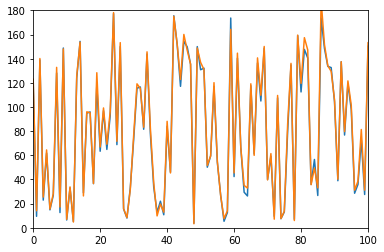

In [42]:
#hd=history.history
#acc=hd['mse']
#epochs = range(1,len(acc)+1)
#plt.plot(epochs,acc,'bo',label='Mean Squared Error')
#plt.plot(epochs,hd['loss'],'b',label='Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()
plt.plot(test_angles)
plt.plot(predics)
plt.xlim(0,100)
plt.ylim(0,180)
plt.show()

In [43]:
acc = np.zeros(len(predics))
for i in range(len(predics)):
    if(abs(predics[i]-test_angles[i])<15):
        acc[i]=1
    else:
        acc[i]=0
np.mean(acc)

0.9603831598864712

In [46]:
np.save("/home/amitp/Documents/Python/Training Orientation Detection/neural_net",predics)
np.save("/home/amitp/Documents/Python/Training Orientation Detection/angles",angles)

In [47]:
del data